# EAH stability Paper
### Yashaswini Rajendra Bhat, Kathleen Keller, Pennsylvania State University, Dept of Nutritional Sciences

#### Import required libraries and modules

In [1]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

#### Read in missing value imputed (output of pre-processing)

In [3]:
df=pd.read_excel("EAH_DB_no_low_fullness.xlsx")

In [4]:
df.columns

Index(['id', 'item clean', 'Audio mode', 'v1_date', 'v7_date', 'bmi_screenout',
       'parent_respondent', 'measured_parent', 'risk_status_mom', 'sex',
       'age_yr', 'v7_age_yr', 'ethnicity', 'race', 'income', 'parent_ed',
       'bmi', 'v7_bmi', 'bmi_percentile', 'v7_bmi_percentile', 'bmi_z',
       'v7_bmi_z', 'v1_FMI', 'v7_FMI', 'pds_tanner_cat', 'v7_p_pds_imputed',
       'v1_freddy_pre_meal', 'v1_freddy_pre_eah', 'v7_freddy_pre_meal',
       'v7_freddy_pre_eah', 'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g', 'age_diff', 'v1_vas_popcorn', 'v1_vas_pretzle',
       'v1_vas_cornchip', 'v1_vas_cookie', 'v1_vas_brownie',
       'v1_vas_starburst', 'v1_vas_skittle', 'v1_vas_hershey',
       'v1_vas_icecream', 'v1_vas_pbj_sndwch', 'v1_vas_ham_sndwc

#### Figure out outliers in intake variables and winsorize

In [5]:
outlier_cols = [
    'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
    'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
    'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
    'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
    'v7_eah_sav_g', 'v1_freddy_pre_eah', 'v7_freddy_pre_eah'
]

In [6]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)


{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 1, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 2, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0, 'v7_freddy_pre_eah': 0}


# ICC results

In [7]:
df_icc=df.copy()

In [8]:
df_icc.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  2.0           1          H  2018-02-19  2019-05-16              0   
2  3.0           0          H  2018-02-15  2019-09-11              0   
3  5.0           0          H  2018-04-23  2019-08-15              0   
4  6.0           0          H  2018-05-09  2019-06-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    0    8.14   
2                  0                0                0    1    8.33   
3                  0                0                0    1    8.32   
4                  0                0                1    1    8.51   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       3          3  16.13   15.96   
1       9.38          0     0       5          3  16.08   16.05   
2       9.90          0     0       5          4  14.52   15.26   
3       9.63          0     0       4          3  15.50   15.68   
4       9.62          0     0       3          3  17.21   17.01   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z  v1_FMI  v7_FMI  \
0           51.16              33.28   0.03     -0.43    4.38    3.87   
1           56.29              44.15   0.16     -0.15    4.32    4.34   
2           18.83              21.87  -0.88     -0.78    3.96    3.76   
3           40.25              31.99  -0.25     -0.47    3.64    3.73   
4           70.14              56.74   0.53      0.17    5.68    5.48   

   pds_tanner_cat  v7_p_pds_imputed  v1_freddy_pre_meal  v1_freddy_pre_eah  \
0               1                 1                  80                135   
1               1                 1                  19                103   
2               1                 1                  37                 86   
3               1                 2                  20                 79   
4               2                 3                  11                109   

   v7_freddy_pre_meal  v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal    v1_eah_g  \
0                  44                120     328.15     760.71928   63.300000   
1                   1                114     113.42      55.81334  114.847824   
2                  19                120     200.39     412.77302   93.840000   
3                  53                 79     419.09     666.28235   71.470000   
4                  61                131      57.82     287.28023   60.500000   

   v1_eah_kcal  v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  \
0   228.075890           60.41          211.58266      2.890000   
1   274.911764           94.90          384.36666      5.953182   
2   261.071900           65.11          223.50080      6.980000   
3   176.648430           59.06          163.33098      2.350000   
4   249.083920           58.66          239.73964      1.640000   

   v1_eah_sav_kcal  v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  \
0        16.493230     488.46     767.61684     60.77    211.06397   
1        31.098658     404.53     723.46376    212.81    242.38241   
2        37.571100     449.40     691.07901    243.80    389.44956   
3        13.317450     434.48     459.85003    110.92    147.74825   
4         9.344280      14.03      66.72736     64.40    294.03093   

   v7_eah_sweet_g  v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  \
0           57.52          192.51622         18.54775          3.25      1.43   
1           75.01          241.18394          1.19847          0.21      1.24   
2           99.50          384.80262          4.64694          0.82      1.57   
3           55.59          141.63839          6.10986          1.18      1.31   
4           57.72          257.94585         36.08508          6.68      1.11   

   v1_vas_popcorn  v1_vas_pretzle  

In [9]:
# making subsets for each ICC calculation for each type of intake
EAH_kcal = df_icc[['id','v1_eah_kcal', 'v7_eah_kcal']].copy()
EAH_g = df_icc[['id','v1_eah_g', 'v7_eah_g']].copy()

meal_kcal = df_icc[['id','v1_meal_kcal', 'v7_meal_kcal']].copy()
meal_g = df_icc[['id','v1_meal_g', 'v7_meal_g']].copy()

EAH_sweet_kcal = df_icc[['id','v1_eah_sweet_kcal', 'v7_eah_sweet_kcal']].copy()
EAH_sweet_g = df_icc[['id','v1_eah_sweet_g', 'v7_eah_sweet_g']].copy()

EAH_savory_kcal = df_icc[['id','v1_eah_sav_kcal', 'v7_eah_sav_kcal']].copy()
EAH_savory_g = df_icc[['id','v1_eah_sav_g', 'v7_eah_sav_g']].copy()

In [10]:
# converting all into long form using pd.melt
EAH_kcal_long = pd.melt(EAH_kcal, id_vars='id', value_vars=['v1_eah_kcal', 'v7_eah_kcal'],var_name='visit', value_name='intake_eah_kcal')
EAH_g_long = pd.melt(EAH_g, id_vars='id', value_vars=['v1_eah_g', 'v7_eah_g'], var_name='visit', value_name='intake_eah_g')


meal_kcal_long = pd.melt(meal_kcal, id_vars='id', value_vars=['v1_meal_kcal', 'v7_meal_kcal'], var_name='visit', value_name='intake_meal_kcal')
meal_g_long = pd.melt(meal_g, id_vars='id', value_vars=['v1_meal_g', 'v7_meal_g'], var_name='visit', value_name='intake_meal_g')

EAH_sweet_kcal_long = pd.melt(EAH_sweet_kcal, id_vars='id', value_vars=['v1_eah_sweet_kcal', 'v7_eah_sweet_kcal'], var_name='visit', value_name='intake_eah_sweet_kcal')
EAH_sweet_g_long = pd.melt(EAH_sweet_g, id_vars='id', value_vars=['v1_eah_sweet_g', 'v7_eah_sweet_g'], var_name='visit', value_name='intake_eah_sweet_g')

EAH_savory_kcal_long = pd.melt(EAH_savory_kcal, id_vars='id', value_vars=['v1_eah_sav_kcal', 'v7_eah_sav_kcal'],var_name='visit', value_name='intake_eah_sav_kcal')
EAH_savory_g_long = pd.melt(EAH_savory_g, id_vars='id', value_vars=['v1_eah_sav_g', 'v7_eah_sav_g'], var_name='visit', value_name='intake_eah_sav_g')

In [11]:
# ICC calculation for each sub dataset
icc_result_EAH_kcal = pg.intraclass_corr(data=EAH_kcal_long, targets='id', raters='visit', ratings='intake_eah_kcal')
icc_result_EAH_g = pg.intraclass_corr(data=EAH_g_long, targets='id', raters='visit', ratings='intake_eah_g')

icc_result_meal_kcal = pg.intraclass_corr(data=meal_kcal_long, targets='id', raters='visit', ratings='intake_meal_kcal')
icc_result_meal_g = pg.intraclass_corr(data=meal_g_long, targets='id', raters='visit', ratings='intake_meal_g')

icc_result_EAH_sweet_kcal = pg.intraclass_corr(data=EAH_sweet_kcal_long, targets='id', raters='visit', ratings='intake_eah_sweet_kcal')
icc_result_EAH_sweet_g = pg.intraclass_corr(data=EAH_sweet_g_long, targets='id', raters='visit', ratings='intake_eah_sweet_g')

icc_result_EAH_savory_kcal = pg.intraclass_corr(data=EAH_savory_kcal_long, targets='id', raters='visit', ratings='intake_eah_sav_kcal')
icc_result_EAH_savory_g = pg.intraclass_corr(data=EAH_savory_g_long, targets='id', raters='visit', ratings='intake_eah_sav_g')

In [12]:
# Create a dictionary to store the icc_result for each variable
icc_results = {
    'meal_kcal': icc_result_meal_kcal,
    'meal_g': icc_result_meal_g,
    'EAH_kcal': icc_result_EAH_kcal,
    'EAH_g': icc_result_EAH_g,
    'EAH_sweet_kcal': icc_result_EAH_sweet_kcal,
    'EAH_sweet_g': icc_result_EAH_sweet_g,
    'EAH_savory_kcal': icc_result_EAH_savory_kcal,
    'EAH_savory_g': icc_result_EAH_savory_g,
}

# List to store each row of the ICC table
icc_table_rows = []

# Loop through each variable and extract the relevant ICC2 information
for var, icc_result in icc_results.items():
    icc2_value = icc_result[icc_result['Type'] == 'ICC2']['ICC'].values[0]
    p_value = icc_result[icc_result['Type'] == 'ICC2']['pval'].values[0]
    ci95 = icc_result[icc_result['Type'] == 'ICC2']['CI95%'].values[0]

    # Append the information to the icc_table_rows list
    icc_table_rows.append({
        'Measured for': var,
        'ICC2': icc2_value,
        'p-value': p_value,
        'CI95%': ci95
    })

# Convert the list of dictionaries into a DataFrame
icc_table = pd.DataFrame(icc_table_rows)

# Print the ICC table
print(icc_table)

# Save the table to an Excel file
icc_table.to_excel('ICC results_all.xlsx', index=False)

      Measured for      ICC2       p-value         CI95%
0        meal_kcal  0.639094  2.976820e-07  [0.41, 0.79]
1           meal_g  0.614228  7.099111e-07  [0.37, 0.78]
2         EAH_kcal  0.564459  1.745260e-05  [0.33, 0.74]
3            EAH_g  0.298686  1.541837e-02  [0.02, 0.54]
4   EAH_sweet_kcal  0.542614  4.328440e-05   [0.3, 0.72]
5      EAH_sweet_g  0.629896  8.155807e-07  [0.41, 0.78]
6  EAH_savory_kcal  0.180715  1.084296e-01  [-0.1, 0.44]
7     EAH_savory_g  0.100981  2.554054e-01  [-0.2, 0.38]


# Spearman Rank Coefficients for confirming ICC

In [13]:
spearman_df=df.copy()

In [14]:
spearman_df.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  2.0           1          H  2018-02-19  2019-05-16              0   
2  3.0           0          H  2018-02-15  2019-09-11              0   
3  5.0           0          H  2018-04-23  2019-08-15              0   
4  6.0           0          H  2018-05-09  2019-06-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    0    8.14   
2                  0                0                0    1    8.33   
3                  0                0                0    1    8.32   
4                  0                0                1    1    8.51   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       3          3  16.13   15.96   
1       9.38          0     0       5          3  16.08   16.05   
2       9.90          0     0       5          4  14.52   15.26   
3       9.63          0     0       4          3  15.50   15.68   
4       9.62          0     0       3          3  17.21   17.01   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z  v1_FMI  v7_FMI  \
0           51.16              33.28   0.03     -0.43    4.38    3.87   
1           56.29              44.15   0.16     -0.15    4.32    4.34   
2           18.83              21.87  -0.88     -0.78    3.96    3.76   
3           40.25              31.99  -0.25     -0.47    3.64    3.73   
4           70.14              56.74   0.53      0.17    5.68    5.48   

   pds_tanner_cat  v7_p_pds_imputed  v1_freddy_pre_meal  v1_freddy_pre_eah  \
0               1                 1                  80                135   
1               1                 1                  19                103   
2               1                 1                  37                 86   
3               1                 2                  20                 79   
4               2                 3                  11                109   

   v7_freddy_pre_meal  v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal    v1_eah_g  \
0                  44                120     328.15     760.71928   63.300000   
1                   1                114     113.42      55.81334  114.847824   
2                  19                120     200.39     412.77302   93.840000   
3                  53                 79     419.09     666.28235   71.470000   
4                  61                131      57.82     287.28023   60.500000   

   v1_eah_kcal  v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  \
0   228.075890           60.41          211.58266      2.890000   
1   274.911764           94.90          384.36666      5.953182   
2   261.071900           65.11          223.50080      6.980000   
3   176.648430           59.06          163.33098      2.350000   
4   249.083920           58.66          239.73964      1.640000   

   v1_eah_sav_kcal  v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  \
0        16.493230     488.46     767.61684     60.77    211.06397   
1        31.098658     404.53     723.46376    212.81    242.38241   
2        37.571100     449.40     691.07901    243.80    389.44956   
3        13.317450     434.48     459.85003    110.92    147.74825   
4         9.344280      14.03      66.72736     64.40    294.03093   

   v7_eah_sweet_g  v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  \
0           57.52          192.51622         18.54775          3.25      1.43   
1           75.01          241.18394          1.19847          0.21      1.24   
2           99.50          384.80262          4.64694          0.82      1.57   
3           55.59          141.63839          6.10986          1.18      1.31   
4           57.72          257.94585         36.08508          6.68      1.11   

   v1_vas_popcorn  v1_vas_pretzle  

In [15]:
sr_cols=['v1_meal_g','v1_meal_kcal','v7_meal_g','v7_meal_kcal','v1_eah_g','v1_eah_kcal','v7_eah_g','v7_eah_kcal','v1_eah_sweet_g','v1_eah_sweet_kcal','v7_eah_sweet_g','v7_eah_sweet_kcal','v1_eah_sav_g','v1_eah_sav_kcal','v7_eah_sav_g','v7_eah_sav_kcal']

In [16]:
# Assuming your dataframe is spearman_df and the columns are in sr_cols
spearman_results = {}

for col in sr_cols:
    if col.startswith("v1_"):
        v7_col = col.replace("v1_", "v7_")
        if v7_col in sr_cols:
            correlation, p_value = spearmanr(spearman_df[col], spearman_df[v7_col])
            formatted_correlation = "{:.2f}".format(correlation)
            formatted_p_value = "{:.2f}".format(p_value)  # Format p-value to two decimal places
            
            # Calculate the number of data points
            n = len(spearman_df)
            
            # Calculate the Fisher transformation of the correlation
            fisher_transform = 0.5 * np.log((1 + correlation) / (1 - correlation))
            
            # Calculate the standard error of the Fisher transform
            standard_error = 1 / np.sqrt(n - 3)
            
            # Calculate the margin of error for the 95% CI
            margin_of_error = 1.96 * standard_error
            
            # Calculate the lower and upper bounds of the CI
            ci_lower = np.tanh(fisher_transform - margin_of_error)
            ci_upper = np.tanh(fisher_transform + margin_of_error)
            
            formatted_ci_lower = "{:.2f}".format(ci_lower)
            formatted_ci_upper = "{:.2f}".format(ci_upper)
            
            spearman_results[col + ' & ' + v7_col] = (formatted_correlation, formatted_p_value, (formatted_ci_lower, formatted_ci_upper))

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(list(spearman_results.items()), columns=['Variable Pair', ('Spearman Rank Correlation', 'p-value', '95% CI')])
print(results_df)

                           Variable Pair  \
0                  v1_meal_g & v7_meal_g   
1            v1_meal_kcal & v7_meal_kcal   
2                    v1_eah_g & v7_eah_g   
3              v1_eah_kcal & v7_eah_kcal   
4        v1_eah_sweet_g & v7_eah_sweet_g   
5  v1_eah_sweet_kcal & v7_eah_sweet_kcal   
6            v1_eah_sav_g & v7_eah_sav_g   
7      v1_eah_sav_kcal & v7_eah_sav_kcal   

  (Spearman Rank Correlation, p-value, 95% CI)  
0                   (0.62, 0.00, (0.40, 0.77))  
1                   (0.69, 0.00, (0.50, 0.82))  
2                   (0.39, 0.01, (0.10, 0.62))  
3                   (0.59, 0.00, (0.36, 0.75))  
4                   (0.65, 0.00, (0.43, 0.79))  
5                   (0.54, 0.00, (0.29, 0.72))  
6                  (0.20, 0.20, (-0.10, 0.47))  
7                  (0.27, 0.08, (-0.03, 0.53))  


# Pre-processing for linear regression

### Scaling continuous values to fit regression methods next

In [17]:
df_linear_reg=df.copy()

In [18]:
scale_cols=['v1_meal_g', 'v1_meal_kcal',
       'v1_eah_g', 'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal',
       'v1_eah_sav_g', 'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal',
       'v7_eah_g', 'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal',
       'v7_eah_sav_kcal', 'v7_eah_sav_g','age_diff','v1_FMI','v7_FMI']

In [19]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the specified columns
scaled_values = scaler.fit_transform(df_linear_reg[scale_cols])

# Replace original columns with scaled values
df_linear_reg[scale_cols] = scaled_values

#### Median split for income and parent_ed

In [20]:
# Recoding the income column
df_linear_reg['income'] = df_linear_reg['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_linear_reg['parent_ed'] = df_linear_reg['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

### One-hot encode for pds tanner cat at v1 and v7 

In [21]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_linear_reg['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_linear_reg.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_linear_reg = pd.concat([df_linear_reg, tanner_dummies], axis=1)

In [22]:
df_linear_reg.head()

id  item clean Audio mode     v1_date     v7_date  bmi_screenout  \
0  1.0           0          H  2018-01-31  2019-07-05              0   
1  2.0           1          H  2018-02-19  2019-05-16              0   
2  3.0           0          H  2018-02-15  2019-09-11              0   
3  5.0           0          H  2018-04-23  2019-08-15              0   
4  6.0           0          H  2018-05-09  2019-06-21              0   

   parent_respondent  measured_parent  risk_status_mom  sex  age_yr  \
0                  0                0                1    0    8.84   
1                  0                0                0    0    8.14   
2                  0                0                0    1    8.33   
3                  0                0                0    1    8.32   
4                  0                0                1    1    8.51   

   v7_age_yr  ethnicity  race  income  parent_ed    bmi  v7_bmi  \
0      10.27          0     0       1          1  16.13   15.96   
1       9.38          0     0       1          1  16.08   16.05   
2       9.90          0     0       1          1  14.52   15.26   
3       9.63          0     0       1          1  15.50   15.68   
4       9.62          0     0       1          1  17.21   17.01   

   bmi_percentile  v7_bmi_percentile  bmi_z  v7_bmi_z    v1_FMI    v7_FMI  \
0           51.16              33.28   0.03     -0.43  0.025336 -0.660075   
1           56.29              44.15   0.16     -0.15 -0.047367 -0.311585   
2           18.83              21.87  -0.88     -0.78 -0.483583 -0.741636   
3           40.25              31.99  -0.25     -0.47 -0.871331 -0.763880   
4           70.14              56.74   0.53      0.17  1.600561  0.533688   

   pds_tanner_cat  v1_freddy_pre_meal  v1_freddy_pre_eah  v7_freddy_pre_meal  \
0               1                  80                135                  44   
1               1                  19                103                   1   
2               1                  37                 86                  19   
3               1                  20                 79                  53   
4               2                  11                109                  61   

   v7_freddy_pre_eah  v1_meal_g  v1_meal_kcal  v1_eah_g  v1_eah_kcal  \
0                120  -0.008774      0.655437 -0.711492    -0.277016   
1                114  -1.287899     -1.836386  0.081631     0.104491   
2                120  -0.769828     -0.574544 -0.241598    -0.008243   
3                 79   0.532946      0.321605 -0.585787    -0.695925   
4                131  -1.619103     -1.018157 -0.754573    -0.105893   

   v1_eah_sweet_g  v1_eah_sweet_kcal  v1_eah_sav_g  v1_eah_sav_kcal  \
0       -0.199360          -0.297228     -0.222884        -0.158894   
1        1.002683           1.145090      0.280192         0.307870   
2       -0.035556          -0.197742      0.448830         0.514718   
3       -0.246410          -0.700011     -0.311569        -0.260386   
4       -0.260351          -0.062187     -0.428175        -0.387362   

   v7_meal_g  v7_meal_kcal  v7_eah_g  v7_eah_kcal  v7_eah_sweet_g  \
0   0.566017      0.418764 -0.892270    -0.655157       -0.497993   
1   0.076875      0.245223  0.713723    -0.403586        0.017843   
2   0.338377      0.117936  1.041069     0.777758        0.740133   
3   0.251423     -0.790901 -0.362538    -1.163753       -0.554915   
4  -2.198950     -2.336054 -0.853927     0.011290       -0.492095   

   v7_eah_sweet_kcal  v7_eah_sav_kcal  v7_eah_sav_g  age_diff  v1_vas_popcorn  \
0          -0.667938         0.315988      0.005816 -0.129480               4   
1          -0.276309        -0.611919     -0.610155 -0.637673               5   
2           0.879389        -0.427481     -0.486555  0.244978               5   
3          -1.077351        -0.349239     -0.413611 -0.450444               4   
4          -0.141426         1.253952      0.700809 -0.985384               3   

   v1_vas_pretzle  v1_vas_cornchip 

In [23]:
# Assuming 'bool_col1' and 'bool_col2' are your boolean columns
df_linear_reg['v7_p_pds_imputed_2'] =df_linear_reg['v7_p_pds_imputed_2'].astype(int)
df_linear_reg['v7_p_pds_imputed_3'] = df_linear_reg['v7_p_pds_imputed_3'].astype(int)

In [24]:
# Map 'H' to 0 and 'AB' to 1 in the 'audio' column
df_linear_reg['Audio mode'] = df_linear_reg['Audio mode'].map({'H': 0, 'AB': 1})

# Regression Models: Intake (kcal) at visit 1 vs. FMI (adiposity) at follow-up

### Model : meal (kcal) at baseline (V1) vs V7 FMI 
##### covariates baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (kcal)

In [25]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom', 'income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_meal_kcal']]
y_mealkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealkcalFMI = sm.add_constant(X_mealkcalFMI)

# Fit a linear regression model using ols
mod_mealkcalFMI = sm.OLS(y_mealkcalFMI, X_mealkcalFMI).fit()

# Get summary of the regression model
print(mod_mealkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     26.95
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.82e-13
Time:                        16:14:16   Log-Likelihood:                -16.318
No. Observations:                  44   AIC:                             52.64
Df Residuals:                      34   BIC:                             70.48
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8614      0

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming your DataFrame is named df and the columns of interest are in outlier_cols
outlier_cols = [
    'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
    'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
    'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
    'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
    'v7_eah_sav_g', 'v1_freddy_pre_eah', 'v7_freddy_pre_eah'
]

# Calculate mean and standard deviation for each column
mean = df_linear_reg[outlier_cols].mean()
std_dev = df_linear_reg[outlier_cols].std()

# Identify outliers that are more than 3 standard deviations from the mean
outliers = (df_linear_reg[outlier_cols] > (mean + 3 * std_dev)) | (df_linear_reg[outlier_cols] < (mean - 3 * std_dev))

# Identify rows with outliers
outliers_df = df_linear_reg[outliers.any(axis=1)]

# Assuming you have already defined your dependent variable y_mealkcalFMI and independent variables X_mealkcalFMI
mod_mealkcalFMI = sm.OLS(y_mealkcalFMI, X_mealkcalFMI).fit()
influence = mod_mealkcalFMI.get_influence()
cooks_d, p_values = influence.cooks_distance

# Combine Cook's Distance with outlier identification
outliers_df['cooks_d'] = cooks_d[outliers.any(axis=1)]

# Identify which outliers are highly influential (e.g., Cook's Distance > 4/n, where n is the number of observations)
threshold = 4 / len(df_linear_reg)
high_influence_outliers = outliers_df[outliers_df['cooks_d'] > threshold]

# Display the 'id' of high influence outliers and 3SD outliers
print("High Influence Outliers based on Cook's Distance (ID):")
print(high_influence_outliers['id'])

print("\n3SD Outliers (ID):")
print(outliers_df['id'])

High Influence Outliers based on Cook's Distance (ID):
6     22.0
17    55.0
Name: id, dtype: float64

3SD Outliers (ID):
6      22.0
17     55.0
31    113.0
39    126.0
Name: id, dtype: float64


C:\Users\ybr5070\AppData\Local\Temp\ipykernel_29520\4275170946.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_df['cooks_d'] = cooks_d[outliers.any(axis=1)]


### Adding audio mode (human story read or read to = 1, audiobook=0)

In [27]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalFMI_audio = df_linear_reg[['v1_FMI','sex', 'risk_status_mom', 'income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','Audio mode','v1_meal_kcal']]
y_mealkcalFMI_audio = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealkcalFMI_audio = sm.add_constant(X_mealkcalFMI_audio)

# Fit a linear regression model using ols
mod_mealkcalFMI_audio = sm.OLS(y_mealkcalFMI_audio, X_mealkcalFMI_audio).fit()

# Get summary of the regression model
print(mod_mealkcalFMI_audio.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     23.56
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           3.12e-12
Time:                        16:14:16   Log-Likelihood:                -16.309
No. Observations:                  44   AIC:                             54.62
Df Residuals:                      33   BIC:                             74.24
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8682      0

# Assumption check for models

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9800330542844744
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


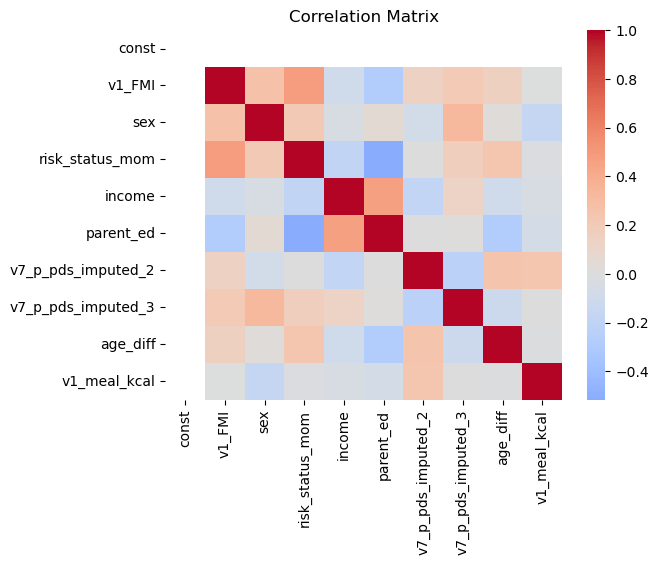

             Variable        VIF
0               const  18.251415
1              v1_FMI   1.448629
2                 sex   1.289848
3     risk_status_mom   1.740965
4              income   1.405064
5           parent_ed   1.938691
6  v7_p_pds_imputed_2   1.326396
7  v7_p_pds_imputed_3   1.263912
8            age_diff   1.223999
9        v1_meal_kcal   1.113691
CHECKING FOR HETEROSKEDASTICITY


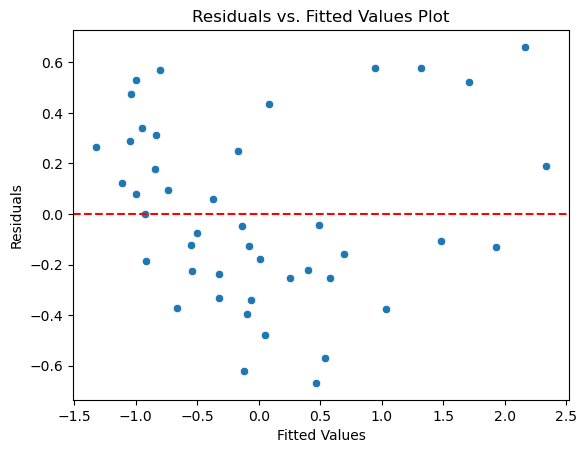

Breusch-Pagan test statistic: 9.724014048626922, p-value: 0.37328643382462784
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


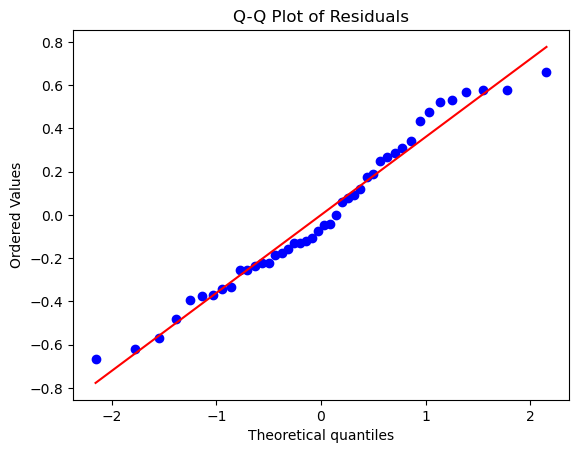

Shapiro-Wilk Test Results:
Statistic: 0.9669651389122009
p-value: 0.235521599650383
Residuals are normally distributed (fail to reject null hypothesis)


In [28]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalFMI= mod_mealkcalFMI.resid
# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalFMI = durbin_watson(residuals_mealkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalFMI)
if 0 < dw_statistic_mealkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalFMI.values, i) for i in range(X_mealkcalFMI.shape[1])]
print(vif_data)

# 5. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalFMI.fittedvalues, y=residuals_mealkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals_mealkcalFMI, mod_mealkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalFMI, p_value_mealkcalFMI = shapiro(residuals_mealkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalFMI)
print("p-value:", p_value_mealkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

# Assumption check for audio model

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.995475669854777
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


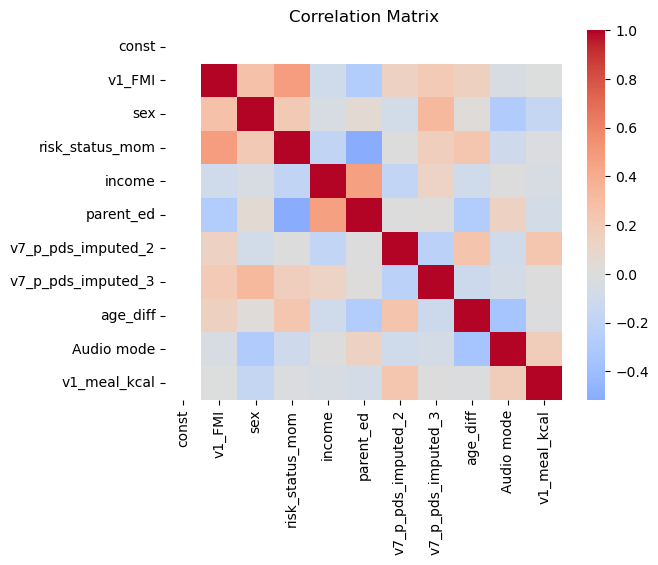

              Variable        VIF
0                const  19.174882
1               v1_FMI   1.472385
2                  sex   1.425702
3      risk_status_mom   1.749124
4               income   1.425796
5            parent_ed   2.000633
6   v7_p_pds_imputed_2   1.350467
7   v7_p_pds_imputed_3   1.270884
8             age_diff   1.353854
9           Audio mode   1.354655
10        v1_meal_kcal   1.148767
CHECKING FOR HETEROSKEDASTICITY


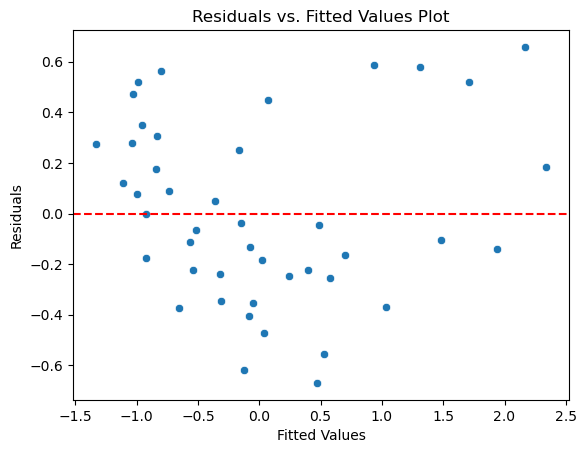

Breusch-Pagan test statistic: 10.175216045152585, p-value: 0.4252579045098963
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


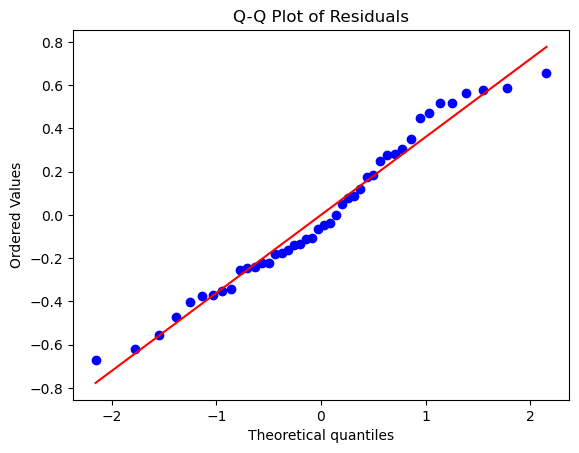

Shapiro-Wilk Test Results:
Statistic: 0.9672980308532715
p-value: 0.24216771125793457
Residuals are normally distributed (fail to reject null hypothesis)


In [29]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalFMI_audio= mod_mealkcalFMI_audio.resid
# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalFMI_audio = durbin_watson(residuals_mealkcalFMI_audio)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalFMI_audio)
if 0 < dw_statistic_mealkcalFMI_audio < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalFMI_audio.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalFMI_audio.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalFMI_audio.values, i) for i in range(X_mealkcalFMI_audio.shape[1])]
print(vif_data)

# 5. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalFMI_audio.fittedvalues, y=residuals_mealkcalFMI_audio)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals_mealkcalFMI_audio, mod_mealkcalFMI_audio.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalFMI_audio, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalFMI_audio, p_value_mealkcalFMI_audio = shapiro(residuals_mealkcalFMI_audio)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalFMI_audio)
print("p-value:", p_value_mealkcalFMI_audio)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalFMI_audio > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (kcal) at baseline (V1) vs V7 FMI
#### covariates baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (kcal)

In [30]:
# Select specific columns as predictors (X) and response (y)

X_EAHkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_kcal']]
y_EAHkcalFMI = df_linear_reg['v7_FMI']


# Add a constant term to the predictors (intercept)
X_EAHkcalFMI = sm.add_constant(X_EAHkcalFMI)

# Fit a linear regression model using ols
mod_EAHkcalFMI = sm.OLS(y_EAHkcalFMI, X_EAHkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     31.47
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.99e-14
Time:                        16:14:17   Log-Likelihood:                -13.301
No. Observations:                  44   AIC:                             46.60
Df Residuals:                      34   BIC:                             64.44
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8935      0

assumptions check for model

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9689626799417215
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


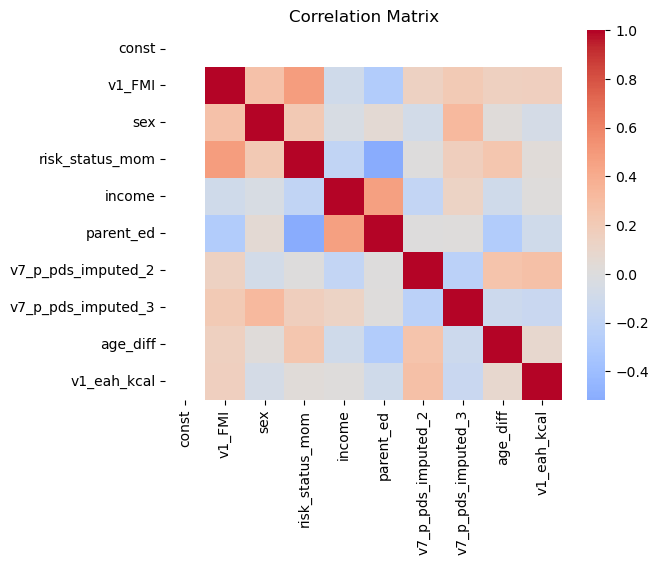

             Variable        VIF
0               const  18.253597
1              v1_FMI   1.477387
2                 sex   1.264777
3     risk_status_mom   1.744405
4              income   1.429482
5           parent_ed   1.949470
6  v7_p_pds_imputed_2   1.315720
7  v7_p_pds_imputed_3   1.265559
8            age_diff   1.217255
9         v1_eah_kcal   1.148138
CHECKING FOR HETEROSKEDASTICITY


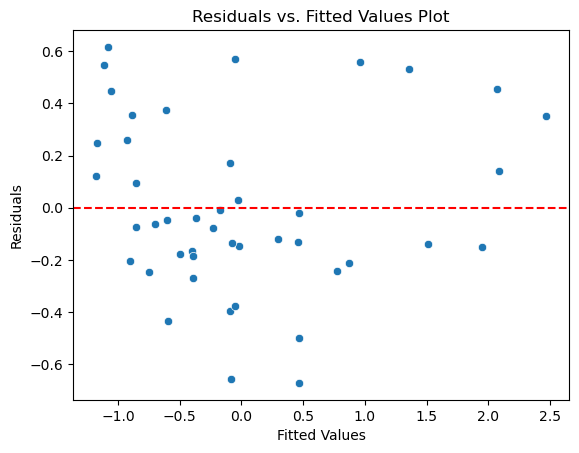

Breusch-Pagan test statistic: 8.77714134454198, p-value: 0.45809529299779705
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


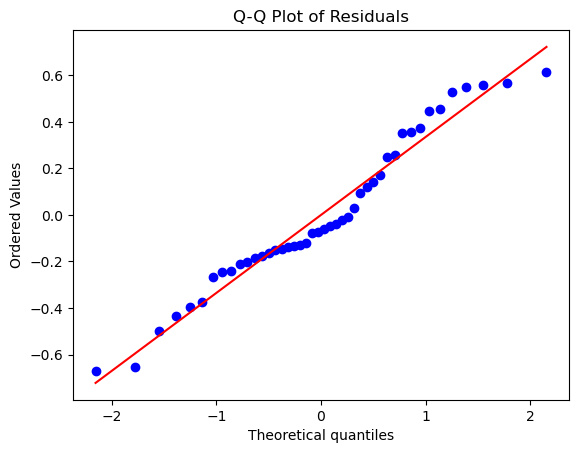

Shapiro-Wilk Test Results:
Statistic: 0.9595373868942261
p-value: 0.12506359815597534
Residuals are normally distributed (fail to reject null hypothesis)


In [31]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalFMI = mod_EAHkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalFMI = durbin_watson(residuals_EAHkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalFMI)
if 0 < dw_statistic_EAHkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalFMI.values, i) for i in range(X_EAHkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalFMI.fittedvalues, y=residuals_EAHkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalFMI, mod_EAHkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalFMI, p_value_EAHkcalFMI = shapiro(residuals_EAHkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalFMI)
print("p-value:", p_value_EAHkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH Sweet (kcal) at baseline (V1) vs V7 FMI
#### covariates: baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline EAH Sweet intake (kcal)

In [32]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sweet_kcal']]
y_EAHsweetkcalFMI = df_linear_reg['v7_FMI']
# Add a constant term to the predictors (intercept)
X_EAHsweetkcalFMI = sm.add_constant(X_EAHsweetkcalFMI)

# Fit a linear regression model using ols
mod_EAHsweetkcalFMI = sm.OLS(y_EAHsweetkcalFMI, X_EAHsweetkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     30.83
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           8.11e-14
Time:                        16:14:17   Log-Likelihood:                -13.703
No. Observations:                  44   AIC:                             47.41
Df Residuals:                      34   BIC:                             65.25
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8606      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.882211400565897
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


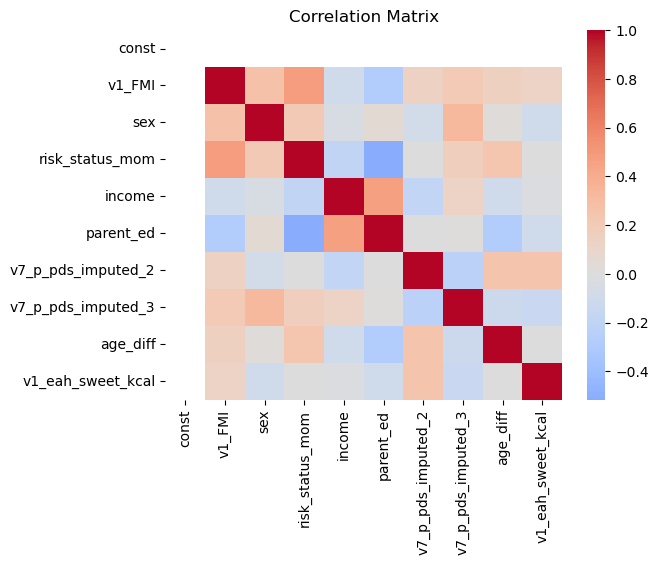

             Variable        VIF
0               const  18.233031
1              v1_FMI   1.473816
2                 sex   1.267000
3     risk_status_mom   1.748027
4              income   1.416106
5           parent_ed   1.954721
6  v7_p_pds_imputed_2   1.306209
7  v7_p_pds_imputed_3   1.261467
8            age_diff   1.229385
9   v1_eah_sweet_kcal   1.131233
CHECKING FOR HETEROSKEDASTICITY


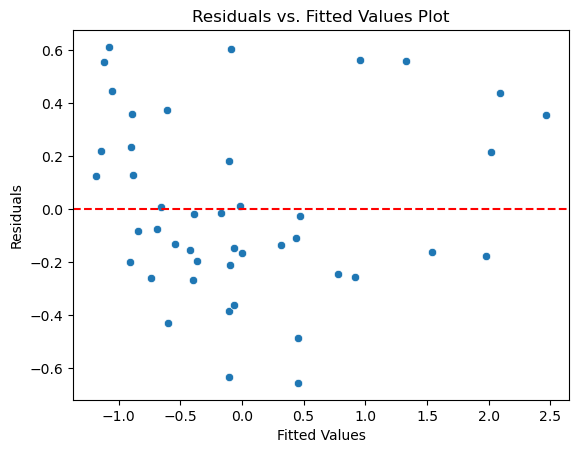

Breusch-Pagan test statistic: 9.413293585029603, p-value: 0.40003044045163844
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


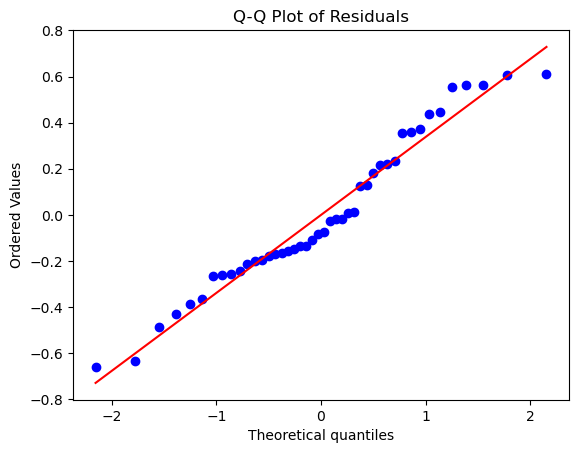

Shapiro-Wilk Test Results:
Statistic: 0.9578843712806702
p-value: 0.10845478624105453
Residuals are normally distributed (fail to reject null hypothesis)


In [33]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalFMI = mod_EAHsweetkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalFMI = durbin_watson(residuals_EAHsweetkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalFMI)
if 0 < dw_statistic_EAHsweetkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalFMI.values, i) for i in range(X_EAHsweetkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalFMI.fittedvalues, y=residuals_EAHsweetkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalFMI,  mod_EAHsweetkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalFMI, p_value_EAHsweetkcalFMI = shapiro(residuals_EAHsweetkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalFMI)
print("p-value:", p_value_EAHsweetkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH savory (kcal) at baseline (V1) vs V7 FMI
#### covariates: baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (kcal)

In [34]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','age_diff','v1_eah_sav_kcal']]
y_EAHsavkcalFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalFMI = sm.add_constant(X_EAHsavkcalFMI)

# Fit a linear regression model using ols
mod_EAHsavkcalFMI = sm.OLS(y_EAHsavkcalFMI, X_EAHsavkcalFMI).fit()

# Get summary of the regression model
print(mod_EAHsavkcalFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     26.11
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.22e-13
Time:                        16:14:17   Log-Likelihood:                -16.931
No. Observations:                  44   AIC:                             53.86
Df Residuals:                      34   BIC:                             71.70
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8780      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.929744690855431
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


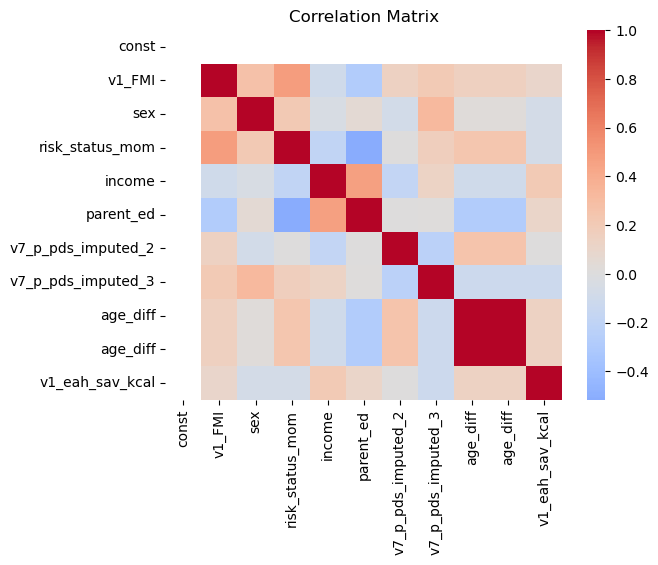

              Variable        VIF
0                const  18.520231
1               v1_FMI   1.500500
2                  sex   1.268696
3      risk_status_mom   1.751181
4               income   1.442520
5            parent_ed   1.926674
6   v7_p_pds_imputed_2   1.243377
7   v7_p_pds_imputed_3   1.272854
8             age_diff        inf
9             age_diff        inf
10     v1_eah_sav_kcal   1.134287
CHECKING FOR HETEROSKEDASTICITY


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


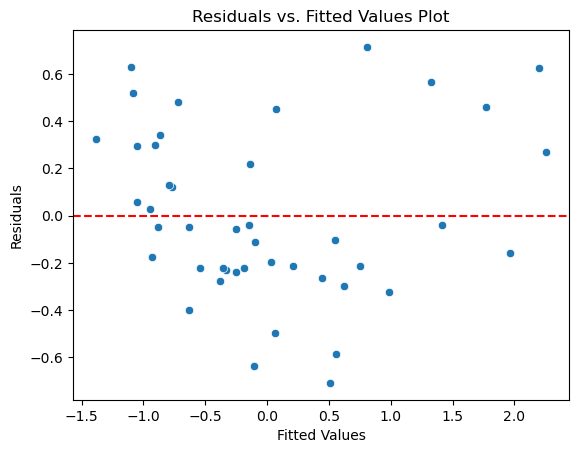

Breusch-Pagan test statistic: 10.87219050533562, p-value: 0.36756192980390956
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


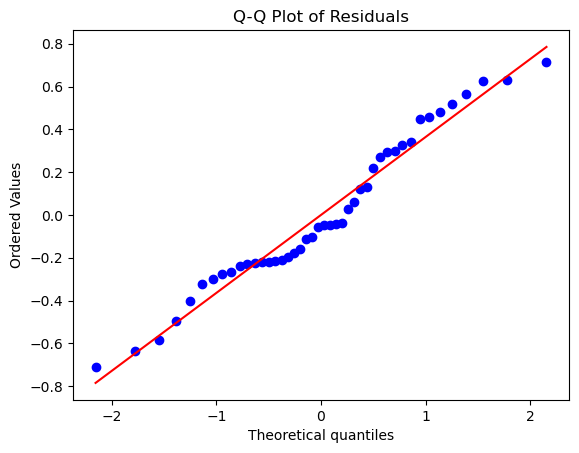

Shapiro-Wilk Test Results:
Statistic: 0.9627262949943542
p-value: 0.16445894539356232
Residuals are normally distributed (fail to reject null hypothesis)


In [35]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalFMI = mod_EAHsavkcalFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalFMI = durbin_watson(residuals_EAHsavkcalFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalFMI)
if 0 < dw_statistic_EAHsavkcalFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalFMI.values, i) for i in range(X_EAHsavkcalFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalFMI.fittedvalues, y=residuals_EAHsavkcalFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalFMI,  mod_EAHsavkcalFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalFMI, p_value_EAHsavkcalFMI = shapiro(residuals_EAHsavkcalFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalFMI)
print("p-value:", p_value_EAHsavkcalFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

# Regression models : Baseline intake (kcal) vs follow-up weight status (BMIz)

### Model : Meal (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (kcal)

In [36]:
# Select specific columns as predictors (X) and response (y)
X_mealkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_meal_kcal']]
y_mealkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealkcalBMIz = sm.add_constant(X_mealkcalBMIz)

# Fit a linear regression model using ols
mod_mealkcalBMIz = sm.OLS(y_mealkcalBMIz, X_mealkcalBMIz).fit()

# Get summary of the regression model
print(mod_mealkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     28.61
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.44e-13
Time:                        16:14:18   Log-Likelihood:              -0.015039
No. Observations:                  44   AIC:                             20.03
Df Residuals:                      34   BIC:                             37.87
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7510      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8721462311386072
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


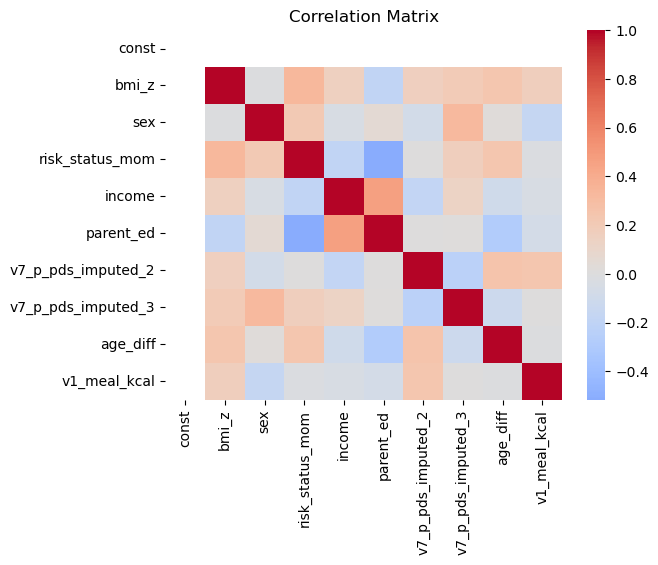

             Variable        VIF
0               const  19.521740
1               bmi_z   1.402651
2                 sex   1.256595
3     risk_status_mom   1.649976
4              income   1.521658
5           parent_ed   1.938022
6  v7_p_pds_imputed_2   1.314336
7  v7_p_pds_imputed_3   1.298165
8            age_diff   1.251251
9        v1_meal_kcal   1.132029
CHECKING FOR HETEROSKEDASTICITY


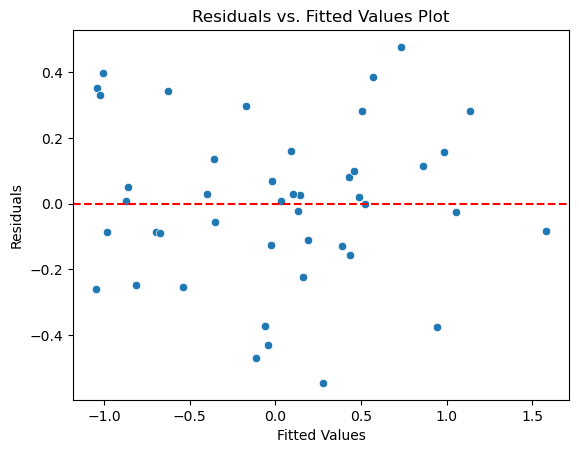

Breusch-Pagan test statistic: 6.091310045748483, p-value: 0.7307459492786725
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


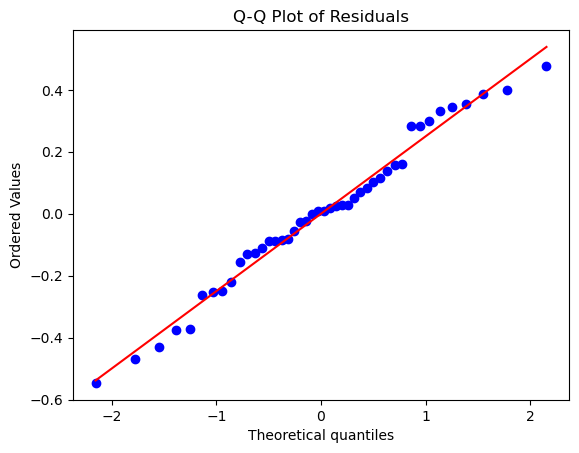

Shapiro-Wilk Test Results:
Statistic: 0.9793274998664856
p-value: 0.606939435005188
Residuals are normally distributed (fail to reject null hypothesis)


In [37]:
# checking for model assumptions
# Calculate the residuals
residuals_mealkcalBMIz= mod_mealkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealkcalBMIz = durbin_watson(residuals_mealkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealkcalBMIz)
if 0 < dw_statistic_mealkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealkcalBMIz.values, i) for i in range(X_mealkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealkcalBMIz.fittedvalues, y=residuals_mealkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealkcalBMIz,  mod_mealkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealkcalBMIz, p_value_mealkcalBMIz = shapiro(residuals_mealkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealkcalBMIz)
print("p-value:", p_value_mealkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (kcal)

In [38]:
# Select specific columns as predictors (X) and response (y)
X_EAHkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_kcal']]
y_EAHkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHkcalBMIz = sm.add_constant(X_EAHkcalBMIz)

# Fit a linear regression model using ols
mod_EAHkcalBMIz = sm.OLS(y_EAHkcalBMIz, X_EAHkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     25.25
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.50e-12
Time:                        16:14:18   Log-Likelihood:                -2.4271
No. Observations:                  44   AIC:                             24.85
Df Residuals:                      34   BIC:                             42.70
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7789      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.793506530191132
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


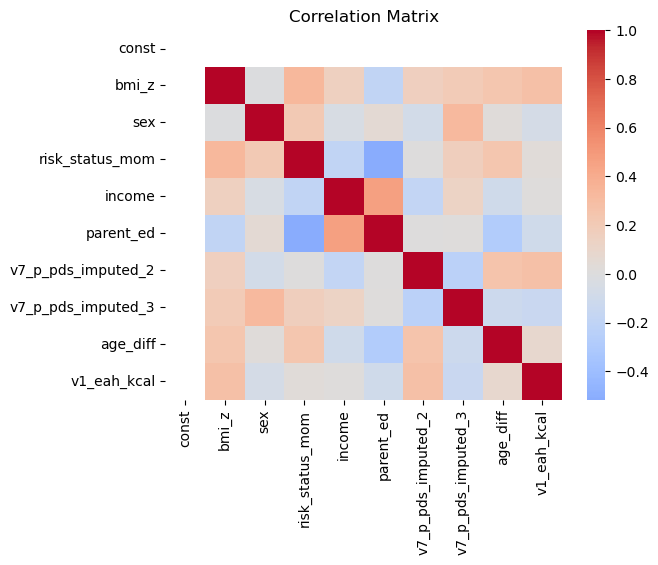

             Variable        VIF
0               const  19.407659
1               bmi_z   1.473960
2                 sex   1.235892
3     risk_status_mom   1.649332
4              income   1.528116
5           parent_ed   1.949220
6  v7_p_pds_imputed_2   1.311041
7  v7_p_pds_imputed_3   1.322240
8            age_diff   1.245893
9         v1_eah_kcal   1.202502
CHECKING FOR HETEROSKEDASTICITY


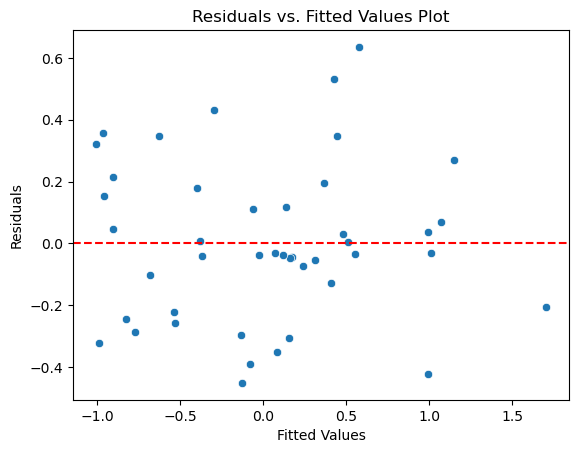

Breusch-Pagan test statistic: 5.457935772202992, p-value: 0.7927029718456533
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


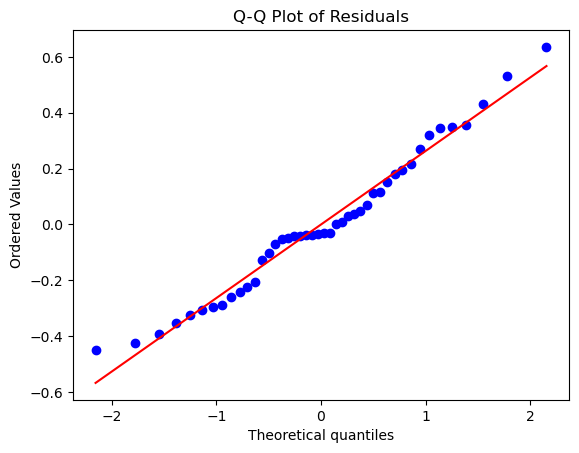

Shapiro-Wilk Test Results:
Statistic: 0.9735361933708191
p-value: 0.400764137506485
Residuals are normally distributed (fail to reject null hypothesis)


In [39]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHkcalBMIz = mod_EAHkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHkcalBMIz = durbin_watson(residuals_EAHkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHkcalBMIz)
if 0 < dw_statistic_EAHkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHkcalBMIz.values, i) for i in range(X_EAHkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHkcalBMIz.fittedvalues, y=residuals_EAHkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHkcalBMIz,  mod_EAHkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHkcalBMIz, p_value_EAHkcalBMIz = shapiro(residuals_EAHkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHkcalBMIz)
print("p-value:", p_value_EAHkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH sweet (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (kcal)

In [40]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sweet_kcal']]
y_EAHsweetkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetkcalBMIz = sm.add_constant(X_EAHsweetkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsweetkcalBMIz= sm.OLS(y_EAHsweetkcalBMIz, X_EAHsweetkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     25.03
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.69e-12
Time:                        16:14:18   Log-Likelihood:                -2.5922
No. Observations:                  44   AIC:                             25.18
Df Residuals:                      34   BIC:                             43.03
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7766      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.7925660112744608
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


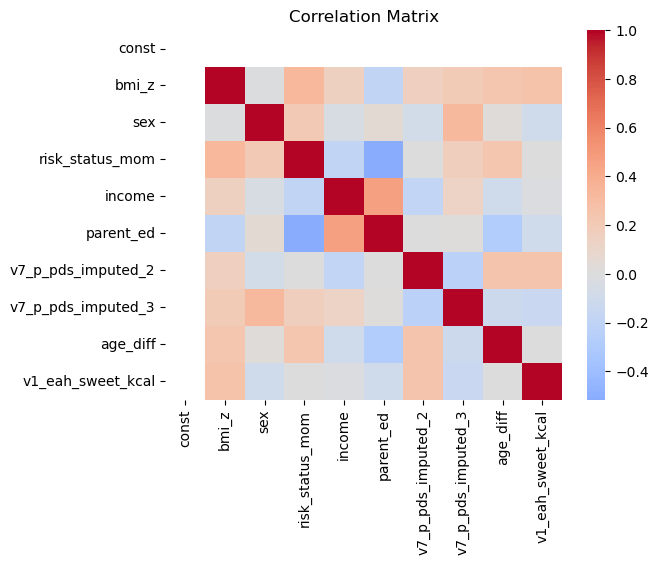

             Variable        VIF
0               const  19.520960
1               bmi_z   1.486895
2                 sex   1.234035
3     risk_status_mom   1.656084
4              income   1.521971
5           parent_ed   1.952858
6  v7_p_pds_imputed_2   1.299901
7  v7_p_pds_imputed_3   1.318498
8            age_diff   1.266119
9   v1_eah_sweet_kcal   1.198090
CHECKING FOR HETEROSKEDASTICITY


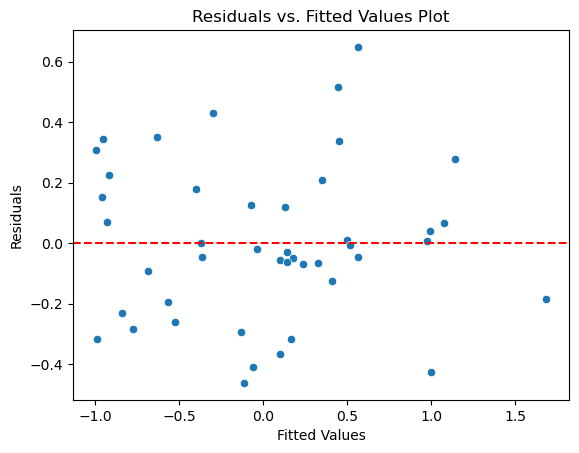

Breusch-Pagan test statistic: 5.0361273200574, p-value: 0.8311476418532135
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


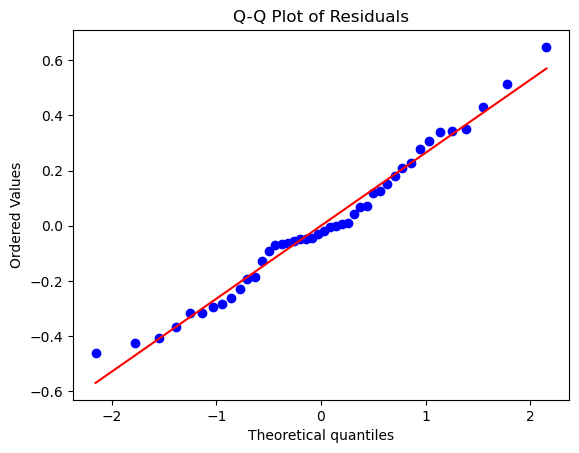

Shapiro-Wilk Test Results:
Statistic: 0.9788089394569397
p-value: 0.5866423845291138
Residuals are normally distributed (fail to reject null hypothesis)


In [41]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetkcalBMIz= mod_EAHsweetkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetkcalBMIz = durbin_watson(residuals_EAHsweetkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetkcalBMIz)
if 0 < dw_statistic_EAHsweetkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetkcalBMIz.values, i) for i in range(X_EAHsweetkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetkcalBMIz.fittedvalues, y=residuals_EAHsweetkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetkcalBMIz,  mod_EAHsweetkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetkcalBMIz, p_value_EAHsweetkcalBMIz = shapiro(residuals_EAHsweetkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetkcalBMIz)
print("p-value:", p_value_EAHsweetkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Model : EAH savory (kcal) at baseline (V1) vs V7 weight status BMIz
#### covariates :baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline EAH savory intake (kcal)

In [42]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavkcalBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sav_kcal']]
y_EAHsavkcalBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavkcalBMIz = sm.add_constant(X_EAHsavkcalBMIz)

# Fit a linear regression model using ols
mod_EAHsavkcalBMIz= sm.OLS(y_EAHsavkcalBMIz, X_EAHsavkcalBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavkcalBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     25.86
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.06e-12
Time:                        16:14:19   Log-Likelihood:                -1.9655
No. Observations:                  44   AIC:                             23.93
Df Residuals:                      34   BIC:                             41.77
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8137      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.799074831177044
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


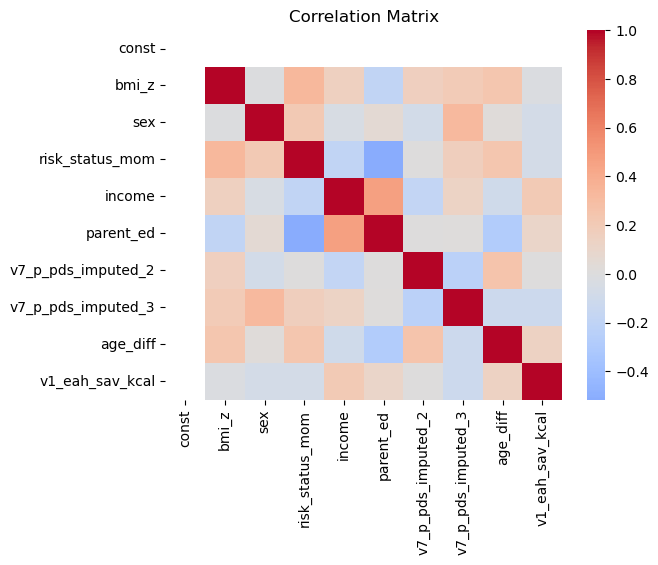

             Variable        VIF
0               const  19.950495
1               bmi_z   1.383875
2                 sex   1.234891
3     risk_status_mom   1.641431
4              income   1.573719
5           parent_ed   1.927214
6  v7_p_pds_imputed_2   1.247018
7  v7_p_pds_imputed_3   1.302501
8            age_diff   1.273516
9     v1_eah_sav_kcal   1.098207
CHECKING FOR HETEROSKEDASTICITY


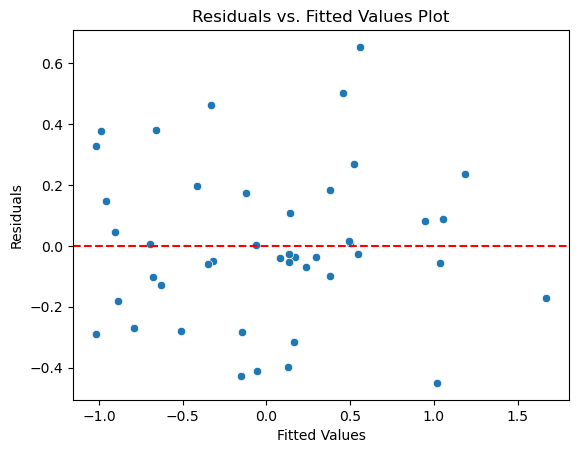

Breusch-Pagan test statistic: 5.0096512122492785, p-value: 0.8334661290769306
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


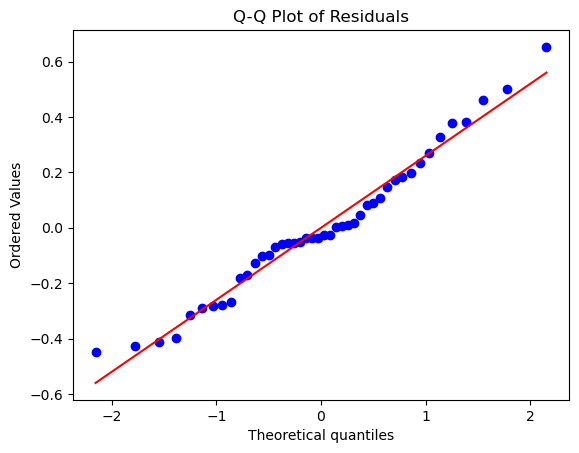

Shapiro-Wilk Test Results:
Statistic: 0.9725824594497681
p-value: 0.37209656834602356
Residuals are normally distributed (fail to reject null hypothesis)


In [43]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavkcalBMIz= mod_EAHsavkcalBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavkcalBMIz = durbin_watson(residuals_EAHsavkcalBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavkcalBMIz)
if 0 < dw_statistic_EAHsavkcalBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavkcalBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavkcalBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavkcalBMIz.values, i) for i in range(X_EAHsavkcalBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavkcalBMIz.fittedvalues, y=residuals_EAHsavkcalBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavkcalBMIz,  mod_EAHsavkcalBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavkcalBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavkcalBMIz, p_value_EAHsavkcalBMIz = shapiro(residuals_EAHsavkcalBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavkcalBMIz)
print("p-value:", p_value_EAHsavkcalBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavkcalBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression model: Intake (gram) at baseline V1 vs follow-up adiposity (FMI)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up adiposity FMI
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1, main predictor: baseline meal intake (gram)

In [44]:
# Select specific columns as predictors (X) and response (y)
X_mealgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_meal_g']]
y_mealgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_mealgFMI = sm.add_constant(X_mealgFMI)

# Fit a linear regression model using ols
mod_mealgFMI= sm.OLS(y_mealgFMI, X_mealgFMI).fit()

# Get summary of the regression model
print(mod_mealgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     26.17
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           8.89e-13
Time:                        16:14:19   Log-Likelihood:                -16.883
No. Observations:                  44   AIC:                             53.77
Df Residuals:                      34   BIC:                             71.61
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8492      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9400366519322263
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


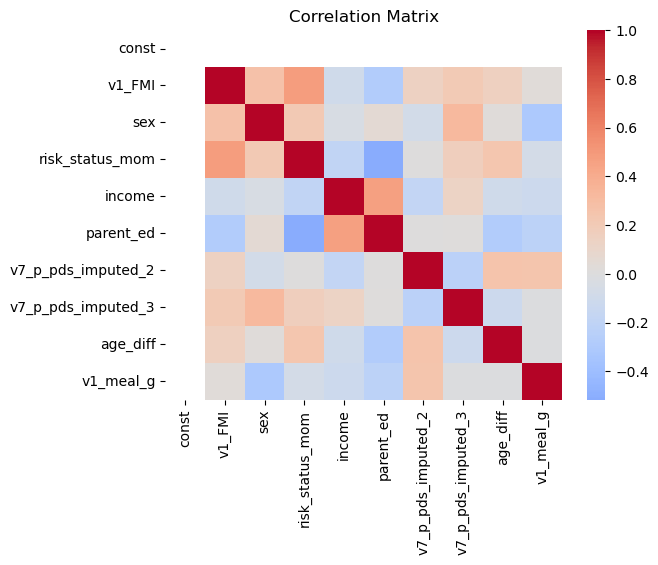

             Variable        VIF
0               const  19.270538
1              v1_FMI   1.451129
2                 sex   1.374919
3     risk_status_mom   1.794024
4              income   1.404297
5           parent_ed   2.066667
6  v7_p_pds_imputed_2   1.341805
7  v7_p_pds_imputed_3   1.282300
8            age_diff   1.230987
9           v1_meal_g   1.325720
CHECKING FOR HETEROSKEDASTICITY


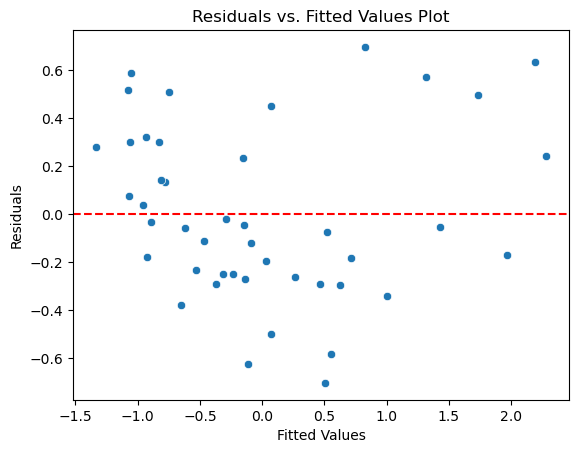

Breusch-Pagan test statistic: 11.2110836391074, p-value: 0.2615173365300844
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


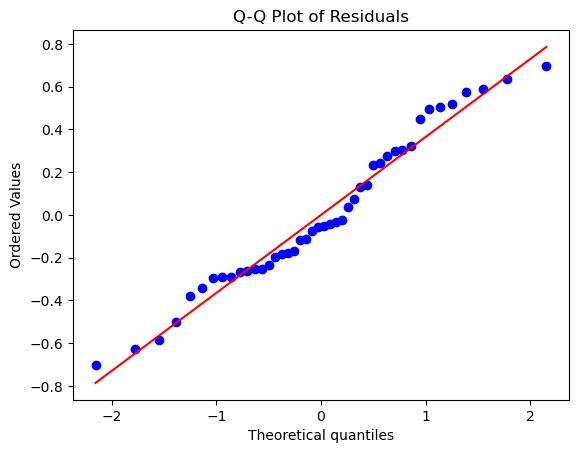

Shapiro-Wilk Test Results:
Statistic: 0.9655346870422363
p-value: 0.20882605016231537
Residuals are normally distributed (fail to reject null hypothesis)


In [45]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgFMI= mod_mealgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgFMI = durbin_watson(residuals_mealgFMI)
print("Durbin-Watson Statistic:", dw_statistic_mealgFMI)
if 0 < dw_statistic_mealgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgFMI.values, i) for i in range(X_mealgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgFMI.fittedvalues, y=residuals_mealgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgFMI,  mod_mealgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgFMI, p_value_mealgFMI = shapiro(residuals_mealgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgFMI)
print("p-value:", p_value_mealgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates :baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (gram)

In [46]:
# Select specific columns as predictors (X) and response (y)
X_EAHgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff','v1_eah_g']]
y_EAHgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHgFMI = sm.add_constant(X_EAHgFMI)

# Fit a linear regression model using ols
mod_EAHgFMI= sm.OLS(y_EAHgFMI, X_EAHgFMI).fit()

# Get summary of the regression model
print(mod_EAHgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     26.37
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           7.99e-13
Time:                        16:14:19   Log-Likelihood:                -16.741
No. Observations:                  44   AIC:                             53.48
Df Residuals:                      34   BIC:                             71.32
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8770      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9193263863219852
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


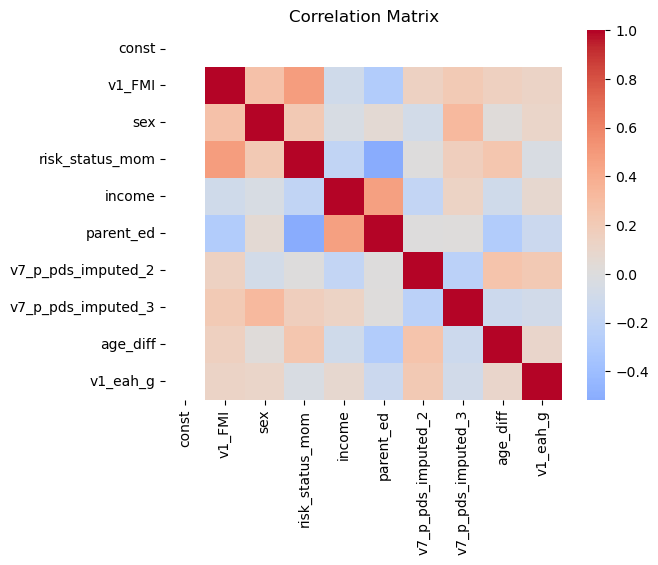

             Variable        VIF
0               const  18.257497
1              v1_FMI   1.457030
2                 sex   1.325481
3     risk_status_mom   1.813635
4              income   1.501105
5           parent_ed   2.094158
6  v7_p_pds_imputed_2   1.313862
7  v7_p_pds_imputed_3   1.263694
8            age_diff   1.215701
9            v1_eah_g   1.214300
CHECKING FOR HETEROSKEDASTICITY


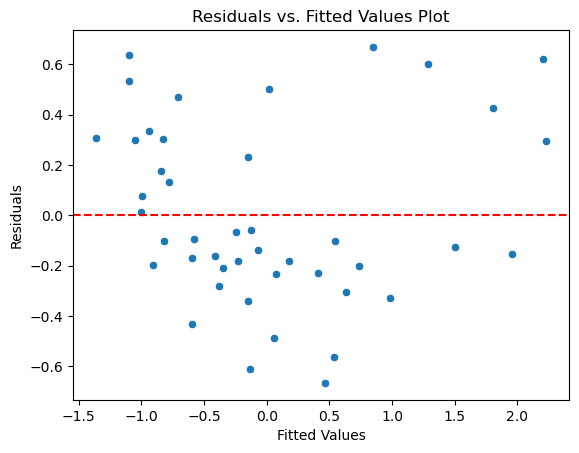

Breusch-Pagan test statistic: 10.983951550857988, p-value: 0.2768105821397553
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


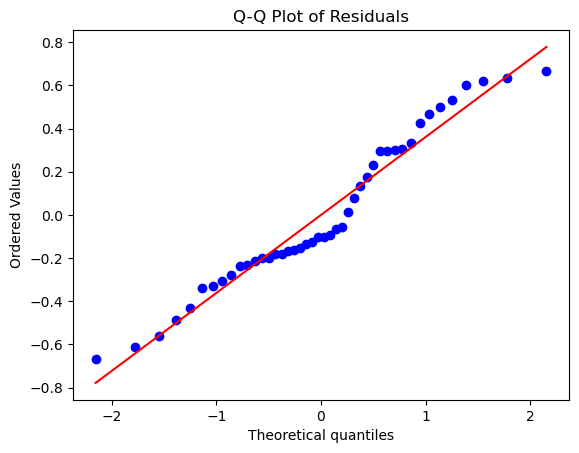

Shapiro-Wilk Test Results:
Statistic: 0.9522284865379333
p-value: 0.0666143000125885
Residuals are normally distributed (fail to reject null hypothesis)


In [47]:
# checking for model assumptions 
# Calculate the residuals
residuals_EAHgFMI= mod_EAHgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgFMI = durbin_watson(residuals_EAHgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHgFMI)
if 0 < dw_statistic_EAHgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgFMI.values, i) for i in range(X_EAHgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgFMI.fittedvalues, y=residuals_EAHgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgFMI,  mod_EAHgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")


# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgFMI, p_value_EAHgFMI = shapiro(residuals_EAHgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgFMI)
print("p-value:", p_value_EAHgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (gram)

In [48]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sweet_g']]
y_EAHsweetgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsweetgFMI = sm.add_constant(X_EAHsweetgFMI)

# Fit a linear regression model using ols
mod_EAHsweetgFMI= sm.OLS(y_EAHsweetgFMI, X_EAHsweetgFMI).fit()

# Get summary of the regression model
print(mod_EAHsweetgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     31.41
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           6.16e-14
Time:                        16:14:20   Log-Likelihood:                -13.338
No. Observations:                  44   AIC:                             46.68
Df Residuals:                      34   BIC:                             64.52
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8487      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.753714204951608
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


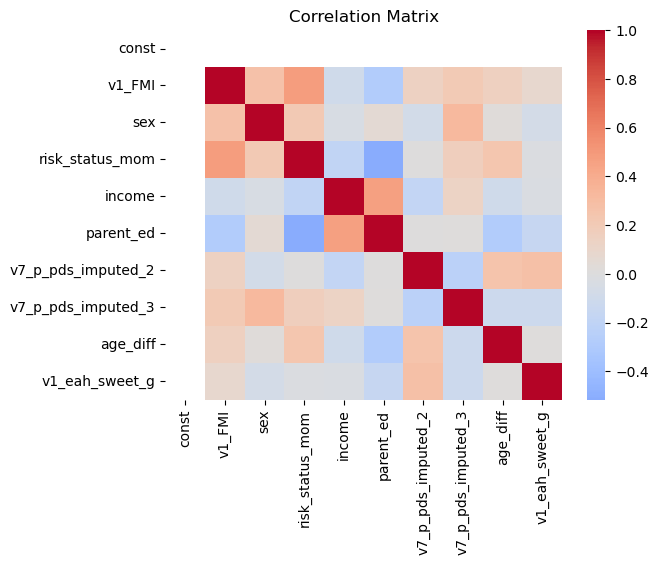

             Variable        VIF
0               const  18.252528
1              v1_FMI   1.450997
2                 sex   1.264854
3     risk_status_mom   1.763995
4              income   1.433264
5           parent_ed   2.042227
6  v7_p_pds_imputed_2   1.358092
7  v7_p_pds_imputed_3   1.254034
8            age_diff   1.234357
9      v1_eah_sweet_g   1.174409
CHECKING FOR HETEROSKEDASTICITY


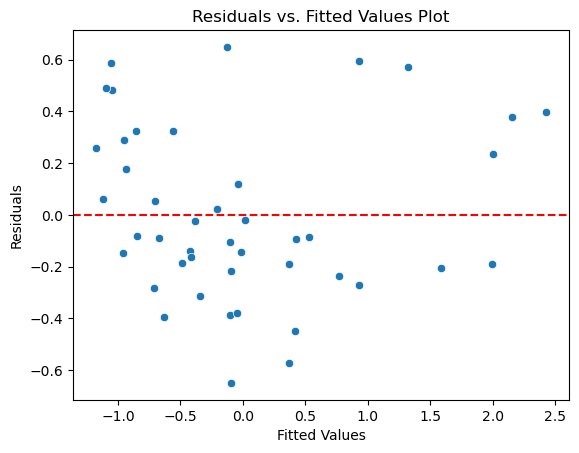

Breusch-Pagan test statistic: 8.421041018493373, p-value: 0.4923341576917095
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


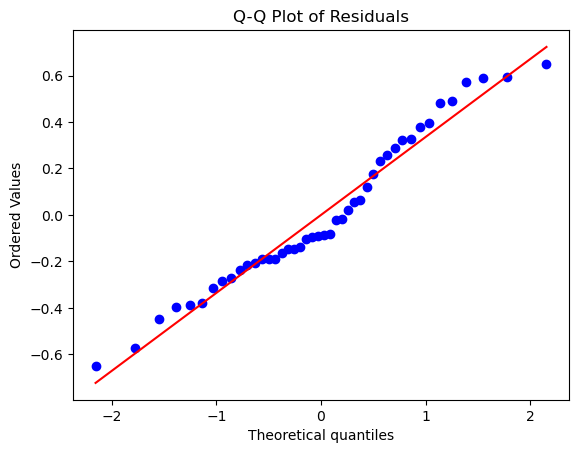

Shapiro-Wilk Test Results:
Statistic: 0.9613255262374878
p-value: 0.14585472643375397
Residuals are normally distributed (fail to reject null hypothesis)


In [49]:
# checking for model assumptions
# Calculate the residuals
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
residuals_EAHsweetgFMI= mod_EAHsweetgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgFMI = durbin_watson(residuals_EAHsweetgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgFMI)
if 0 < dw_statistic_EAHsweetgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgFMI.values, i) for i in range(X_EAHsweetgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgFMI.fittedvalues, y=residuals_EAHsweetgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgFMI,  mod_EAHsweetgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")   
    
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgFMI, p_value_EAHsweetgFMI = shapiro(residuals_EAHsweetgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgFMI)
print("p-value:", p_value_EAHsweetgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up adiposity FMI (v7)
#### covariates : baseline FMI, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (gram)

In [50]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgFMI = df_linear_reg[['v1_FMI','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff','v1_eah_sav_g']]
y_EAHsavgFMI = df_linear_reg['v7_FMI']

# Add a constant term to the predictors (intercept)
X_EAHsavgFMI = sm.add_constant(X_EAHsavgFMI)

# Fit a linear regression model using ols
mod_EAHsavgFMI= sm.OLS(y_EAHsavgFMI, X_EAHsavgFMI).fit()

# Get summary of the regression model
print(mod_EAHsavgFMI.summary())

                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     26.07
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.41e-13
Time:                        16:14:20   Log-Likelihood:                -16.959
No. Observations:                  44   AIC:                             53.92
Df Residuals:                      34   BIC:                             71.76
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8727      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.9232282366898927
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


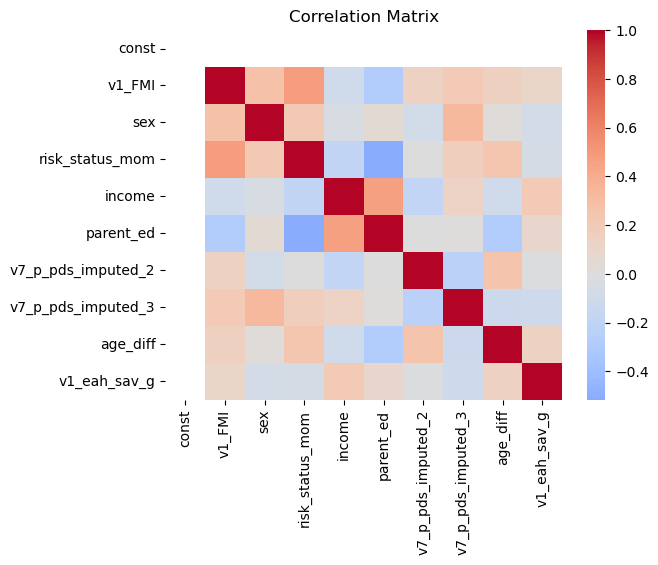

             Variable        VIF
0               const  18.497206
1              v1_FMI   1.500975
2                 sex   1.270553
3     risk_status_mom   1.748560
4              income   1.442727
5           parent_ed   1.925179
6  v7_p_pds_imputed_2   1.246417
7  v7_p_pds_imputed_3   1.268760
8            age_diff   1.249211
9        v1_eah_sav_g   1.129907
CHECKING FOR HETEROSKEDASTICITY


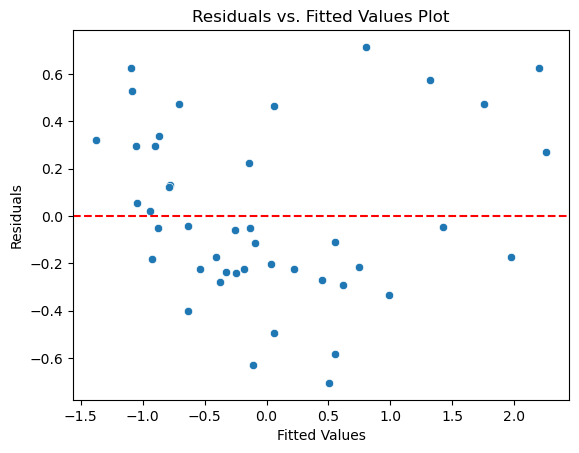

Breusch-Pagan test statistic: 10.85830343082264, p-value: 0.2855467516385101
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


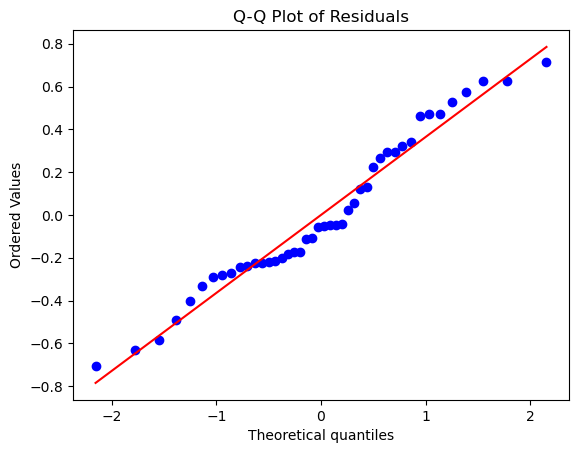

Shapiro-Wilk Test Results:
Statistic: 0.9614157676696777
p-value: 0.14698903262615204
Residuals are normally distributed (fail to reject null hypothesis)


In [51]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgFMI= mod_EAHsavgFMI.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgFMI = durbin_watson(residuals_EAHsavgFMI)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgFMI)
if 0 < dw_statistic_EAHsavgFMI < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgFMI.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgFMI.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgFMI.values, i) for i in range(X_EAHsavgFMI.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgFMI.fittedvalues, y=residuals_EAHsavgFMI)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsavgFMI,  mod_EAHsavgFMI.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgFMI, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgFMI, p_value_EAHsavgFMI = shapiro(residuals_EAHsavgFMI)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgFMI)
print("p-value:", p_value_EAHsavgFMI)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level 
if p_value_EAHsavgFMI > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## Regression models: Intake (gram) at baseline (v1) vs follow-up (v7) weight status (BMIz)

### Model : Meal (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline meal intake (gram)

In [52]:
# Select specific columns as predictors (X) and response (y)
X_mealgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff','v1_meal_g']]
y_mealgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_mealgBMIz= sm.add_constant(X_mealgBMIz)

# Fit a linear regression model using ols
mod_mealgBMIz= sm.OLS(y_mealgBMIz, X_mealgBMIz).fit()

# Get summary of the regression model
print(mod_mealgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     25.77
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.11e-12
Time:                        16:14:21   Log-Likelihood:                -2.0353
No. Observations:                  44   AIC:                             24.07
Df Residuals:                      34   BIC:                             41.91
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7234      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.7994303133199951
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


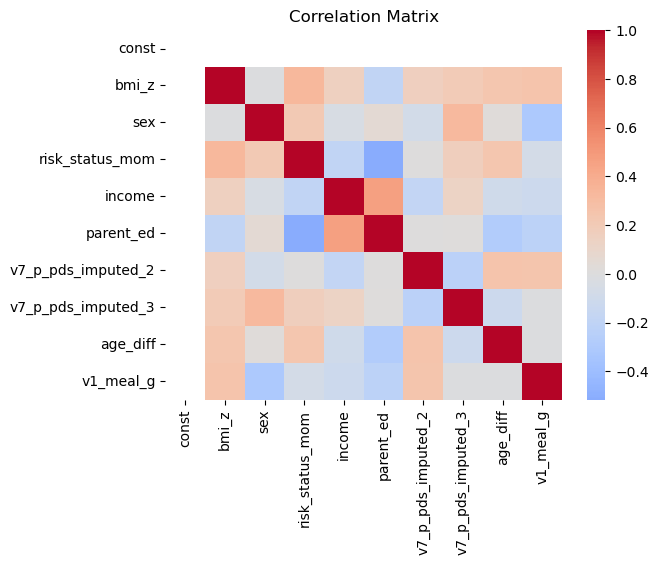

             Variable        VIF
0               const  21.241161
1               bmi_z   1.473314
2                 sex   1.324428
3     risk_status_mom   1.731162
4              income   1.527080
5           parent_ed   2.052911
6  v7_p_pds_imputed_2   1.323751
7  v7_p_pds_imputed_3   1.307595
8            age_diff   1.267190
9           v1_meal_g   1.412997
CHECKING FOR HETEROSKEDASTICITY


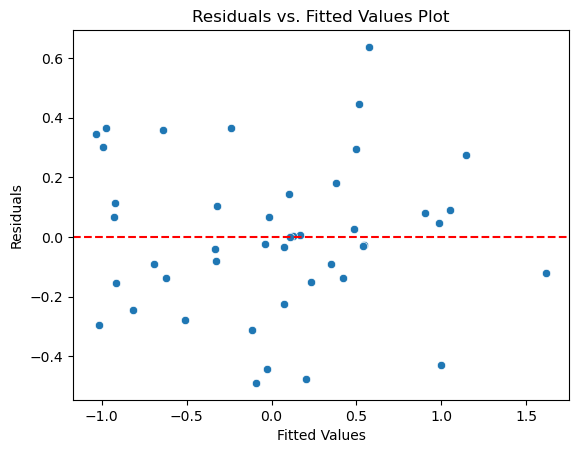

Breusch-Pagan test statistic: 6.184051201439495, p-value: 0.7213657046210763
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


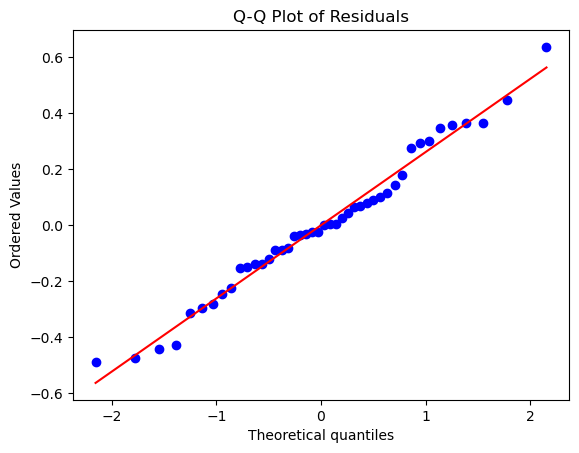

Shapiro-Wilk Test Results:
Statistic: 0.9807966351509094
p-value: 0.6654489040374756
Residuals are normally distributed (fail to reject null hypothesis)


In [53]:
# checking for model assumptions
# Calculate the residuals
residuals_mealgBMIz= mod_mealgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_mealgBMIz = durbin_watson(residuals_mealgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_mealgBMIz)
if 0 < dw_statistic_mealgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_mealgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_mealgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_mealgBMIz.values, i) for i in range(X_mealgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_mealgBMIz.fittedvalues, y=residuals_mealgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_mealgBMIz,  mod_mealgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_mealgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_mealgBMIz, p_value_mealgBMIz = shapiro(residuals_mealgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_mealgBMIz)
print("p-value:", p_value_mealgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_mealgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH intake (gram)

In [54]:
# Select specific columns as predictors (X) and response (y)
X_EAHgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_g']]
y_EAHgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHgBMIz= sm.add_constant(X_EAHgBMIz)

# Fit a linear regression model using ols
mod_EAHgBMIz= sm.OLS(y_EAHgBMIz, X_EAHgBMIz).fit()

# Get summary of the regression model
print(mod_EAHgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     25.26
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.48e-12
Time:                        16:14:21   Log-Likelihood:                -2.4166
No. Observations:                  44   AIC:                             24.83
Df Residuals:                      34   BIC:                             42.68
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7840      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8198770553430845
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


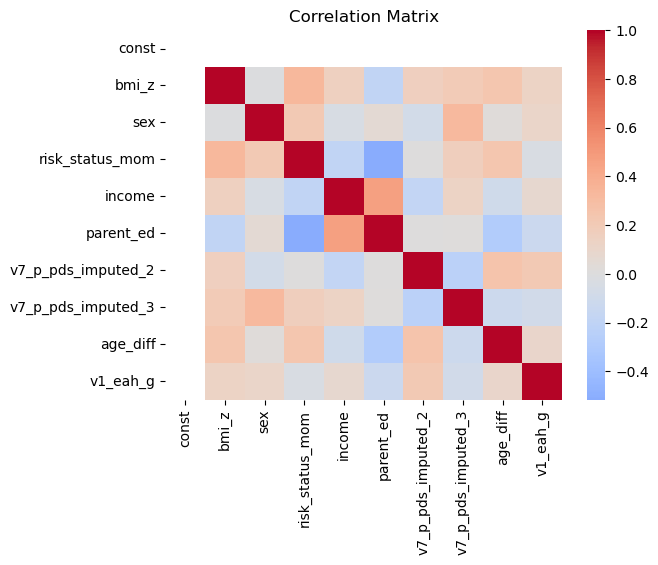

             Variable        VIF
0               const  19.419417
1               bmi_z   1.387553
2                 sex   1.308772
3     risk_status_mom   1.709716
4              income   1.605445
5           parent_ed   2.099394
6  v7_p_pds_imputed_2   1.322810
7  v7_p_pds_imputed_3   1.307661
8            age_diff   1.239397
9            v1_eah_g   1.213969
CHECKING FOR HETEROSKEDASTICITY


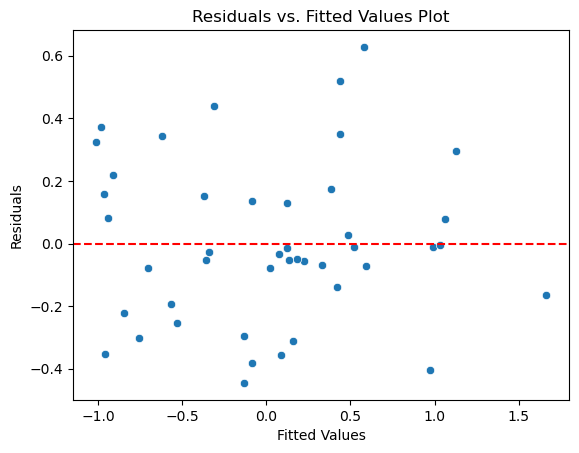

Breusch-Pagan test statistic: 5.6218347786347085, p-value: 0.7770883312910811
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


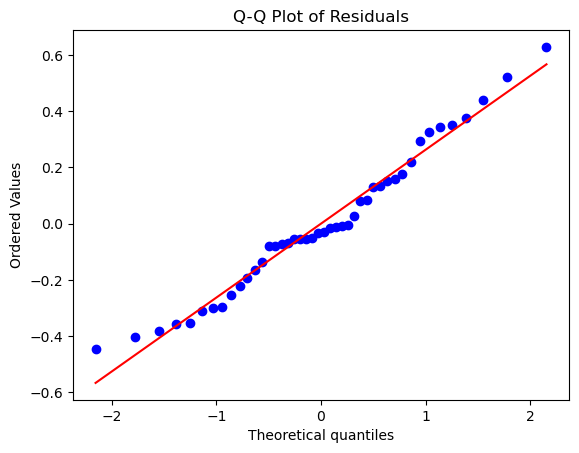

Shapiro-Wilk Test Results:
Statistic: 0.9716134071350098
p-value: 0.3446447253227234
Residuals are normally distributed (fail to reject null hypothesis)


In [55]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHgBMIz= mod_EAHgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHgBMIz = durbin_watson(residuals_EAHgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHgBMIz)
if 0 < dw_statistic_EAHgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHgBMIz.values, i) for i in range(X_EAHgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHgBMIz.fittedvalues, y=residuals_EAHgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHgBMIz,  mod_EAHgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      
# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHgBMIz, p_value_EAHgBMIz = shapiro(residuals_EAHgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHgBMIz)
print("p-value:", p_value_EAHgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH sweet (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates :baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH sweet intake (gram)

In [56]:
# Select specific columns as predictors (X) and response (y)
X_EAHsweetgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3','age_diff', 'v1_eah_sweet_g']]
y_EAHsweetgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsweetgBMIz= sm.add_constant(X_EAHsweetgBMIz)

# Fit a linear regression model using ols
mod_EAHsweetgBMIz= sm.OLS(y_EAHsweetgBMIz, X_EAHsweetgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsweetgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     25.11
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.62e-12
Time:                        16:14:21   Log-Likelihood:                -2.5346
No. Observations:                  44   AIC:                             25.07
Df Residuals:                      34   BIC:                             42.91
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7742      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.7588253261780704
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


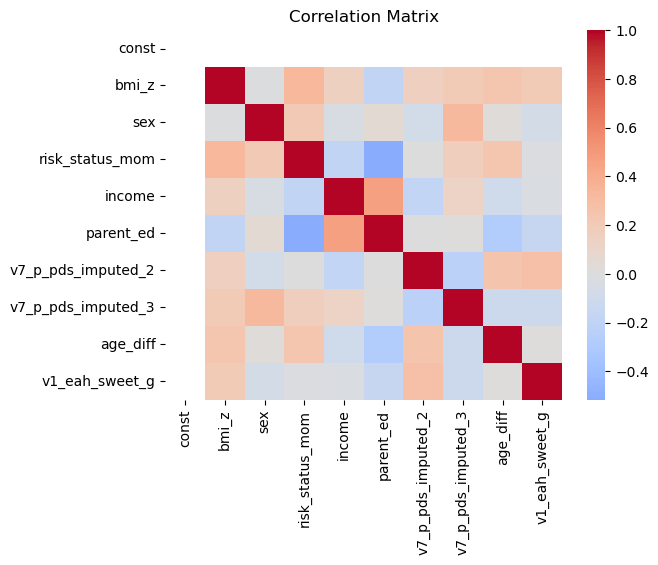

             Variable        VIF
0               const  19.536420
1               bmi_z   1.425914
2                 sex   1.236692
3     risk_status_mom   1.679291
4              income   1.533955
5           parent_ed   2.034752
6  v7_p_pds_imputed_2   1.346986
7  v7_p_pds_imputed_3   1.303696
8            age_diff   1.266910
9      v1_eah_sweet_g   1.211564
CHECKING FOR HETEROSKEDASTICITY


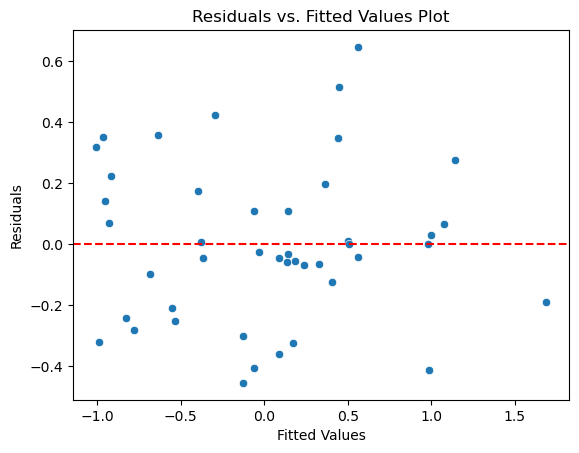

Breusch-Pagan test statistic: 5.416233950485635, p-value: 0.796620445928763
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


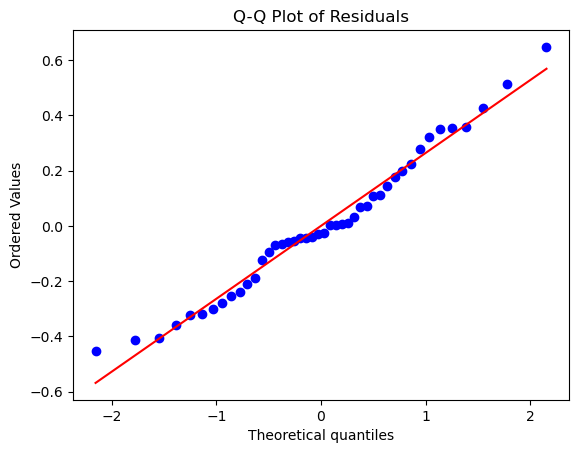

Shapiro-Wilk Test Results:
Statistic: 0.9753789901733398
p-value: 0.4607253968715668
Residuals are normally distributed (fail to reject null hypothesis)


In [57]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsweetgBMIz= mod_EAHsweetgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsweetgBMIz = durbin_watson(residuals_EAHsweetgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsweetgBMIz)
if 0 < dw_statistic_EAHsweetgBMIz < 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsweetgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsweetgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsweetgBMIz.values, i) for i in range(X_EAHsweetgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsweetgBMIz.fittedvalues, y=residuals_EAHsweetgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()

bp_test = het_breuschpagan(residuals_EAHsweetgBMIz,  mod_EAHsweetgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)")  
      

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsweetgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsweetgBMIz, p_value_EAHsweetgBMIz = shapiro(residuals_EAHsweetgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsweetgBMIz)
print("p-value:", p_value_EAHsweetgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsweetgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

### Model : EAH savory (gram) at baseline (V1) vs V7 follow-up weight status BMIz (v7)
#### covariates : baseline BMIz, sex, risk status based on maternal BMI, tanner stage category at T2, parent education, parent yearly income, age differences between v7 and v1,  main predictor: baseline EAH savory intake (gram)

In [58]:
# Select specific columns as predictors (X) and response (y)
X_EAHsavgBMIz = df_linear_reg[['bmi_z','sex', 'risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff', 'v1_eah_sav_g']]
y_EAHsavgBMIz = df_linear_reg['v7_bmi_z']

# Add a constant term to the predictors (intercept)
X_EAHsavgBMIz= sm.add_constant(X_EAHsavgBMIz)

# Fit a linear regression model using ols
mod_EAHsavgBMIz= sm.OLS(y_EAHsavgBMIz, X_EAHsavgBMIz).fit()

# Get summary of the regression model
print(mod_EAHsavgBMIz.summary())

                            OLS Regression Results                            
Dep. Variable:               v7_bmi_z   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     25.79
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.10e-12
Time:                        16:14:22   Log-Likelihood:                -2.0170
No. Observations:                  44   AIC:                             24.03
Df Residuals:                      34   BIC:                             41.88
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8120      0

MULTICOLLINEARITY and AUTOCORRELATION
Durbin-Watson Statistic: 1.8024512883768915
The Durbin-Watson statistic suggests no significant autocorrelation.


c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


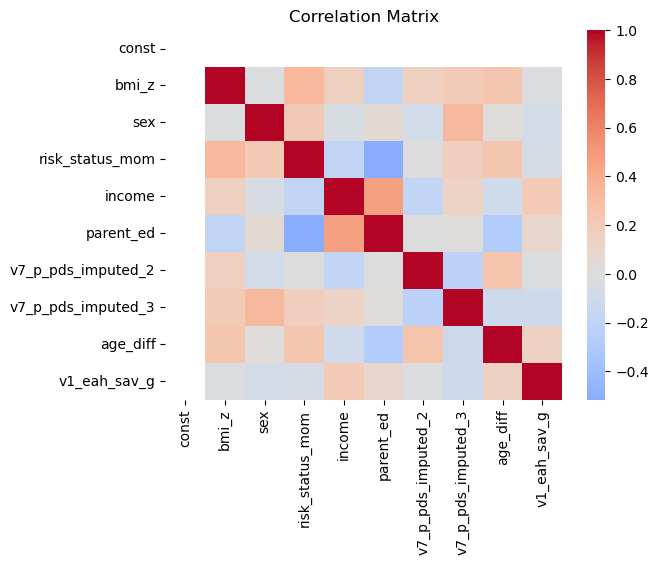

             Variable        VIF
0               const  19.936547
1               bmi_z   1.385390
2                 sex   1.235931
3     risk_status_mom   1.641492
4              income   1.575418
5           parent_ed   1.926396
6  v7_p_pds_imputed_2   1.247689
7  v7_p_pds_imputed_3   1.299298
8            age_diff   1.274092
9        v1_eah_sav_g   1.094818
CHECKING FOR HETEROSKEDASTICITY


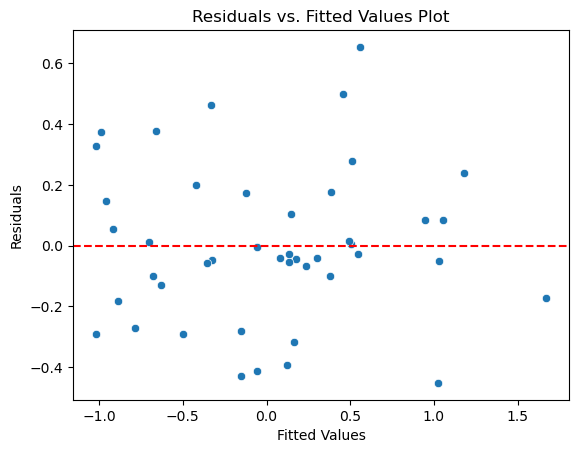

Breusch-Pagan test statistic: 5.016492700199421, p-value: 0.8328681853846835
The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)
NORMALITY


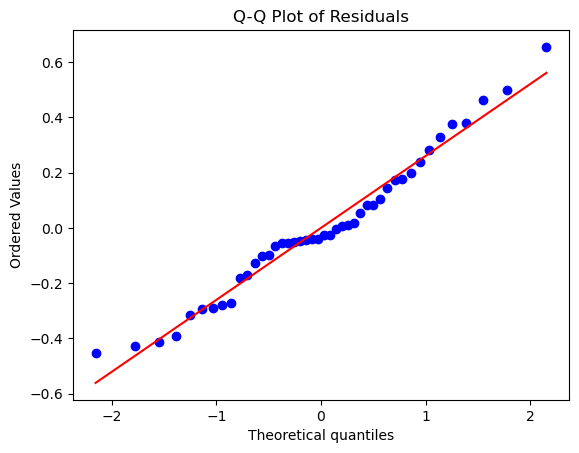

Shapiro-Wilk Test Results:
Statistic: 0.9722113013267517
p-value: 0.3613819181919098
Residuals are normally distributed (fail to reject null hypothesis)


In [59]:
# checking for model assumptions
# Calculate the residuals
residuals_EAHsavgBMIz= mod_EAHsavgBMIz.resid

# 1. Linearity
# partial regression plots - refer later

# 2. Multicollinearity
print("MULTICOLLINEARITY and AUTOCORRELATION")
dw_statistic_EAHsavgBMIz = durbin_watson(residuals_EAHsavgBMIz)
print("Durbin-Watson Statistic:", dw_statistic_EAHsavgBMIz)
if 0 < dw_statistic_EAHsavgBMIz< 4:
    print("The Durbin-Watson statistic suggests no significant autocorrelation.")
else:
    print("The Durbin-Watson statistic indicates potential autocorrelation.")

correlation_matrix = X_EAHsavgBMIz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_EAHsavgBMIz.columns
vif_data["VIF"] = [variance_inflation_factor(X_EAHsavgBMIz.values, i) for i in range(X_EAHsavgBMIz.shape[1])]
print(vif_data)

# 3. Heteroskedasticity Assumption
print("CHECKING FOR HETEROSKEDASTICITY")
sns.scatterplot(x=mod_EAHsavgBMIz.fittedvalues, y=residuals_EAHsavgBMIz)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values Plot")
plt.show()


bp_test = het_breuschpagan(residuals_EAHsavgBMIz,  mod_EAHsavgBMIz.model.exog)
bp_statistic, bp_pvalue, _, _ = bp_test
print(f'Breusch-Pagan test statistic: {bp_statistic}, p-value: {bp_pvalue}')

if bp_pvalue < 0.05:
    print("The Breusch-Pagan test suggests heteroskedasticity (reject null hypothesis of homoskedasticity)")
else:
    print("The Breusch-Pagan test does not suggest heteroskedasticity (fail to reject null hypothesis of homoskedasticity)") 

# 4. Normal Distribution of Error Terms Assumption
# Create a Q-Q plot
print("NORMALITY")
stats.probplot(residuals_EAHsavgBMIz, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Shapiro-Wilk test for normality
statistic_EAHsavgBMIz, p_value_EAHsavgBMIz = shapiro(residuals_EAHsavgBMIz)

# Print the test results
print("Shapiro-Wilk Test Results:")
print("Statistic:", statistic_EAHsavgBMIz)
print("p-value:", p_value_EAHsavgBMIz)

# Check the p-value to determine whether residuals are normally distributed
alpha = 0.05  # Significance level
if p_value_EAHsavgBMIz > alpha:
    print("Residuals are normally distributed (fail to reject null hypothesis)")
else:
    print("Residuals are not normally distributed (reject null hypothesis)")

## DEMOGRAPHIC TABLE - separate for continuous and categorical

categorical vars

In [60]:
# Assuming 'df' is your original DataFrame with data

categorical_vars = ['parent_respondent', 'parent_ed', 'income', 'risk_status_mom',
                    'sex', 'ethnicity', 'race', 'pds_tanner_cat']

# Initialize an empty list to store the results
categorical_data = []

# Loop through each categorical column and calculate percentages and counts
for column in categorical_vars:
    counts = df[column].value_counts()
    percentages = counts / counts.sum() * 100
    for category, count in counts.items():
        categorical_data.append({
            'Variable': column,
            'Category': category,
            'Percentage': percentages[category],
            'Count': count
        })

# Convert the list of dictionaries into a DataFrame
categorical_table = pd.DataFrame(categorical_data)

print(categorical_table)

# Save to Excel
categorical_table.to_excel('cat_table.xlsx', index=False)

             Variable  Category  Percentage  Count
0   parent_respondent         0   81.818182     36
1   parent_respondent         1   18.181818      8
2           parent_ed         3   43.181818     19
3           parent_ed         4   27.272727     12
4           parent_ed         0   11.363636      5
5           parent_ed         5   11.363636      5
6           parent_ed         1    6.818182      3
7              income         3   36.363636     16
8              income         5   31.818182     14
9              income         4   22.727273     10
10             income         2    6.818182      3
11             income         0    2.272727      1
12    risk_status_mom         0   54.545455     24
13    risk_status_mom         1   45.454545     20
14                sex         0   56.818182     25
15                sex         1   43.181818     19
16          ethnicity         0  100.000000     44
17               race         0   95.454545     42
18               race         2

continuous vars

In [61]:
# Create a new DataFrame for the continuous table
continuous_vars = ['age_yr', 'bmi_percentile', 'bmi_z', 'v7_age_yr', 'v7_bmi_percentile', 'v7_bmi_z', 'age_diff']
continuous_table = pd.DataFrame()

# Continuous variables - mean +/- SD and output range
for col in continuous_vars:
    continuous_table[f'{col}_mean'] = [df[col].mean()]
    continuous_table[f'{col}_SD'] = [df[col].std()]
    continuous_table[f'{col}_min'] = [df[col].min()]
    continuous_table[f'{col}_max'] = [df[col].max()]

# Display the continuous table
print("\nContinuous Table:")
print(continuous_table)
continuous_table.to_excel('cont_table.xlsx')


Continuous Table:
   age_yr_mean  age_yr_SD  age_yr_min  age_yr_max  bmi_percentile_mean  \
0       7.8775   0.572409         7.0        8.96            47.601591   

   bmi_percentile_SD  bmi_percentile_min  bmi_percentile_max  bmi_z_mean  \
0          22.684756               12.47               89.26   -0.071818   

   bmi_z_SD  bmi_z_min  bmi_z_max  v7_age_yr_mean  v7_age_yr_SD  \
0   0.64634      -1.15       1.24        9.355909      0.657622   

   v7_age_yr_min  v7_age_yr_max  v7_bmi_percentile_mean  v7_bmi_percentile_SD  \
0           8.35           10.5               49.936591             24.309004   

   v7_bmi_percentile_min  v7_bmi_percentile_max  v7_bmi_z_mean  v7_bmi_z_SD  \
0                   9.46                  93.29       0.012045     0.716927   

   v7_bmi_z_min  v7_bmi_z_max  age_diff_mean  age_diff_SD  age_diff_min  \
0         -1.31           1.5       1.478409     0.378196          1.11   

   age_diff_max  
0          2.77  


# Intake vars analysis, Mean,SD, Max-Min

In [62]:
intake_vars = ['v1_eah_kcal', 'v7_eah_kcal', 'v1_meal_kcal', 'v7_meal_kcal',
               'v1_eah_g', 'v7_eah_g', 'v1_meal_g', 'v7_meal_g',
               'v1_eah_sweet_kcal', 'v7_eah_sweet_kcal', 'v1_eah_sav_kcal', 'v7_eah_sav_kcal',
               'v1_eah_sweet_g', 'v7_eah_sweet_g', 'v1_eah_sav_g', 'v7_eah_sav_g']

# Initialize an empty DataFrame to store the Intake Table
intake_table = pd.DataFrame(
    columns=['Intake Variable', 'Mean', 'Min', 'Max', 'SD'])

# Function to calculate statistics and append to the intake_table


def add_to_intake_table(column_name, data_column):
    mean_val = data_column.mean()
    min_val = data_column.min()
    max_val = data_column.max()
    sd_val = data_column.std()

    intake_table.loc[len(intake_table)] = [column_name, mean_val, min_val, max_val, sd_val]


# Calculate statistics for intake variables and add to intake_table
for column in intake_vars:
    add_to_intake_table(column, df[column])

print(intake_table)
intake_table.to_excel('intake_table.xlsx', index=False)

      Intake Variable        Mean       Min         Max          SD
0         v1_eah_kcal  262.083852  60.37431   642.05487  124.184501
1         v7_eah_kcal  292.625437   0.00000   538.58103  125.930658
2        v1_meal_kcal  575.304333  55.81334  1200.17930  286.158133
3        v7_meal_kcal  661.073481   0.00000  1311.72059  257.364518
4            v1_eah_g  109.542320  26.84000   292.33000   65.744870
5            v7_eah_g  145.241591   0.00000   341.22000   95.764895
6           v1_meal_g  329.622942  57.82000   679.20000  169.813385
7           v7_meal_g  391.339275   0.00000   683.57000  173.569850
8   v1_eah_sweet_kcal  247.189436  57.96765   564.92261  121.180944
9   v7_eah_sweet_kcal  275.520906   0.00000   531.56329  125.706809
10    v1_eah_sav_kcal   21.465145   0.00000   175.64743   31.652560
11    v7_eah_sav_kcal   12.639656   0.00000    92.96703   18.913393
12     v1_eah_sweet_g   66.130191  15.39000   135.15000   29.024541
13     v7_eah_sweet_g   74.405000   0.00000   14

# Intake variables independent T test between low vs risk status

In [63]:
from scipy.stats import ttest_ind

# Filter data for each risk group
low_risk_data = df[df["risk_status_mom"] == 0]
high_risk_data = df[df["risk_status_mom"] == 1]

# List of continuous variables to test
continuous_variables = ["v1_eah_g", "v1_eah_kcal", "v7_eah_g", "v7_eah_kcal", "v1_meal_g", "v1_meal_kcal", "v7_meal_g", "v7_meal_kcal","v1_eah_sweet_g", "v1_eah_sweet_kcal", "v7_eah_sweet_g", "v7_eah_sweet_kcal","v1_eah_sav_g", "v1_eah_sav_kcal", "v7_eah_sav_g", "v7_eah_sav_kcal"]

# Create a DataFrame to store results
results = []

# Loop through each continuous variable
for variable in continuous_variables:
    t_stat, p_value = ttest_ind(low_risk_data[variable], high_risk_data[variable])
    
    result_entry = {
        "Variable": variable,
        "T-statistic": t_stat,
        "P-value": p_value
    }
    
    results.append(result_entry)

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Export results to Excel
results_df.to_excel("t_test_eahvsmeal.xlsx", index=False)

## Analysis by risk status

In [64]:
# Filter data for each risk group
low_risk_data = df[df["risk_status_mom"] == 0]
high_risk_data = df[df["risk_status_mom"] == 1]

# List of continuous variables to calculate statistics for
continuous_variables = [
    "v1_eah_g", "v1_eah_kcal", "v7_eah_g", "v7_eah_kcal",
    "v1_meal_g", "v1_meal_kcal", "v7_meal_g", "v7_meal_kcal",
    "v1_eah_sweet_g", "v1_eah_sweet_kcal", "v7_eah_sweet_g", "v7_eah_sweet_kcal",
    "v1_eah_sav_g", "v1_eah_sav_kcal", "v7_eah_sav_g", "v7_eah_sav_kcal"
]

# Create a DataFrame to store statistics
statistics = []

# Calculate statistics (mean, SD, min, max) for each variable based on risk status
for variable in continuous_variables:
    low_risk_mean = low_risk_data[variable].mean()
    low_risk_sd = low_risk_data[variable].std()
    low_risk_min = low_risk_data[variable].min()
    low_risk_max = low_risk_data[variable].max()

    high_risk_mean = high_risk_data[variable].mean()
    high_risk_sd = high_risk_data[variable].std()
    high_risk_min = high_risk_data[variable].min()
    high_risk_max = high_risk_data[variable].max()

    result_entry = {
        "Variable": variable,
        "Low Risk Mean": low_risk_mean,
        "Low Risk SD": low_risk_sd,
        "Low Risk Min": low_risk_min,
        "Low Risk Max": low_risk_max,
        "High Risk Mean": high_risk_mean,
        "High Risk SD": high_risk_sd,
        "High Risk Min": high_risk_min,
        "High Risk Max": high_risk_max
    }

    statistics.append(result_entry)

# Convert statistics list to DataFrame
statistics_df = pd.DataFrame(statistics)

# Export statistics to Excel
statistics_df.to_excel("statistics_by_risk_status.xlsx", index=False)

# T-test for intake vars at T1 and T2

In [65]:
import pandas as pd
from scipy.stats import ttest_rel

# Assuming your dataframe is named df
variables_to_compare = [
    ('meal_kcal', 'v1_meal_kcal', 'v7_meal_kcal'),
    ('eah_kcal', 'v1_eah_kcal', 'v7_eah_kcal'),
    ('sweet_kcal', 'v1_eah_sweet_kcal', 'v7_eah_sweet_kcal'),
    ('sav_kcal', 'v1_eah_sav_kcal', 'v7_eah_sav_kcal'),
    ('sav_g', 'v1_eah_sav_g', 'v7_eah_sav_g'),
    ('sweet_g', 'v1_eah_sweet_g', 'v7_eah_sweet_g'),
    ('meal_g', 'v1_meal_g', 'v7_meal_g'),
    ('eah_g', 'v1_eah_g', 'v7_eah_g')
]

# Initialize an empty DataFrame to store the t-test results
ttest_results = pd.DataFrame(columns=['Variable Pair', 'T-Statistic', 'P-Value'])

# Perform paired t-tests for each variable pair
for var_name, col_v1, col_v7 in variables_to_compare:
    t_statistic, p_value = ttest_rel(df[col_v1], df[col_v7])
    formatted_p_value = "{:.3f}".format(p_value)  # Format p-value to two decimal places
    ttest_results.loc[len(ttest_results)] = [var_name, t_statistic, formatted_p_value]

print(ttest_results)

  Variable Pair  T-Statistic P-Value
0     meal_kcal    -2.557770   0.014
1      eah_kcal    -1.758825   0.086
2    sweet_kcal    -1.606914   0.115
3      sav_kcal     1.761610   0.085
4         sav_g     0.904970   0.371
5       sweet_g    -2.053799   0.046
6        meal_g    -2.845685   0.007
7         eah_g    -2.476320   0.017


# Liking ratings

 each food item liking rating at v1 and v7 , Independent T test for each food item comparing between v1 and v7

In [66]:
def analyze_food_items(df):
    # Extracting the column names for v1 and v7 time points
    v1_columns = [col for col in df.columns if col.startswith("v1_vas_")]
    v7_columns = [col for col in df.columns if col.startswith("v7_vas_")]

    # Initializing a list to store results
    results = []

    # Looping through each pair of columns
    for v1_col, v7_col in zip(v1_columns, v7_columns):
        food_item = v1_col.split("v1_vas_")[-1]  # Extracting the food item name

        # Calculating means and standard errors
        mean_v1 = df[v1_col].mean()
        se_v1 = df[v1_col].sem()
        mean_v7 = df[v7_col].mean()
        se_v7 = df[v7_col].sem()

        # Performing t-test
        t_stat, p_value = stats.ttest_ind(df[v1_col].dropna(), df[v7_col].dropna())

        # Storing results
        results.append({
            "Food Item": food_item,
            "Mean V1": mean_v1,
            "SE V1": se_v1,
            "Mean V7": mean_v7,
            "SE V7": se_v7,
            "T-Statistic": t_stat,
            "P-Value": p_value
        })

    # Converting results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Analyzing the DataFrame
results = analyze_food_items(df)

# Printing the results
print(results)

        Food Item      Mean V1        SE V1      Mean V7        SE V7  \
0         popcorn 4.0681818182 0.1097649192 3.9090909091 0.1117711618   
1         pretzle 4.0681818182 0.1097649192 3.9545454545 0.1025805797   
2        cornchip 4.0454545455 0.1214541277 3.9090909091 0.1208592467   
3          cookie 4.6136363636 0.0873373395 4.4318181818 0.1316576992   
4         brownie 4.4318181818 0.0996703195 4.2272727273 0.1294958363   
5       starburst 4.2272727273 0.1449051464 4.0681818182 0.1431956603   
6         skittle 4.2272727273 0.1588264186 4.1363636364 0.1579162311   
7         hershey 4.3636363636 0.1176357526 4.3863636364 0.1181960473   
8        icecream 4.4090909091 0.1186525023 4.3181818182 0.1331546307   
9      pbj_sndwch 3.4318181818 0.1961514690 3.6363636364 0.1382880420   
10     ham_sndwch 3.6363636364 0.1528133252 3.8181818182 0.1499567495   
11  turkey_sndwch 3.8636363636 0.1738474857 3.7954545455 0.1401431820   
12  cheese_sndwch 3.5681818182 0.1572683278 3.43181

Savory and sweet categories comparing between v1 vs v7

In [67]:
# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

def analyze_categories(df, savory_items, sweet_items):
    # Initialize results
    results = []

    # Function to calculate mean, SE, and t-test for a category
    def analyze_category(category_name, item_list):
        # Creating combined columns for v1 and v7
        df[f'v1_{category_name}'] = df[[f'v1_vas_{item}' for item in item_list]].mean(axis=1)
        df[f'v7_{category_name}'] = df[[f'v7_vas_{item}' for item in item_list]].mean(axis=1)

        # Calculating means and standard errors
        mean_v1 = df[f'v1_{category_name}'].mean()
        se_v1 = df[f'v1_{category_name}'].sem()
        mean_v7 = df[f'v7_{category_name}'].mean()
        se_v7 = df[f'v7_{category_name}'].sem()

        # Performing t-test
        t_stat, p_value = stats.ttest_ind(df[f'v1_{category_name}'].dropna(), df[f'v7_{category_name}'].dropna())

        return {
            "Category": category_name,
            "Mean V1": mean_v1,
            "SE V1": se_v1,
            "Mean V7": mean_v7,
            "SE V7": se_v7,
            "T-Statistic": t_stat,
            "P-Value": p_value
        }

    # Analyzing Savory category
    results.append(analyze_category("Savory", savory_items))

    # Analyzing Sweet category
    results.append(analyze_category("Sweet", sweet_items))

    # Converting results to DataFrame for better visualization
    results_df = pd.DataFrame(results)
    return results_df

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)


# Example usage:
results = analyze_categories(df, savory_items, sweet_items)
print(results)

  Category      Mean V1        SE V1      Mean V7        SE V7  T-Statistic  \
0   Savory 4.0606060606 0.0791016682 3.9242424242 0.0772924155 1.2330031685   
1    Sweet 4.3787878788 0.0785938414 4.2613636364 0.0884440129 0.9924395403   

       P-Value  
0 0.2209343527  
1 0.3237673282  


Savory vs sweet categories at v1 AND v7

In [68]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean and SE for a category at a given time point
    def category_stats(df, item_list, time_point):
        category_means = df[[f'{time_point}_vas_{item}' for item in item_list]].mean(axis=1)
        mean = category_means.mean()
        se = category_means.sem()
        return mean, se, category_means

    # Calculate category means and SE for both time points
    savory_mean_v1, savory_se_v1, savory_v1 = category_stats(df, savory_items, 'v1')
    sweet_mean_v1, sweet_se_v1, sweet_v1 = category_stats(df, sweet_items, 'v1')
    savory_mean_v7, savory_se_v7, savory_v7 = category_stats(df, savory_items, 'v7')
    sweet_mean_v7, sweet_se_v7, sweet_v7 = category_stats(df, sweet_items, 'v7')

    # Perform t-tests for sweet vs savory at v1 and v7 with sweet as the first group
    t_stat_v1, p_value_v1 = stats.ttest_ind(sweet_v1.dropna(), savory_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(sweet_v7.dropna(), savory_v7.dropna())

    # Organize the results
    results = pd.DataFrame({
        "Category": ["Sweet", "Savory", "Sweet", "Savory"],
        "Time Point": ["V1", "V1", "V7", "V7"],
        "Mean": [sweet_mean_v1, savory_mean_v1, sweet_mean_v7, savory_mean_v7],
        "SE": [sweet_se_v1, savory_se_v1, sweet_se_v7, savory_se_v7],
        "T-Statistic": [t_stat_v1, None, t_stat_v7, None],
        "P-Value": [p_value_v1, None, p_value_v7, None]
    })

    return results

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']


results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)


  Category Time Point         Mean           SE  T-Statistic      P-Value
0    Sweet         V1 4.3787878788 0.0785938414 2.8534402188 0.0054170905
1   Savory         V1 4.0606060606 0.0791016682          NaN          NaN
2    Sweet         V7 4.2613636364 0.0884440129 2.8701343897 0.0051631204
3   Savory         V7 3.9242424242 0.0772924155          NaN          NaN


In [69]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean for a category at a given time point
    def category_mean(df, item_list, time_point):
        # Creating a column for the category mean at the specified time point
        category_col = [f'{time_point}_vas_{item}' for item in item_list]
        df[f'{time_point}_category_mean'] = df[category_col].mean(axis=1)
        return df[f'{time_point}_category_mean']

    # Calculate category means for both time points
    savory_mean_v1 = category_mean(df, savory_items, 'v1')
    sweet_mean_v1 = category_mean(df, sweet_items, 'v1')
    savory_mean_v7 = category_mean(df, savory_items, 'v7')
    sweet_mean_v7 = category_mean(df, sweet_items, 'v7')

    # Perform t-tests
    t_stat_v1, p_value_v1 = stats.ttest_ind(savory_mean_v1.dropna(), sweet_mean_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(savory_mean_v7.dropna(), sweet_mean_v7.dropna())

    # Results
    return pd.DataFrame({
        "Time Point": ["v1", "v7"],
        "T-Statistic": [t_stat_v1, t_stat_v7],
        "P-Value": [p_value_v1, p_value_v7]
    })

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

# Example usage:
results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)

  Time Point   T-Statistic      P-Value
0         v1 -2.8534402188 0.0054170905
1         v7 -2.8701343897 0.0051631204


T-test for comparison between sweet vs savory at T1, and at T2

In [70]:
import pandas as pd
from scipy import stats

def compare_sweet_savory(df, savory_items, sweet_items):
    # Function to calculate the mean for a category at a given time point
    def category_mean(df, item_list, time_point):
        # Creating a column for the category mean at the specified time point
        category_col = [f'{time_point}_vas_{item}' for item in item_list]
        df[f'{time_point}_category_mean'] = df[category_col].mean(axis=1)
        return df[f'{time_point}_category_mean']

    # Calculate category means for both time points
    savory_mean_v1 = category_mean(df, savory_items, 'v1')
    sweet_mean_v1 = category_mean(df, sweet_items, 'v1')
    savory_mean_v7 = category_mean(df, savory_items, 'v7')
    sweet_mean_v7 = category_mean(df, sweet_items, 'v7')

    # Perform t-tests
    t_stat_v1, p_value_v1 = stats.ttest_ind(savory_mean_v1.dropna(), sweet_mean_v1.dropna())
    t_stat_v7, p_value_v7 = stats.ttest_ind(savory_mean_v7.dropna(), sweet_mean_v7.dropna())

    # Results
    return pd.DataFrame({
        "Time Point": ["v1", "v7"],
        "T-Statistic": [t_stat_v1, t_stat_v7],
        "P-Value": [p_value_v1, p_value_v7]
    })

# Set display option for floating point numbers
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Define the savory and sweet items
savory_items = ['cornchip', 'pretzle', 'popcorn']
sweet_items = ['cookie', 'icecream', 'hershey', 'starburst', 'skittle', 'brownie']

# Example usage:
results = compare_sweet_savory(df, savory_items, sweet_items)
print(results)

  Time Point   T-Statistic      P-Value
0         v1 -2.8534402188 0.0054170905
1         v7 -2.8701343897 0.0051631204


### Exporting table with OLS model params

In [71]:
import pandas as pd
import statsmodels.api as sm

# List of model names
model_names = [
    "mod_mealkcalFMI", "mod_EAHkcalFMI", "mod_EAHsweetkcalFMI", "mod_EAHsavkcalFMI",
    "mod_mealkcalBMIz", "mod_EAHkcalBMIz", "mod_EAHsweetkcalBMIz", "mod_EAHsavkcalBMIz",
    "mod_mealgFMI", "mod_EAHgFMI", "mod_EAHsweetgFMI", "mod_EAHsavgFMI",
     "mod_mealgBMIz", "mod_EAHgBMIz", "mod_EAHsweetgBMIz", "mod_EAHsavgBMIz",
]

# List to store model information
model_info = []

# Loop through each model
for model_name in model_names:
    model = globals()[model_name]  # Get the model object using its name
    
    # Extract parameter for the last predictor
    last_predictor = model.params.index[-1]
    last_param = model.params[last_predictor]
    last_se = model.bse[last_predictor] 
    last_p_value = model.pvalues[last_predictor]
    last_t_value = model.tvalues[last_predictor]
    last_conf_int = model.conf_int().loc[last_predictor]

    # Create a dictionary to store information
    model_entry = {
        "Model Name": model_name,
        "Last Predictor": last_predictor,
        "Last Parameter": last_param,
        "SE": last_se,
        "Last P-value": last_p_value,
        "Last T-value": last_t_value,
        "Last CI 95%": last_conf_int
    }

    model_info.append(model_entry)

# Create a DataFrame from the list of model information
models_df = pd.DataFrame(model_info)

models_df.to_excel("regression_model_no_low_fullness.xlsx",index=False)

# graphs

In [72]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
%matplotlib inline

In [73]:
pd.set_option('display.max_columns', None)

In [74]:
df=pd.read_excel("EAH_DB_no_low_fullness.xlsx")

In [75]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)


{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 1, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 2, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0, 'v7_freddy_pre_eah': 0}


In [76]:
df_graph=df.copy()

In [77]:
def plot_with_regression_and_pvalue(x, y, data, ax, xlabel, ylabel, title, beta, pvalue, change_100, unit):
    sns.scatterplot(x=x, y=y, data=data, ax=ax)
    sns.regplot(x=x, y=y, data=data, ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.05, 0.95, f"β = {beta:.2f}\np-value: {pvalue:.2f}\nchange in outcome with 100 {unit} increase   = {change_100:.3f}", transform=ax.transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to calculate unscaled change for 100 units
def calculate_unscaled_change(coef, sd_outcome, sd_predictor, units=100):
    return coef * sd_outcome * (units / sd_predictor)

# Define a function to extract coefficients and p-values, and calculate unscaled changes
def extract_and_unscale(model, predictor, outcome_sd, predictor_sd):
    coef = model.params[predictor]
    pvalue = model.pvalues[predictor]
    change = calculate_unscaled_change(coef, outcome_sd, predictor_sd)
    return coef, pvalue, change

# Extract standard deviations of predictors and outcomes from df_graph (unscaled)
sd_meal_kcal = df_graph['v1_meal_kcal'].std()
sd_eah_kcal = df_graph['v1_eah_kcal'].std()
sd_eah_sweet_kcal = df_graph['v1_eah_sweet_kcal'].std()
sd_eah_sav_kcal = df_graph['v1_eah_sav_kcal'].std()

sd_meal_g = df_graph['v1_meal_g'].std()
sd_eah_g = df_graph['v1_eah_g'].std()
sd_eah_sweet_g = df_graph['v1_eah_sweet_g'].std()
sd_eah_sav_g = df_graph['v1_eah_sav_g'].std()

sd_FMI = df_graph['v7_FMI'].std()

# Extract and unscale values for each model
# FMI models (kcal)
coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI = extract_and_unscale(mod_mealkcalFMI, 'v1_meal_kcal', sd_FMI, sd_meal_kcal)
coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI = extract_and_unscale(mod_EAHkcalFMI, 'v1_eah_kcal', sd_FMI, sd_eah_kcal)
coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI = extract_and_unscale(mod_EAHsweetkcalFMI, 'v1_eah_sweet_kcal', sd_FMI, sd_eah_sweet_kcal)
coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI = extract_and_unscale(mod_EAHsavkcalFMI, 'v1_eah_sav_kcal', sd_FMI, sd_eah_sav_kcal)

# FMI models (grams)
coef_meal_g, pvalue_meal_g, change_meal_g_FMI = extract_and_unscale(mod_mealgFMI, 'v1_meal_g', sd_FMI, sd_meal_g)
coef_eah_g, pvalue_eah_g, change_eah_g_FMI = extract_and_unscale(mod_EAHgFMI, 'v1_eah_g', sd_FMI, sd_eah_g)
coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI = extract_and_unscale(mod_EAHsweetgFMI, 'v1_eah_sweet_g', sd_FMI, sd_eah_sweet_g)
coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI = extract_and_unscale(mod_EAHsavgFMI, 'v1_eah_sav_g', sd_FMI, sd_eah_sav_g)

# BMIz models (kcal)
coef_meal_kcal_bmiz = mod_mealkcalBMIz.params['v1_meal_kcal']
pvalue_meal_kcal_bmiz = mod_mealkcalBMIz.pvalues['v1_meal_kcal']
change_meal_kcal_BMIz = coef_meal_kcal_bmiz * 100 / sd_meal_kcal

coef_eah_kcal_bmiz = mod_EAHkcalBMIz.params['v1_eah_kcal']
pvalue_eah_kcal_bmiz = mod_EAHkcalBMIz.pvalues['v1_eah_kcal']
change_eah_kcal_BMIz = coef_eah_kcal_bmiz * 100 / sd_eah_kcal

coef_eah_sweet_kcal_bmiz = mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']
pvalue_eah_sweet_kcal_bmiz = mod_EAHsweetkcalBMIz.pvalues['v1_eah_sweet_kcal']
change_eah_sweet_kcal_BMIz = coef_eah_sweet_kcal_bmiz * 100 / sd_eah_sweet_kcal

coef_eah_sav_kcal_bmiz = mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']
pvalue_eah_sav_kcal_bmiz = mod_EAHsavkcalBMIz.pvalues['v1_eah_sav_kcal']
change_eah_sav_kcal_BMIz = coef_eah_sav_kcal_bmiz * 100 / sd_eah_sav_kcal

# BMIz models (grams)
coef_meal_g_bmiz = mod_mealgBMIz.params['v1_meal_g']
pvalue_meal_g_bmiz = mod_mealgBMIz.pvalues['v1_meal_g']
change_meal_g_BMIz = coef_meal_g_bmiz * 100 / sd_meal_g

coef_eah_g_bmiz = mod_EAHgBMIz.params['v1_eah_g']
pvalue_eah_g_bmiz = mod_EAHgBMIz.pvalues['v1_eah_g']
change_eah_g_BMIz = coef_eah_g_bmiz * 100 / sd_eah_g

coef_eah_sweet_g_bmiz = mod_EAHsweetgBMIz.params['v1_eah_sweet_g']
pvalue_eah_sweet_g_bmiz = mod_EAHsweetgBMIz.pvalues['v1_eah_sweet_g']
change_eah_sweet_g_BMIz = coef_eah_sweet_g_bmiz * 100 / sd_eah_sweet_g

coef_eah_sav_g_bmiz = mod_EAHsavgBMIz.params['v1_eah_sav_g']
pvalue_eah_sav_g_bmiz = mod_EAHsavgBMIz.pvalues['v1_eah_sav_g']
change_eah_sav_g_BMIz = coef_eah_sav_g_bmiz * 100 / sd_eah_sav_g

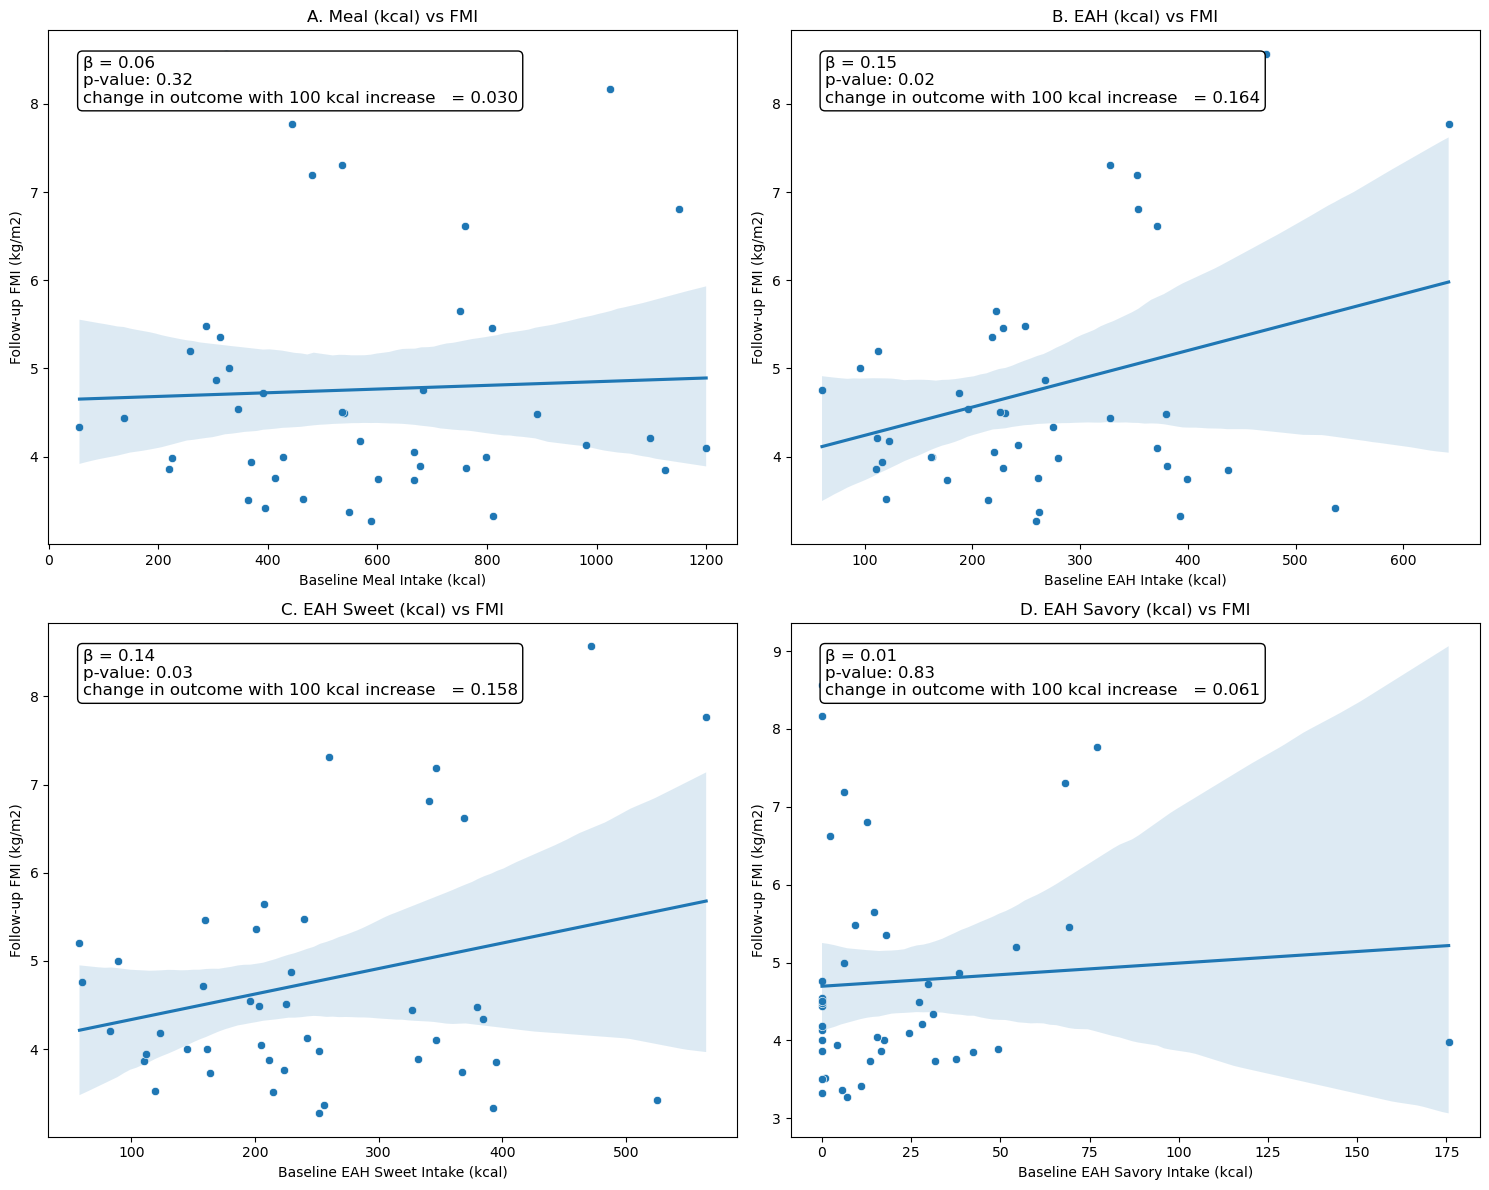

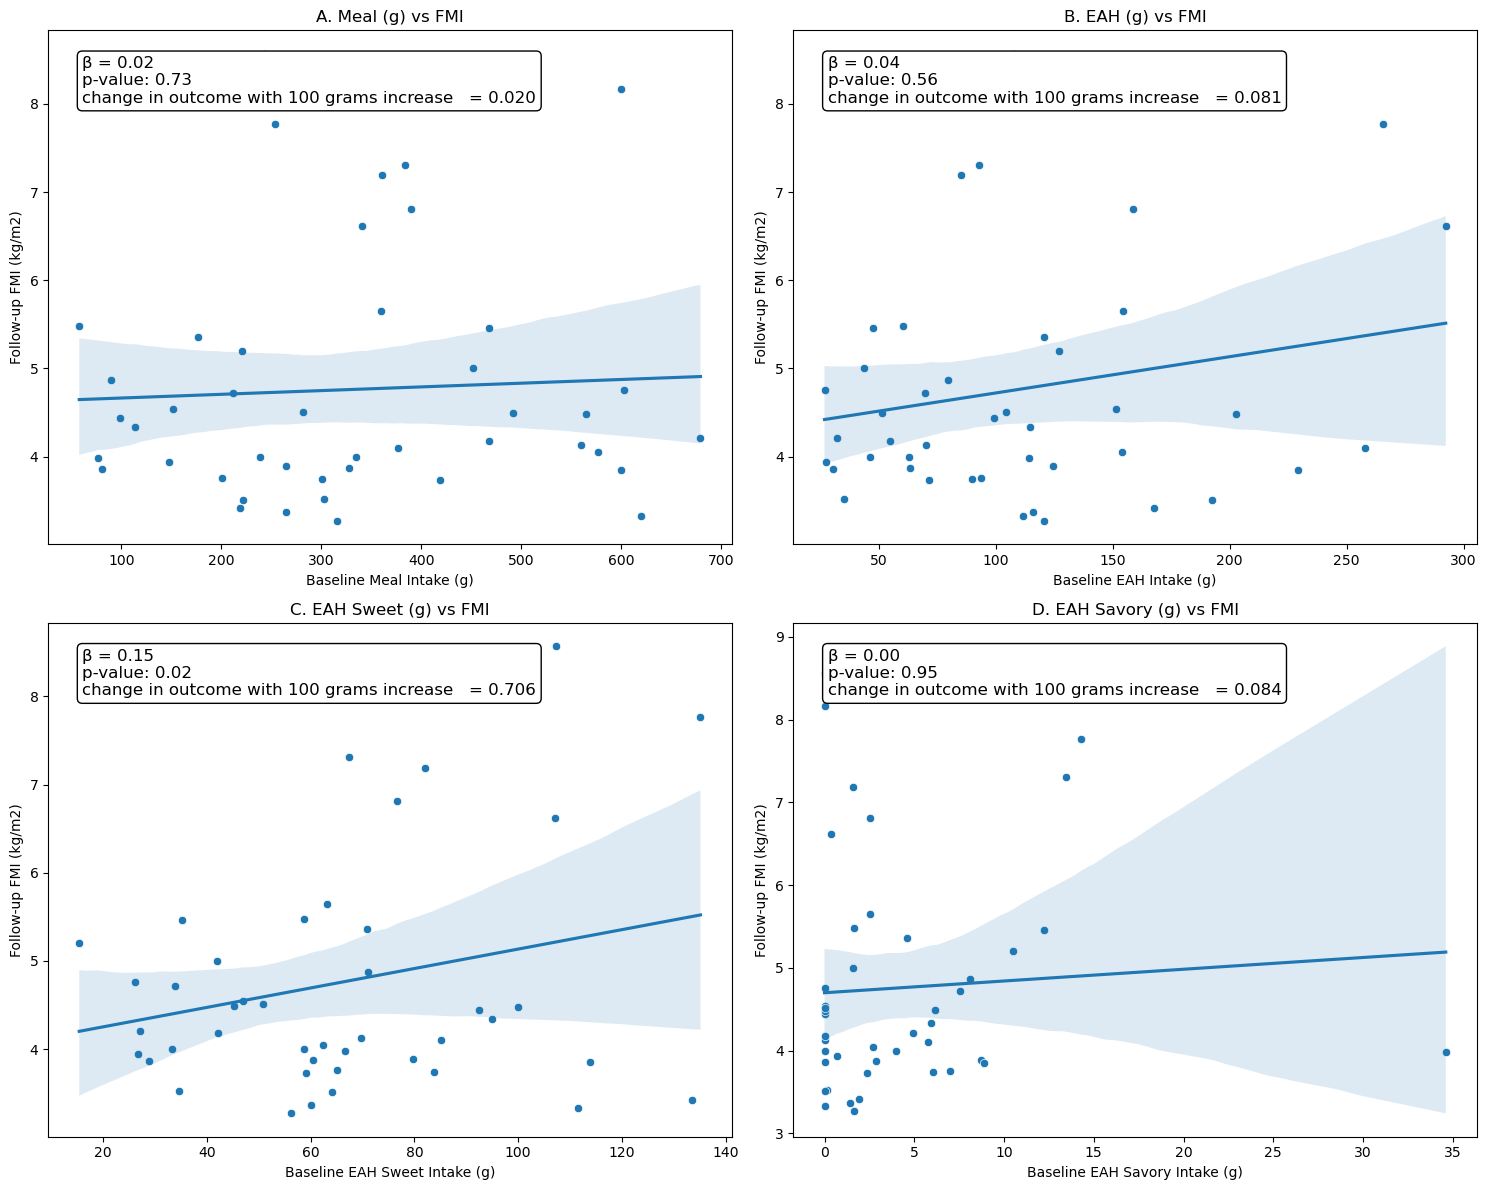

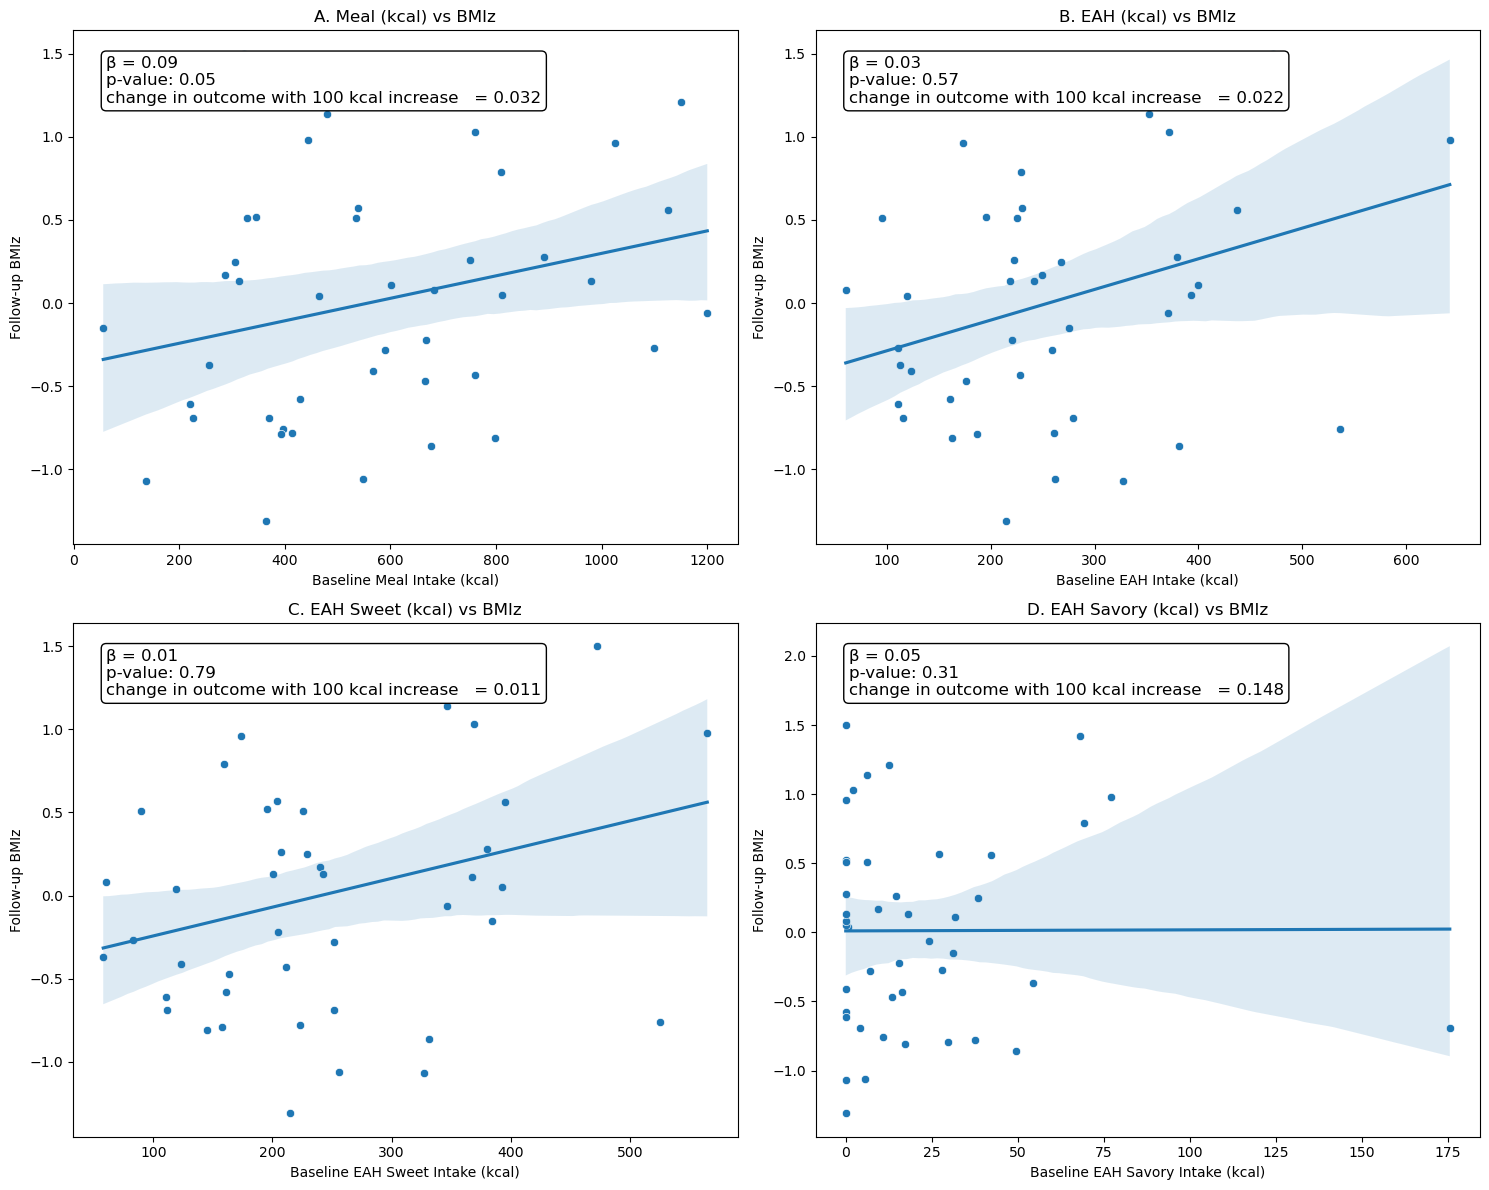

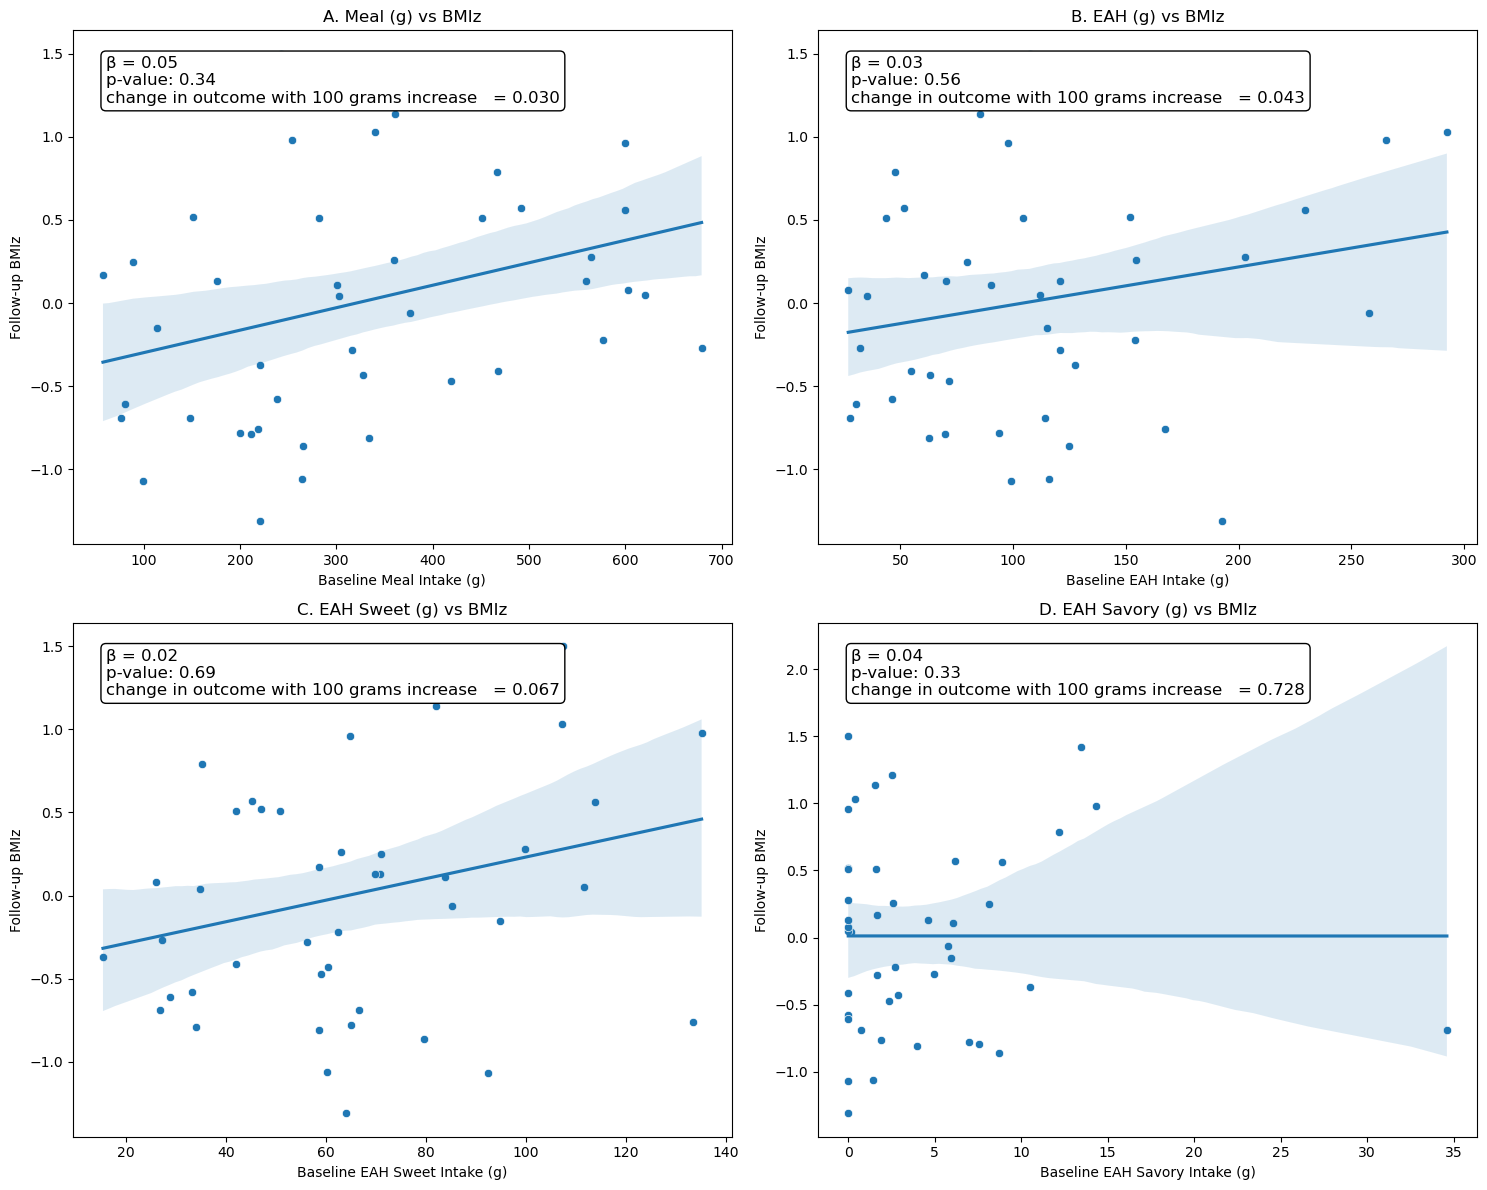

In [79]:
# First Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', df_graph, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up FMI (kg/m2)', 'A. Meal (kcal) vs FMI', coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', df_graph, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up FMI (kg/m2)', 'B. EAH (kcal) vs FMI', coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (kcal) vs FMI', coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (kcal) vs FMI', coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI, 'kcal')
plt.tight_layout()
plt.show()

# Second Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_FMI', df_graph, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up FMI (kg/m2)', 'A. Meal (g) vs FMI', coef_meal_g, pvalue_meal_g, change_meal_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_FMI', df_graph, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up FMI (kg/m2)', 'B. EAH (g) vs FMI', coef_eah_g, pvalue_eah_g, change_eah_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_FMI', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (g) vs FMI', coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_FMI', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (g) vs FMI', coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI, 'grams')
plt.tight_layout()
plt.show()

# Third Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_bmi_z', df_graph, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up BMIz', 'A. Meal (kcal) vs BMIz', coef_meal_kcal_bmiz, pvalue_meal_kcal_bmiz, change_meal_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_bmi_z', df_graph, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up BMIz', 'B. EAH (kcal) vs BMIz', coef_eah_kcal_bmiz, pvalue_eah_kcal_bmiz, change_eah_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_bmi_z', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up BMIz', 'C. EAH Sweet (kcal) vs BMIz', coef_eah_sweet_kcal_bmiz, pvalue_eah_sweet_kcal_bmiz, change_eah_sweet_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_bmi_z', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up BMIz', 'D. EAH Savory (kcal) vs BMIz', coef_eah_sav_kcal_bmiz, pvalue_eah_sav_kcal_bmiz, change_eah_sav_kcal_BMIz, 'kcal')
plt.tight_layout()
plt.show()


# Fourth Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_bmi_z', df_graph, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up BMIz', 'A. Meal (g) vs BMIz', coef_meal_g_bmiz, pvalue_meal_g_bmiz, change_meal_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_bmi_z', df_graph, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up BMIz', 'B. EAH (g) vs BMIz', coef_eah_g_bmiz, pvalue_eah_g_bmiz, change_eah_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_bmi_z', df_graph, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up BMIz', 'C. EAH Sweet (g) vs BMIz', coef_eah_sweet_g_bmiz, pvalue_eah_sweet_g_bmiz, change_eah_sweet_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_bmi_z', df_graph, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up BMIz', 'D. EAH Savory (g) vs BMIz', coef_eah_sav_g_bmiz, pvalue_eah_sav_g_bmiz, change_eah_sav_g_BMIz, 'grams')
plt.tight_layout()
plt.show()


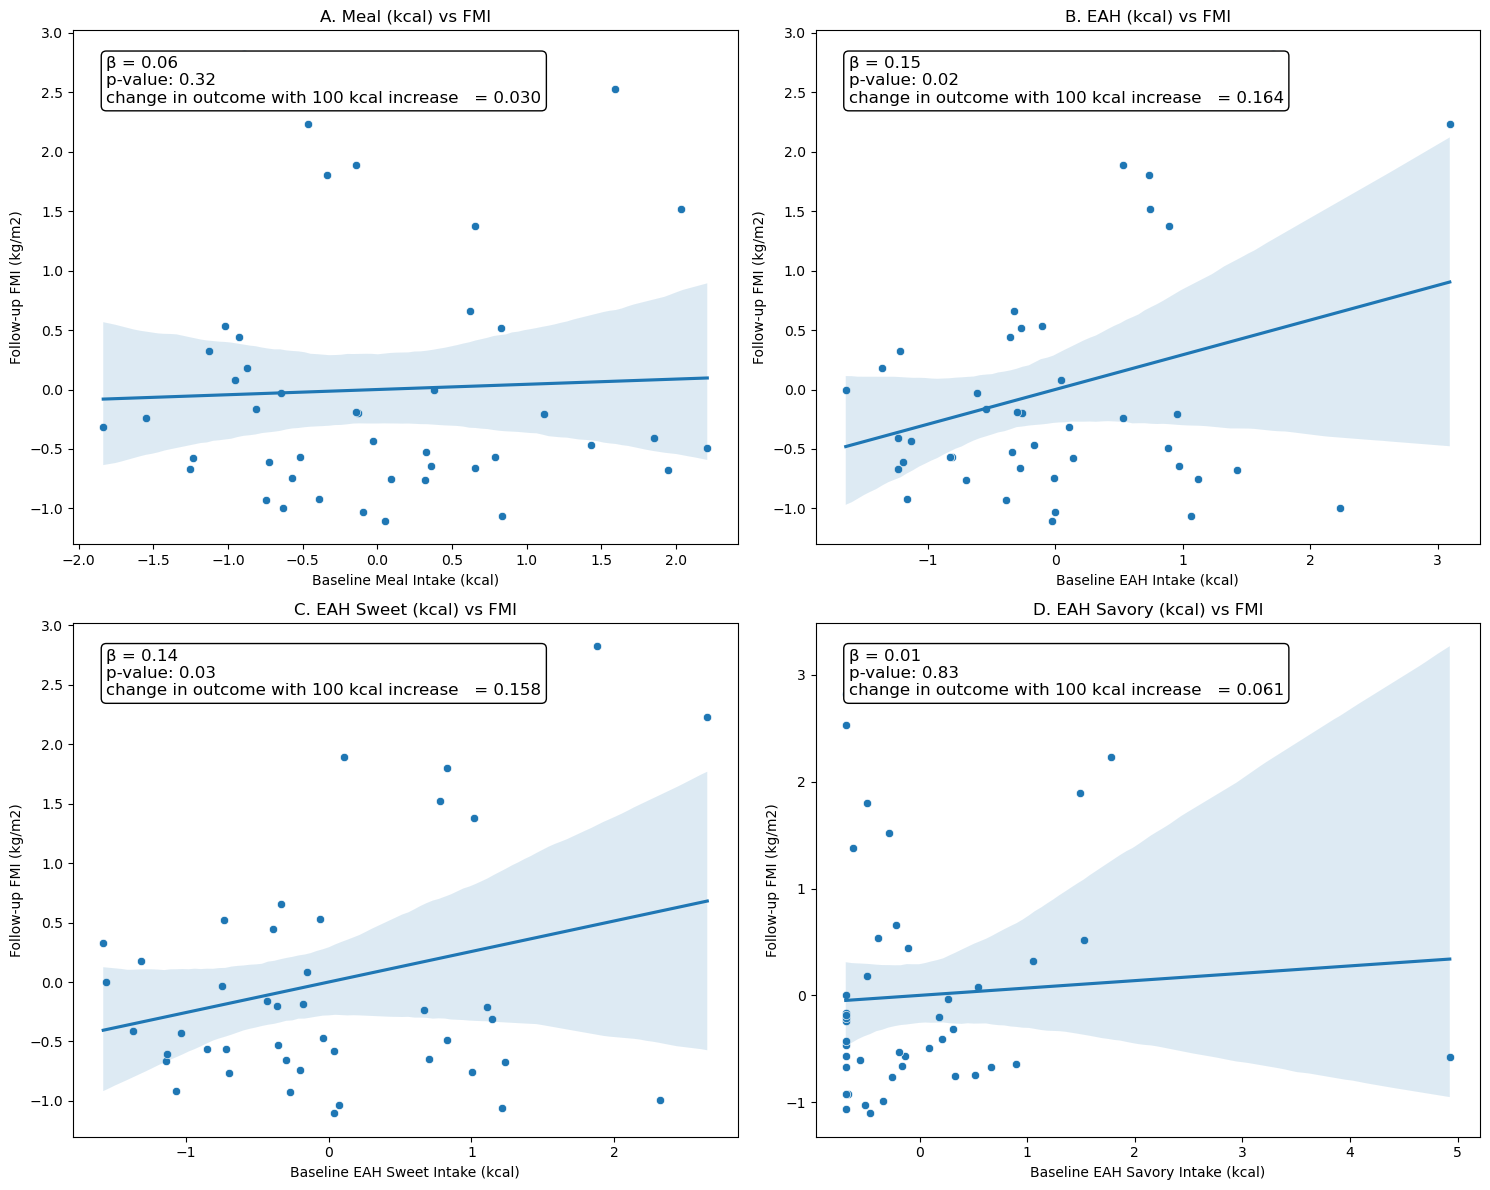

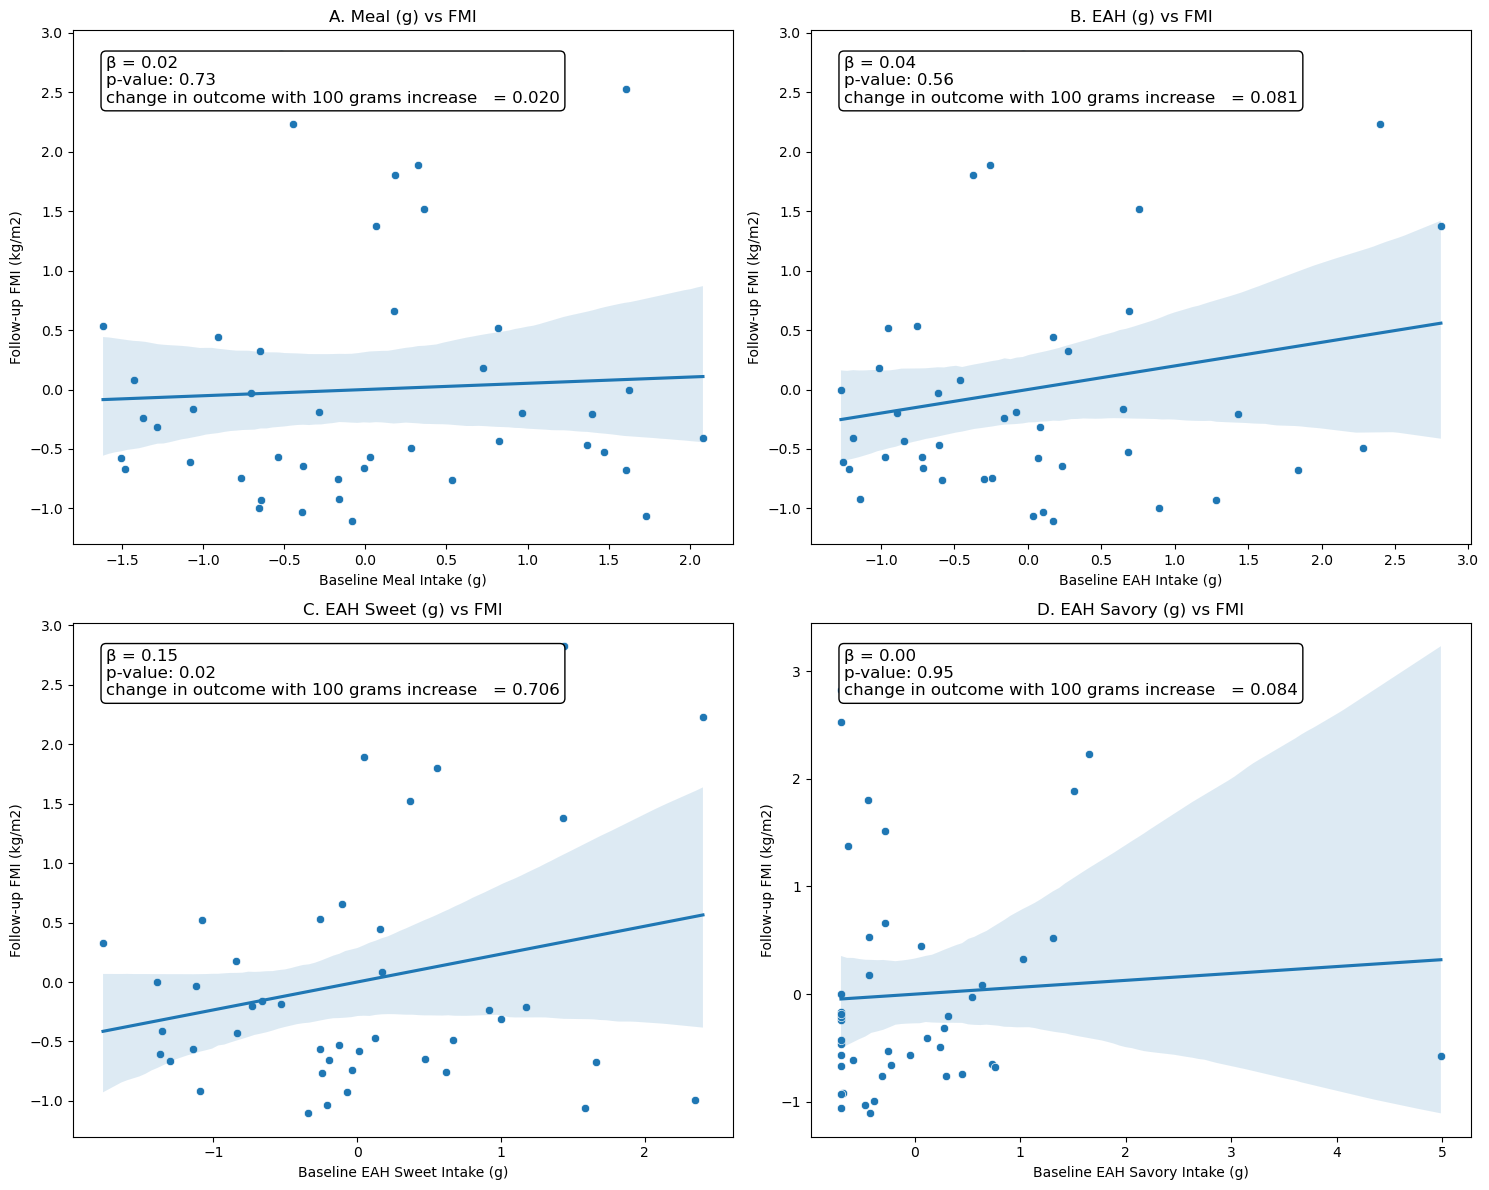

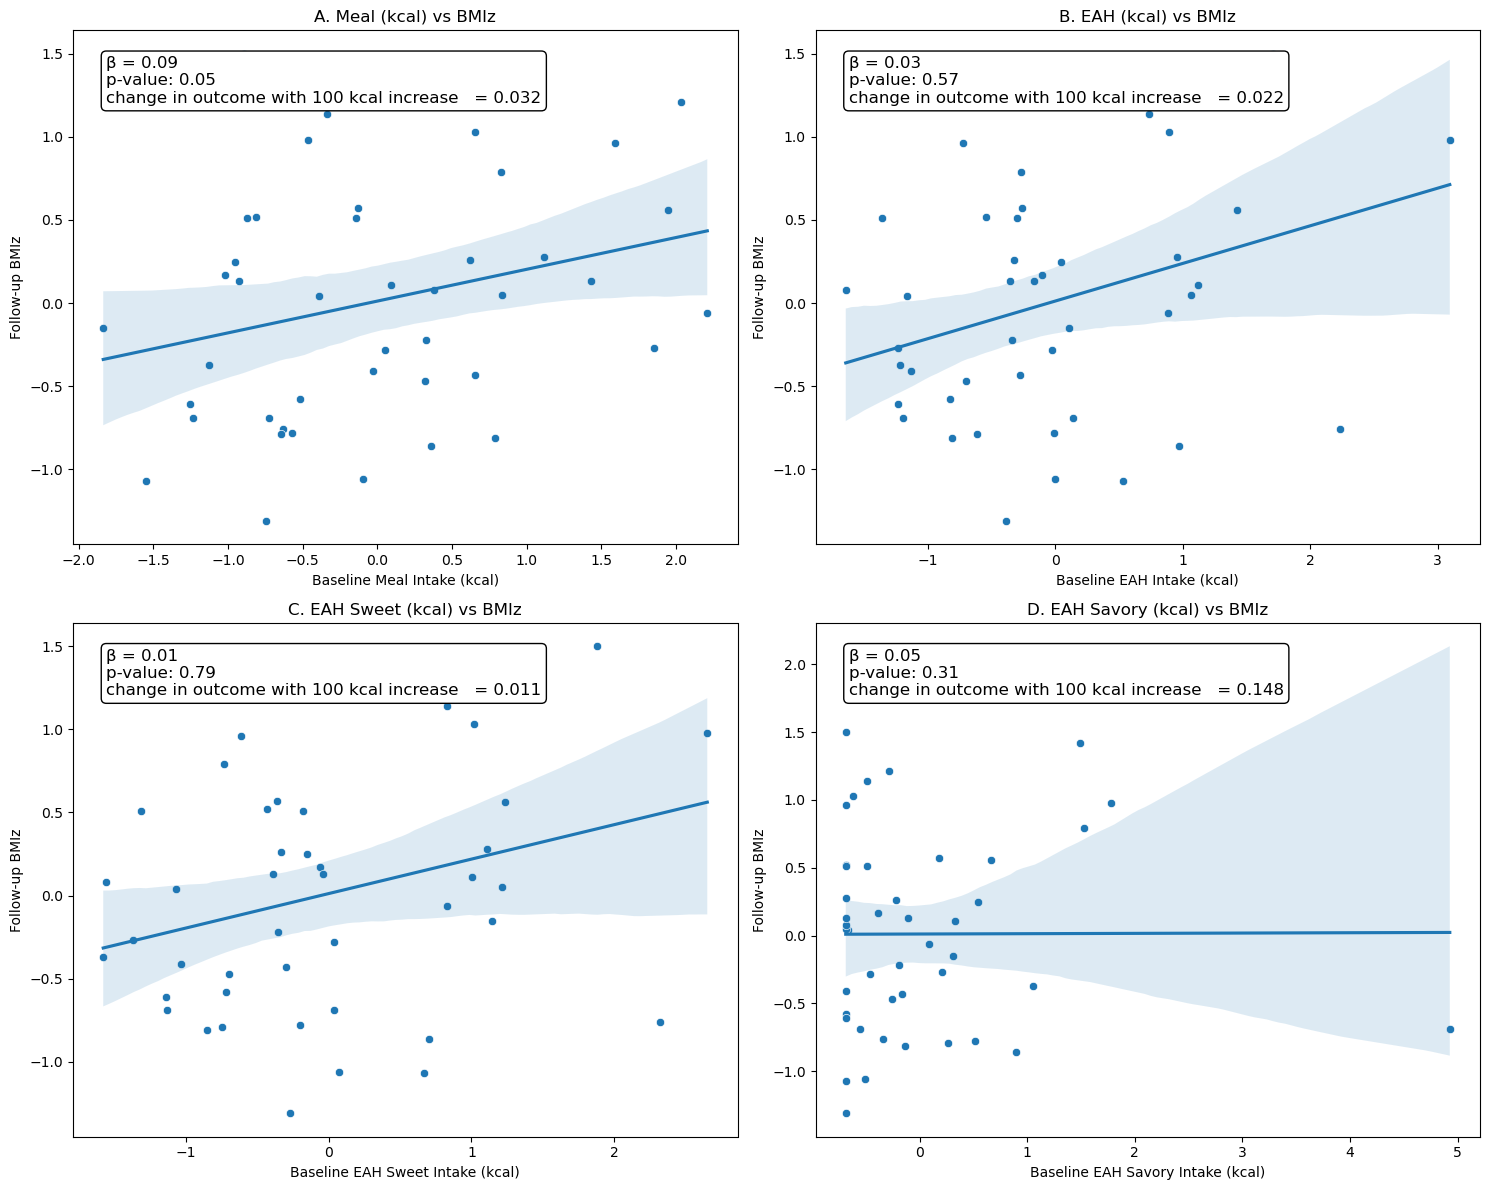

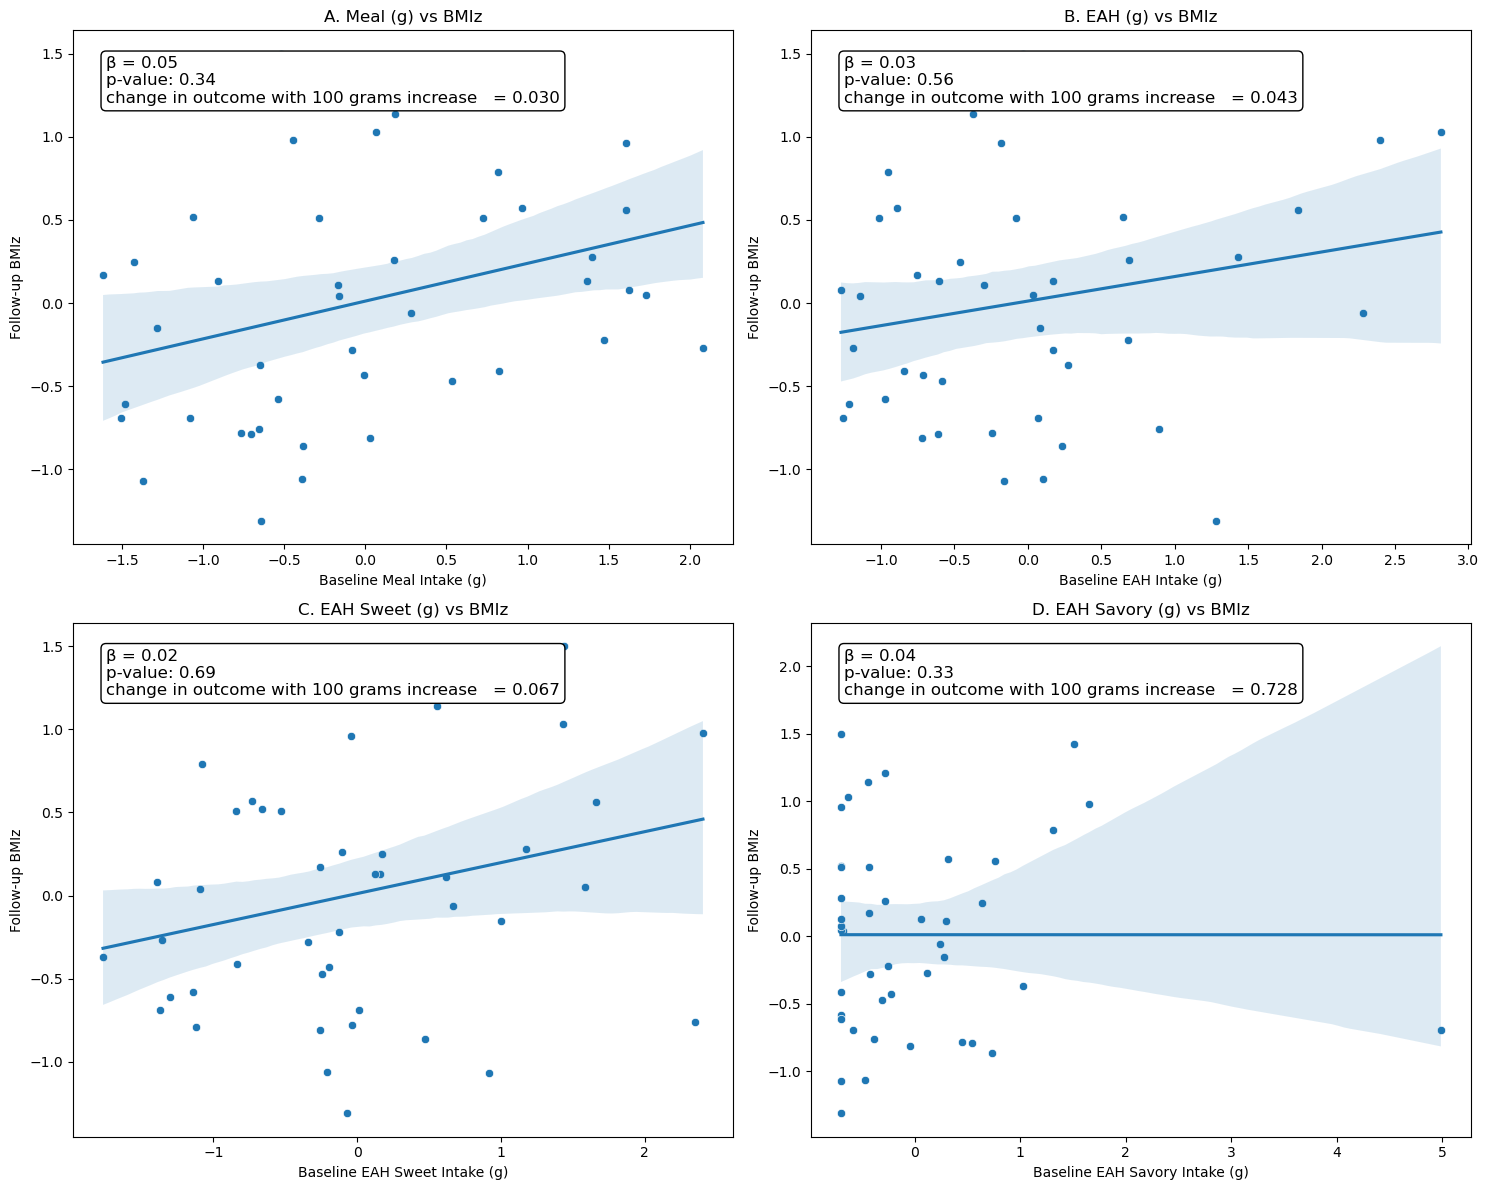

In [80]:
# First Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up FMI (kg/m2)', 'A. Meal (kcal) vs FMI', coef_meal_kcal, pvalue_meal_kcal, change_meal_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up FMI (kg/m2)', 'B. EAH (kcal) vs FMI', coef_eah_kcal, pvalue_eah_kcal, change_eah_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (kcal) vs FMI', coef_eah_sweet_kcal, pvalue_eah_sweet_kcal, change_eah_sweet_kcal_FMI, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (kcal) vs FMI', coef_eah_sav_kcal, pvalue_eah_sav_kcal, change_eah_sav_kcal_FMI, 'kcal')
plt.tight_layout()
plt.show()

# Second Graph: FMI vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_FMI', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up FMI (kg/m2)', 'A. Meal (g) vs FMI', coef_meal_g, pvalue_meal_g, change_meal_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_FMI', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up FMI (kg/m2)', 'B. EAH (g) vs FMI', coef_eah_g, pvalue_eah_g, change_eah_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_FMI', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up FMI (kg/m2)', 'C. EAH Sweet (g) vs FMI', coef_eah_sweet_g, pvalue_eah_sweet_g, change_eah_sweet_g_FMI, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_FMI', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up FMI (kg/m2)', 'D. EAH Savory (g) vs FMI', coef_eah_sav_g, pvalue_eah_sav_g, change_eah_sav_g_FMI, 'grams')
plt.tight_layout()
plt.show()

# Third Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all kcal)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_bmi_z', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (kcal)', 'Follow-up BMIz', 'A. Meal (kcal) vs BMIz', coef_meal_kcal_bmiz, pvalue_meal_kcal_bmiz, change_meal_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_bmi_z', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (kcal)', 'Follow-up BMIz', 'B. EAH (kcal) vs BMIz', coef_eah_kcal_bmiz, pvalue_eah_kcal_bmiz, change_eah_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_bmi_z', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (kcal)', 'Follow-up BMIz', 'C. EAH Sweet (kcal) vs BMIz', coef_eah_sweet_kcal_bmiz, pvalue_eah_sweet_kcal_bmiz, change_eah_sweet_kcal_BMIz, 'kcal')
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_bmi_z', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (kcal)', 'Follow-up BMIz', 'D. EAH Savory (kcal) vs BMIz', coef_eah_sav_kcal_bmiz, pvalue_eah_sav_kcal_bmiz, change_eah_sav_kcal_BMIz, 'kcal')
plt.tight_layout()
plt.show()


# Fourth Graph: BMIz vs. Meal, EAH, EAH Sweet, EAH Savory (all grams)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plot_with_regression_and_pvalue('v1_meal_g', 'v7_bmi_z', df_linear_reg, axes[0, 0], 'Baseline Meal Intake (g)', 'Follow-up BMIz', 'A. Meal (g) vs BMIz', coef_meal_g_bmiz, pvalue_meal_g_bmiz, change_meal_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_g', 'v7_bmi_z', df_linear_reg, axes[0, 1], 'Baseline EAH Intake (g)', 'Follow-up BMIz', 'B. EAH (g) vs BMIz', coef_eah_g_bmiz, pvalue_eah_g_bmiz, change_eah_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sweet_g', 'v7_bmi_z', df_linear_reg, axes[1, 0], 'Baseline EAH Sweet Intake (g)', 'Follow-up BMIz', 'C. EAH Sweet (g) vs BMIz', coef_eah_sweet_g_bmiz, pvalue_eah_sweet_g_bmiz, change_eah_sweet_g_BMIz, 'grams')
plot_with_regression_and_pvalue('v1_eah_sav_g', 'v7_bmi_z', df_linear_reg, axes[1, 1], 'Baseline EAH Savory Intake (g)', 'Follow-up BMIz', 'D. EAH Savory (g) vs BMIz', coef_eah_sav_g_bmiz, pvalue_eah_sav_g_bmiz, change_eah_sav_g_BMIz, 'grams')
plt.tight_layout()
plt.show()



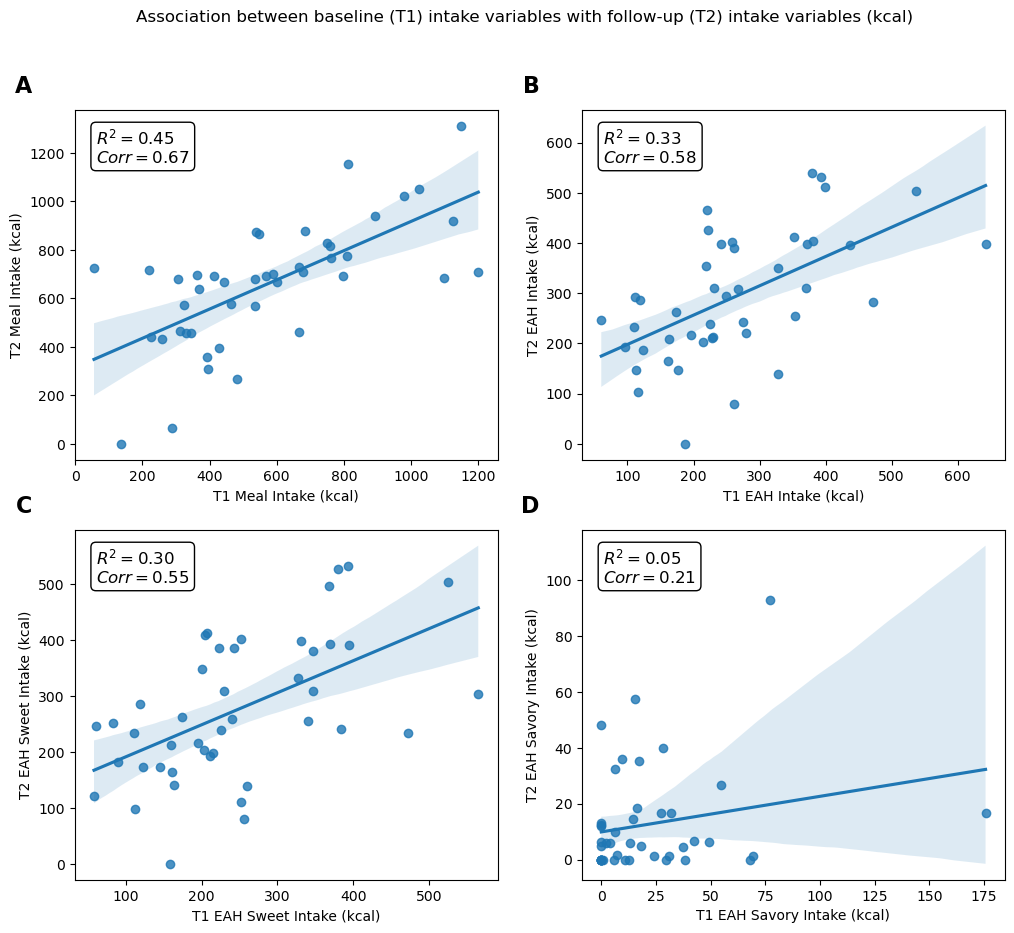

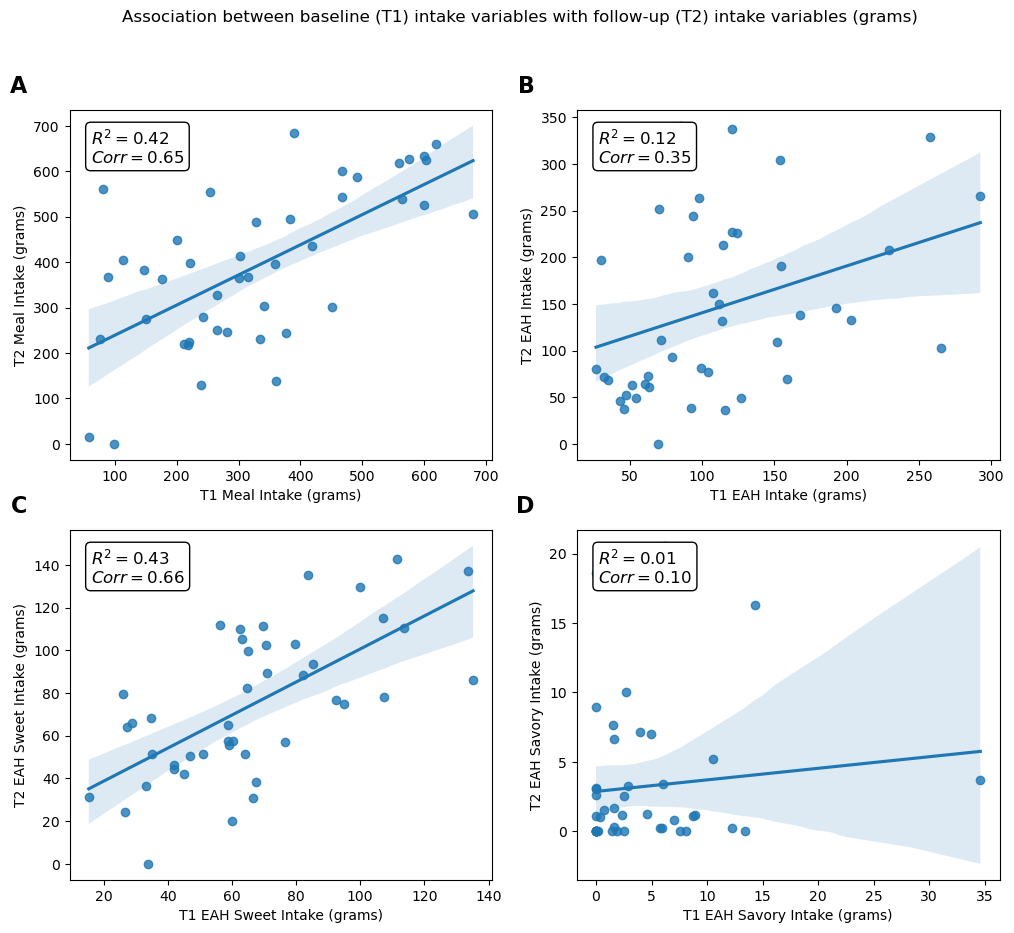

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Function to create scatter plots with R2 and correlation coefficient
def scatter_plot_with_stats(ax, x, y, x_label, y_label):
    sns.regplot(x=x, y=y, ax=ax, scatter_kws={'color': '#1f77b4'}, line_kws={'color': '#1f77b4'})
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Fit linear model
    model = LinearRegression().fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1))
    y_pred = model.predict(x.values.reshape(-1, 1))
    
    # Calculate R2 and correlation coefficient
    r2 = r2_score(y, y_pred)
    corr_coeff = x.corr(y)
    
    # Add text box with R2 and correlation coefficient
    textstr = f'$R^2 = {r2:.2f}$\n$Corr = {corr_coeff:.2f}$'
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

# Create the 2x2 subplot for the first graph
fig1, axs1 = plt.subplots(2, 2, figsize=(12, 10))
fig1.suptitle('Association between baseline (T1) intake variables with follow-up (T2) intake variables (kcal)')

variables_kcal = [
    ('v1_meal_kcal', 'v7_meal_kcal', 'T1 Meal Intake (kcal)', 'T2 Meal Intake (kcal)'),
    ('v1_eah_kcal', 'v7_eah_kcal', 'T1 EAH Intake (kcal)', 'T2 EAH Intake (kcal)'),
    ('v1_eah_sweet_kcal', 'v7_eah_sweet_kcal', 'T1 EAH Sweet Intake (kcal)', 'T2 EAH Sweet Intake (kcal)'),
    ('v1_eah_sav_kcal', 'v7_eah_sav_kcal', 'T1 EAH Savory Intake (kcal)', 'T2 EAH Savory Intake (kcal)')
]

# Label for the subplots
labels = ['A', 'B', 'C', 'D']

for ax, (x_var, y_var, x_label, y_label), label in zip(axs1.ravel(), variables_kcal, labels):
    scatter_plot_with_stats(ax, df_graph[x_var], df_graph[y_var], x_label, y_label)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Create the 2x2 subplot for the second graph
fig2, axs2 = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Association between baseline (T1) intake variables with follow-up (T2) intake variables (grams)')

variables_g = [
    ('v1_meal_g', 'v7_meal_g', 'T1 Meal Intake (grams)', 'T2 Meal Intake (grams)'),
    ('v1_eah_g', 'v7_eah_g', 'T1 EAH Intake (grams)', 'T2 EAH Intake (grams)'),
    ('v1_eah_sweet_g', 'v7_eah_sweet_g', 'T1 EAH Sweet Intake (grams)', 'T2 EAH Sweet Intake (grams)'),
    ('v1_eah_sav_g', 'v7_eah_sav_g', 'T1 EAH Savory Intake (grams)', 'T2 EAH Savory Intake (grams)')
]

# Label for the subplots
labels = ['A', 'B', 'C', 'D']

for ax, (x_var, y_var, x_label, y_label), label in zip(axs2.ravel(), variables_g, labels):
    scatter_plot_with_stats(ax, df_graph[x_var], df_graph[y_var], x_label, y_label)
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Show the plots
plt.show()

# partial reg plots

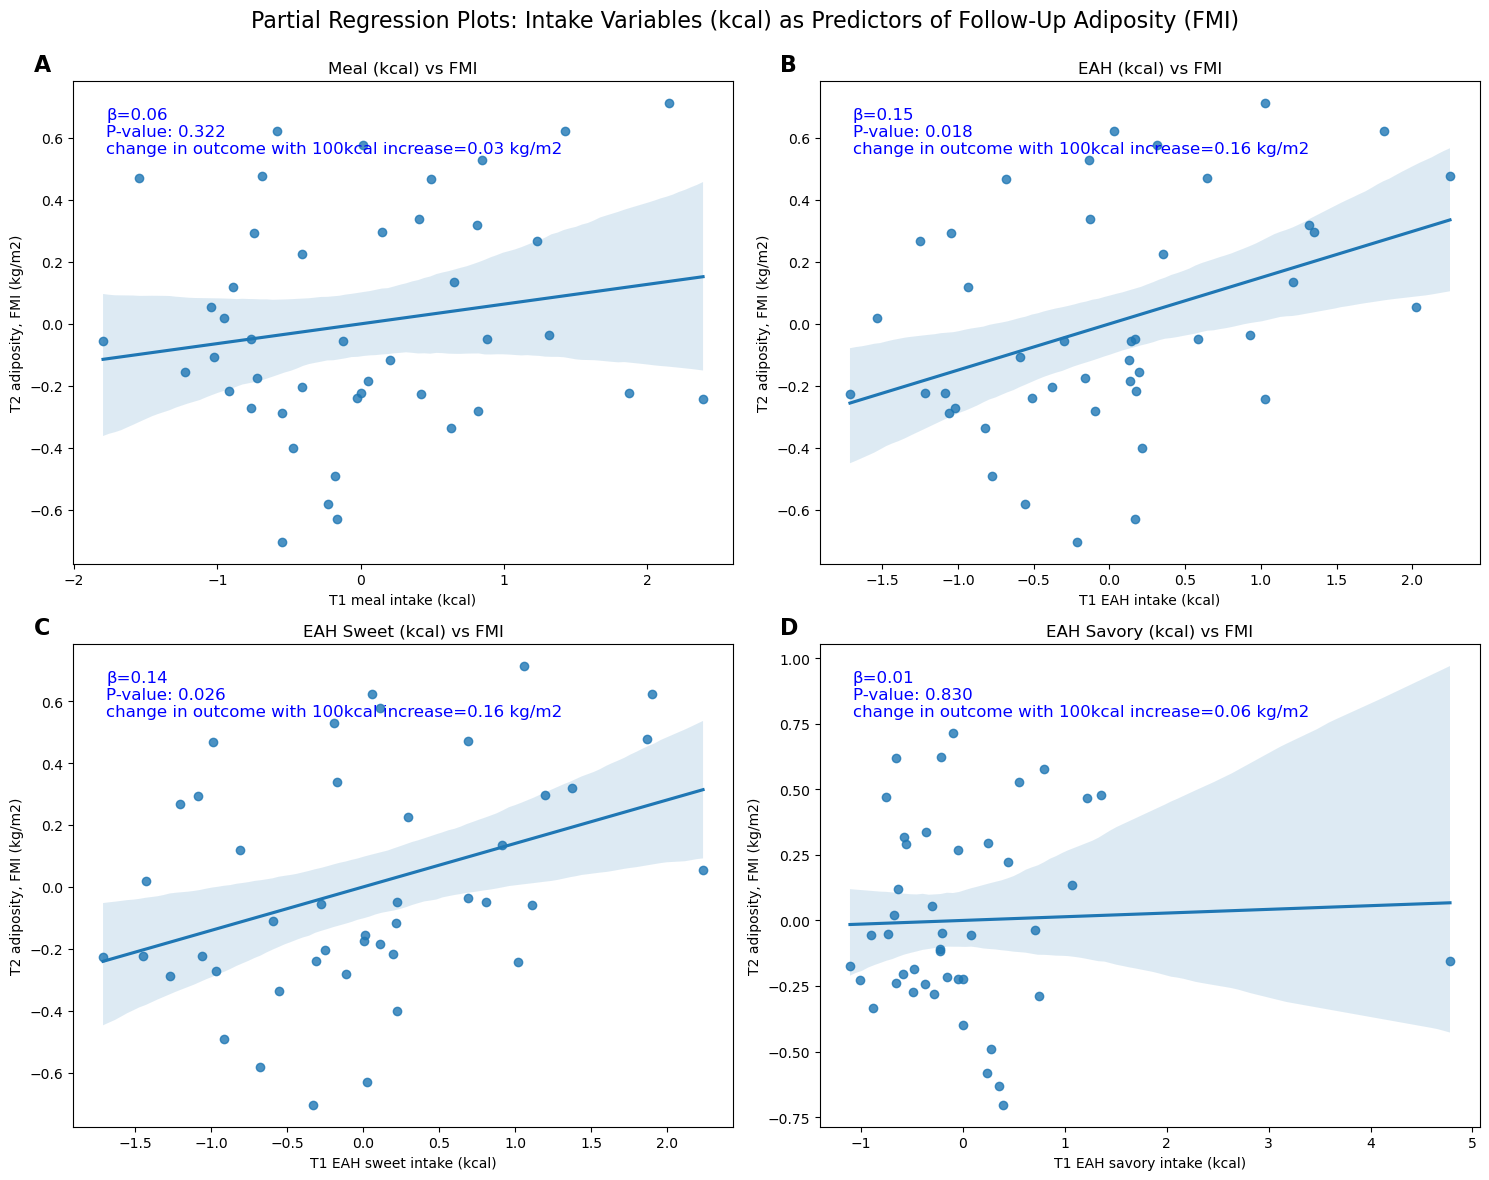

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (kcal) vs FMI
X_meal = df_linear_reg[['v1_FMI', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_FMI']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_FMI on all covariates
mod_FMI = sm.OLS(y_meal, X_meal_const).fit()
resid_FMI = mod_FMI.resid

# Regressing v1_meal_kcal on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_kcal'], X_meal_const).fit()
resid_meal_kcal = mod_meal.resid

# EAH (kcal) vs FMI
mod_eah = sm.OLS(df_linear_reg['v1_eah_kcal'], X_meal_const).fit()
resid_eah_kcal = mod_eah.resid

# EAH sweet (kcal) vs FMI
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_kcal'], X_meal_const).fit()
resid_eah_sweet_kcal = mod_eah_sweet.resid

# EAH savory (kcal) vs FMI
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_kcal'], X_meal_const).fit()
resid_eah_sav_kcal = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (kcal) vs FMI residuals
sns.regplot(x=resid_meal_kcal, y=resid_FMI, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (kcal)")
axes[0, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 0].set_title("Meal (kcal) vs FMI")
axes[0, 0].annotate(f"β={mod_mealkcalFMI.params['v1_meal_kcal']:.2f}\nP-value: {mod_mealkcalFMI.pvalues['v1_meal_kcal']:.3f}\nchange in outcome with 100kcal increase={change_meal_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (kcal) vs FMI residuals
sns.regplot(x=resid_eah_kcal, y=resid_FMI, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (kcal)")
axes[0, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 1].set_title("EAH (kcal) vs FMI")
axes[0, 1].annotate(f"β={mod_EAHkcalFMI.params['v1_eah_kcal']:.2f}\nP-value: {mod_EAHkcalFMI.pvalues['v1_eah_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (kcal) vs FMI residuals
sns.regplot(x=resid_eah_sweet_kcal, y=resid_FMI, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (kcal)")
axes[1, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 0].set_title("EAH Sweet (kcal) vs FMI")
axes[1, 0].annotate(f"β={mod_EAHsweetkcalFMI.params['v1_eah_sweet_kcal']:.2f}\nP-value: {mod_EAHsweetkcalFMI.pvalues['v1_eah_sweet_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_sweet_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (kcal) vs FMI residuals
sns.regplot(x=resid_eah_sav_kcal, y=resid_FMI, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (kcal)")
axes[1, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 1].set_title("EAH Savory (kcal) vs FMI")
axes[1, 1].annotate(f"β={mod_EAHsavkcalFMI.params['v1_eah_sav_kcal']:.2f}\nP-value: {mod_EAHsavkcalFMI.pvalues['v1_eah_sav_kcal']:.3f}\nchange in outcome with 100kcal increase={change_eah_sav_kcal_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (kcal) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.show()

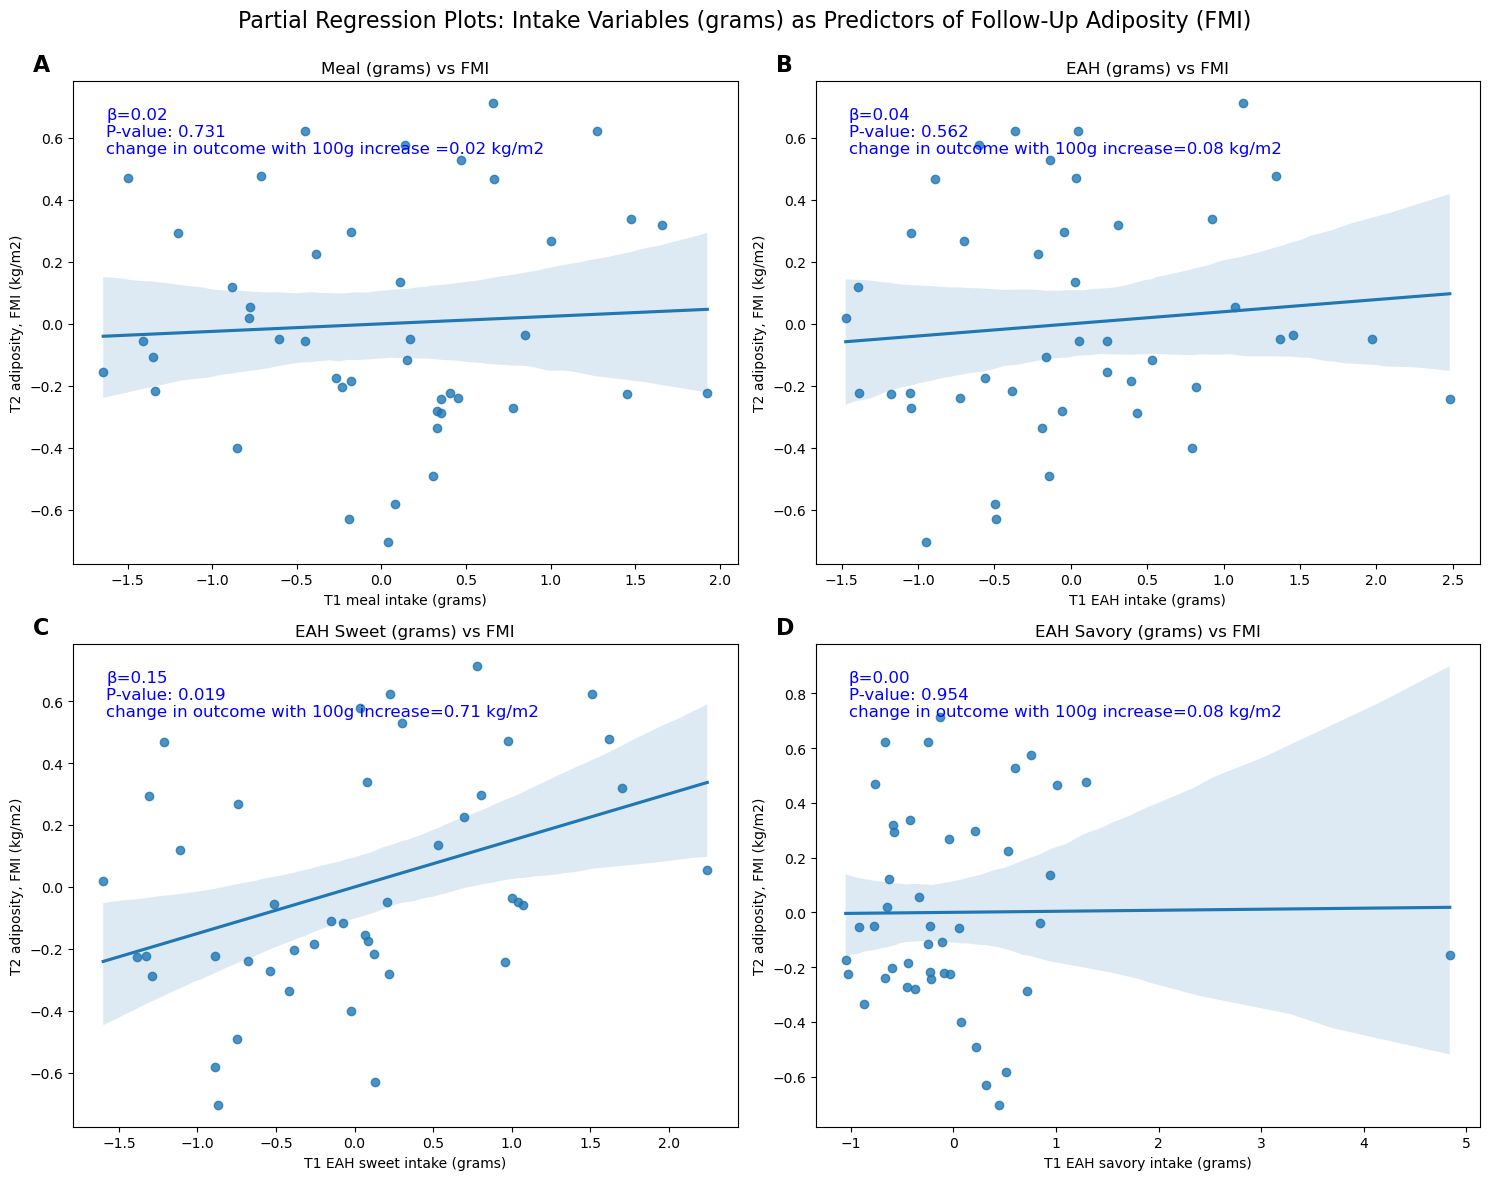

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (grams) vs FMI
X_meal = df_linear_reg[['v1_FMI', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_FMI']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_FMI on all covariates
mod_FMI = sm.OLS(y_meal, X_meal_const).fit()
resid_FMI = mod_FMI.resid

# Regressing v1_meal_grams on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_g'], X_meal_const).fit()
resid_meal_grams = mod_meal.resid

# EAH (grams) vs FMI
mod_eah = sm.OLS(df_linear_reg['v1_eah_g'], X_meal_const).fit()
resid_eah_grams = mod_eah.resid

# EAH sweet (grams) vs FMI
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_g'], X_meal_const).fit()
resid_eah_sweet_grams = mod_eah_sweet.resid

# EAH savory (grams) vs FMI
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_g'], X_meal_const).fit()
resid_eah_sav_grams = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (grams) vs FMI residuals
sns.regplot(x=resid_meal_grams, y=resid_FMI, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (grams)")
axes[0, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 0].set_title("Meal (grams) vs FMI")
axes[0, 0].annotate(f"β={mod_mealgFMI.params['v1_meal_g']:.2f}\nP-value: {mod_mealgFMI.pvalues['v1_meal_g']:.3f}\nchange in outcome with 100g increase ={change_meal_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (grams) vs FMI residuals
sns.regplot(x=resid_eah_grams, y=resid_FMI, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (grams)")
axes[0, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[0, 1].set_title("EAH (grams) vs FMI")
axes[0, 1].annotate(f"β={mod_EAHgFMI.params['v1_eah_g']:.2f}\nP-value: {mod_EAHgFMI.pvalues['v1_eah_g']:.3f}\nchange in outcome with 100g increase={change_eah_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (grams) vs FMI residuals
sns.regplot(x=resid_eah_sweet_grams, y=resid_FMI, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (grams)")
axes[1, 0].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 0].set_title("EAH Sweet (grams) vs FMI")
axes[1, 0].annotate(f"β={mod_EAHsweetgFMI.params['v1_eah_sweet_g']:.2f}\nP-value: {mod_EAHsweetgFMI.pvalues['v1_eah_sweet_g']:.3f}\nchange in outcome with 100g increase={change_eah_sweet_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (grams) vs FMI residuals
sns.regplot(x=resid_eah_sav_grams, y=resid_FMI, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (grams)")
axes[1, 1].set_ylabel("T2 adiposity, FMI (kg/m2)")
axes[1, 1].set_title("EAH Savory (grams) vs FMI")
axes[1, 1].annotate(f"β={mod_EAHsavgFMI.params['v1_eah_sav_g']:.2f}\nP-value: {mod_EAHsavgFMI.pvalues['v1_eah_sav_g']:.3f}\nchange in outcome with 100g increase={change_eah_sav_g_FMI:.2f} kg/m2", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (grams) as Predictors of Follow-Up Adiposity (FMI)", fontsize=16)
plt.show()

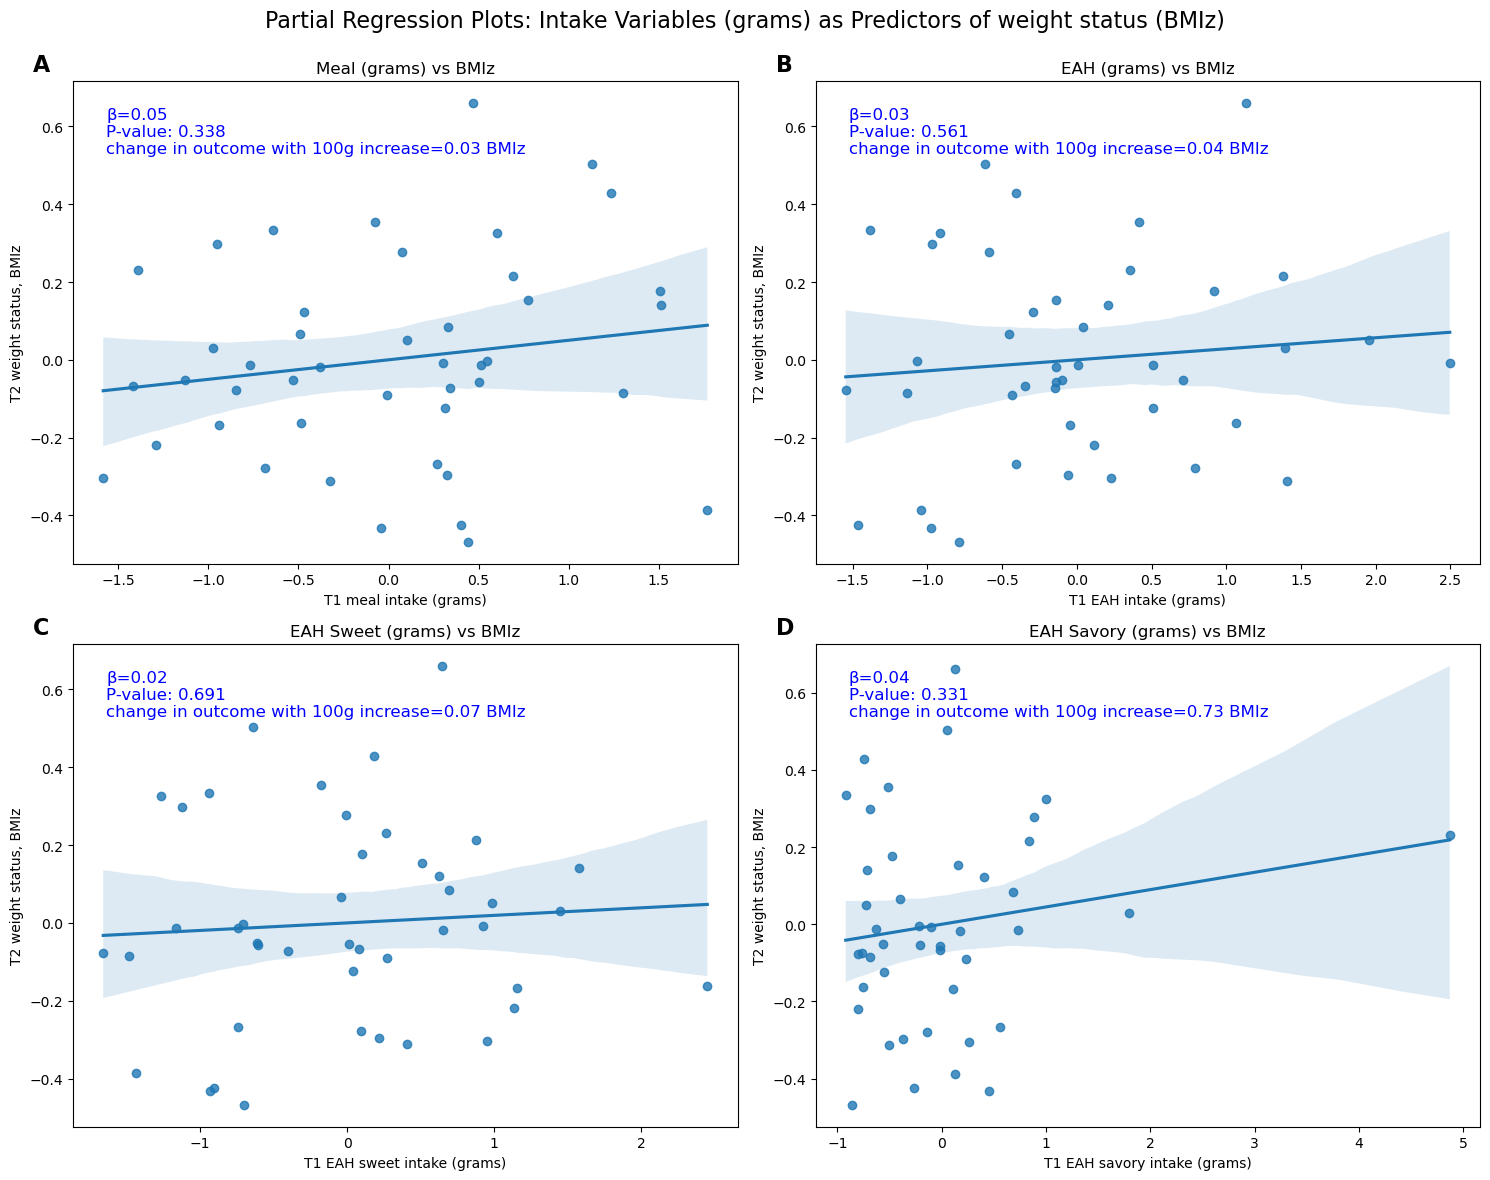

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (grams) vs BMIz
X_meal = df_linear_reg[['bmi_z', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_bmi_z']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_BMIz on all covariates
mod_BMIz = sm.OLS(y_meal, X_meal_const).fit()
resid_BMIz = mod_BMIz.resid

# Regressing v1_meal_grams on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_g'], X_meal_const).fit()
resid_meal_grams = mod_meal.resid

# EAH (grams) vs BMIz
mod_eah = sm.OLS(df_linear_reg['v1_eah_g'], X_meal_const).fit()
resid_eah_grams = mod_eah.resid

# EAH sweet (grams) vs BMIz
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_g'], X_meal_const).fit()
resid_eah_sweet_grams = mod_eah_sweet.resid

# EAH savory (grams) vs BMIz
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_g'], X_meal_const).fit()
resid_eah_sav_grams = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (grams) vs BMIz residuals
sns.regplot(x=resid_meal_grams, y=resid_BMIz, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (grams)")
axes[0, 0].set_ylabel("T2 weight status, BMIz")
axes[0, 0].set_title("Meal (grams) vs BMIz")
axes[0, 0].annotate(f"β={mod_mealgBMIz.params['v1_meal_g']:.2f}\nP-value: {mod_mealgBMIz.pvalues['v1_meal_g']:.3f}\nchange in outcome with 100g increase={change_meal_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (grams) vs BMIz residuals
sns.regplot(x=resid_eah_grams, y=resid_BMIz, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (grams)")
axes[0, 1].set_ylabel("T2 weight status, BMIz")
axes[0, 1].set_title("EAH (grams) vs BMIz")
axes[0, 1].annotate(f"β={mod_EAHgBMIz.params['v1_eah_g']:.2f}\nP-value: {mod_EAHgBMIz.pvalues['v1_eah_g']:.3f}\nchange in outcome with 100g increase={change_eah_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (grams) vs BMIz residuals
sns.regplot(x=resid_eah_sweet_grams, y=resid_BMIz, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (grams)")
axes[1, 0].set_ylabel("T2 weight status, BMIz")
axes[1, 0].set_title("EAH Sweet (grams) vs BMIz")
axes[1, 0].annotate(f"β={mod_EAHsweetgBMIz.params['v1_eah_sweet_g']:.2f}\nP-value: {mod_EAHsweetgBMIz.pvalues['v1_eah_sweet_g']:.3f}\nchange in outcome with 100g increase={change_eah_sweet_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (grams) vs BMIz residuals
sns.regplot(x=resid_eah_sav_grams, y=resid_BMIz, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (grams)")
axes[1, 1].set_ylabel("T2 weight status, BMIz")
axes[1, 1].set_title("EAH Savory (grams) vs BMIz")
axes[1, 1].annotate(f"β={mod_EAHsavgBMIz.params['v1_eah_sav_g']:.2f}\nP-value: {mod_EAHsavgBMIz.pvalues['v1_eah_sav_g']:.3f}\nchange in outcome with 100g increase={change_eah_sav_g_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (grams) as Predictors of weight status (BMIz)", fontsize=16)
plt.show()


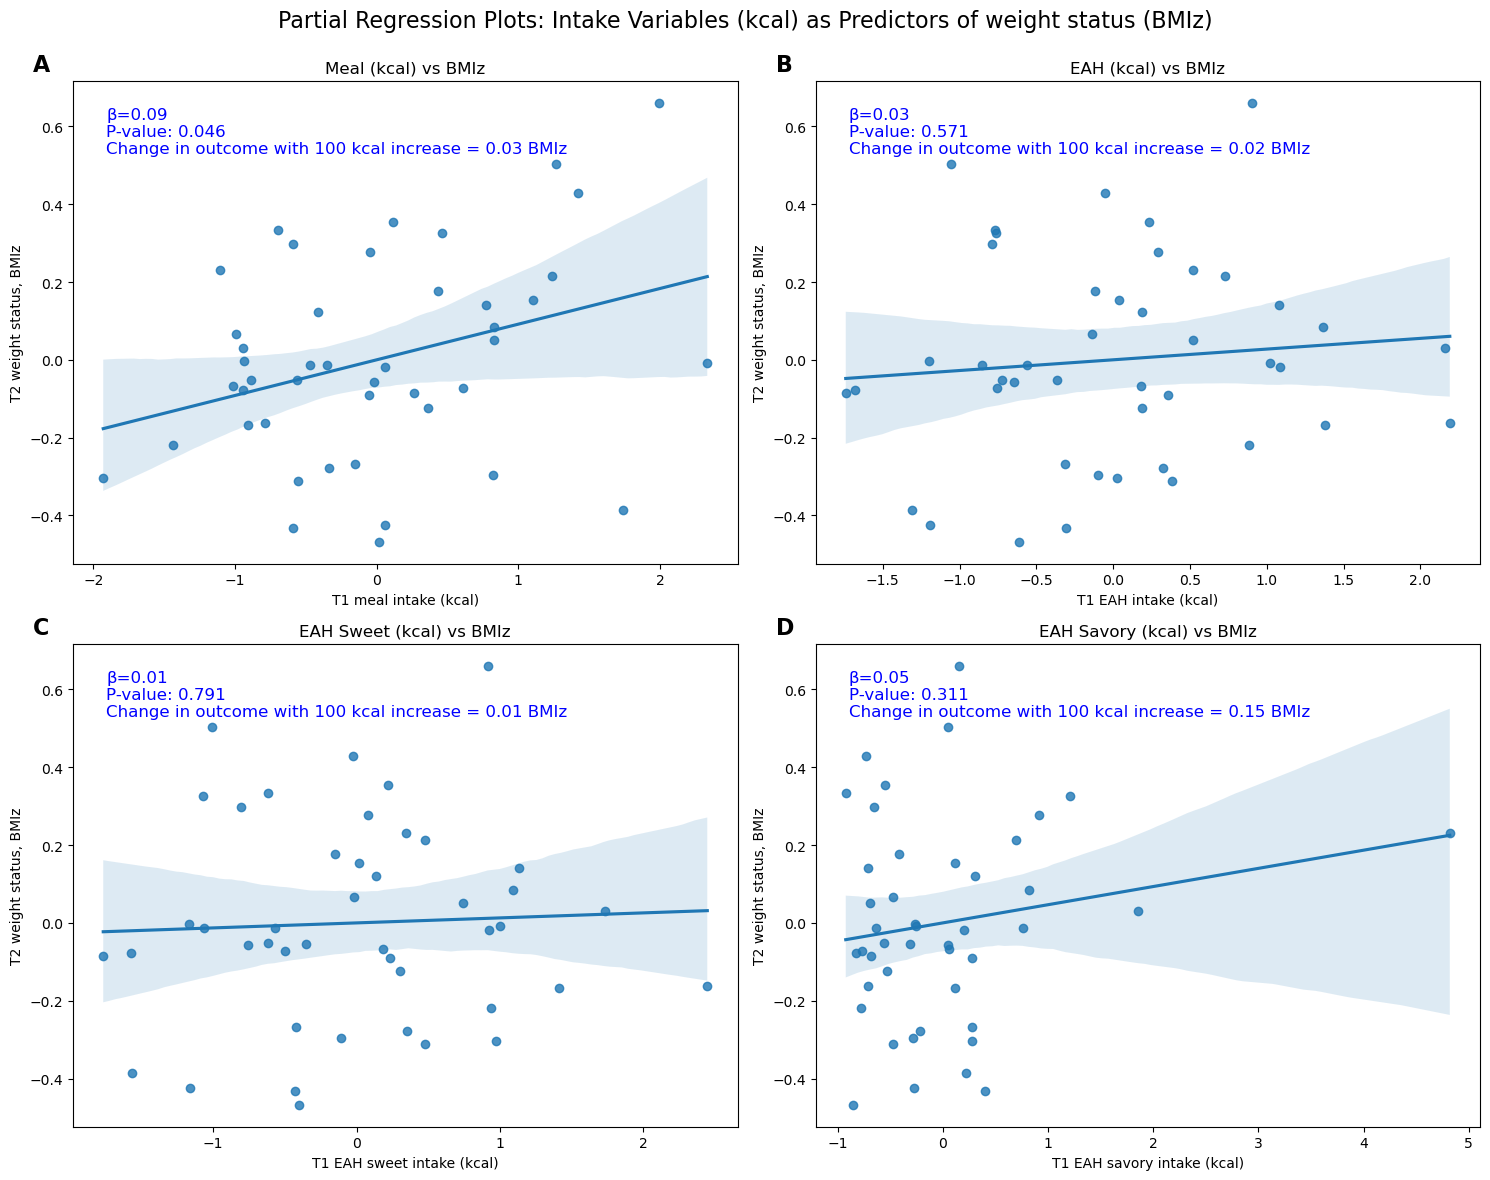

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Create a model for each independent variable and calculate residuals

# Meal (kcal) vs BMIz
X_meal = df_linear_reg[['bmi_z', 'sex','risk_status_mom','income','parent_ed','v7_p_pds_imputed_2', 'v7_p_pds_imputed_3', 'age_diff']]
y_meal = df_linear_reg['v7_bmi_z']
X_meal_const = sm.add_constant(X_meal)

# Regressing v7_BMIz on all covariates
mod_BMIz = sm.OLS(y_meal, X_meal_const).fit()
resid_BMIz = mod_BMIz.resid

# Regressing v1_meal_kcal on all covariates
mod_meal = sm.OLS(df_linear_reg['v1_meal_kcal'], X_meal_const).fit()
resid_meal_kcal = mod_meal.resid

# EAH (kcal) vs BMIz
mod_eah = sm.OLS(df_linear_reg['v1_eah_kcal'], X_meal_const).fit()
resid_eah_kcal = mod_eah.resid

# EAH sweet (kcal) vs BMIz
mod_eah_sweet = sm.OLS(df_linear_reg['v1_eah_sweet_kcal'], X_meal_const).fit()
resid_eah_sweet_kcal = mod_eah_sweet.resid

# EAH savory (kcal) vs BMIz
mod_eah_sav = sm.OLS(df_linear_reg['v1_eah_sav_kcal'], X_meal_const).fit()
resid_eah_sav_kcal = mod_eah_sav.resid

# Plotting the residuals
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for Meal (kcal) vs BMIz residuals
sns.regplot(x=resid_meal_kcal, y=resid_BMIz, ax=axes[0, 0])
axes[0, 0].set_xlabel("T1 meal intake (kcal)")
axes[0, 0].set_ylabel("T2 weight status, BMIz")
axes[0, 0].set_title("Meal (kcal) vs BMIz")
axes[0, 0].annotate(f"β={mod_mealkcalBMIz.params['v1_meal_kcal']:.2f}\nP-value: {mod_mealkcalBMIz.pvalues['v1_meal_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_meal_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH total (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_kcal, y=resid_BMIz, ax=axes[0, 1])
axes[0, 1].set_xlabel("T1 EAH intake (kcal)")
axes[0, 1].set_ylabel("T2 weight status, BMIz")
axes[0, 1].set_title("EAH (kcal) vs BMIz")
axes[0, 1].annotate(f"β={mod_EAHkcalBMIz.params['v1_eah_kcal']:.2f}\nP-value: {mod_EAHkcalBMIz.pvalues['v1_eah_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[0, 1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH sweet (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_sweet_kcal, y=resid_BMIz, ax=axes[1, 0])
axes[1, 0].set_xlabel("T1 EAH sweet intake (kcal)")
axes[1, 0].set_ylabel("T2 weight status, BMIz")
axes[1, 0].set_title("EAH Sweet (kcal) vs BMIz")
axes[1, 0].annotate(f"β={mod_EAHsweetkcalBMIz.params['v1_eah_sweet_kcal']:.2f}\nP-value: {mod_EAHsweetkcalBMIz.pvalues['v1_eah_sweet_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_sweet_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 0].annotate('C', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plot for EAH savory (kcal) vs BMIz residuals
sns.regplot(x=resid_eah_sav_kcal, y=resid_BMIz, ax=axes[1, 1])
axes[1, 1].set_xlabel("T1 EAH savory intake (kcal)")
axes[1, 1].set_ylabel("T2 weight status, BMIz")
axes[1, 1].set_title("EAH Savory (kcal) vs BMIz")
axes[1, 1].annotate(f"β={mod_EAHsavkcalBMIz.params['v1_eah_sav_kcal']:.2f}\nP-value: {mod_EAHsavkcalBMIz.pvalues['v1_eah_sav_kcal']:.3f}\nChange in outcome with 100 kcal increase = {change_eah_sav_kcal_BMIz:.2f} BMIz", 
                    xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, color='blue')
axes[1, 1].annotate('D', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

fig.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle("Partial Regression Plots: Intake Variables (kcal) as Predictors of weight status (BMIz)", fontsize=16)
plt.show()
